![](kandinsky-download-1712071655752.png)

# <center> Предсказание стоимости домов

**Цель проекта -** разработать сервис для предсказания стоимости домов на основе истории предложений.

**План проекта:**
1. Чтение и предварительная очистка данных.
2. Отбор и генерация признаков.
3. Разведывательный анализ данных и заполнение пропусков..
4. Подбор оптимальной модели машинного обучения.
5. Подбор гиперпараметров моделей.
6. Построение рпогноза.
7. Деплой модели.

## <center> 1. Чтение и предварительная очистка данных.

In [1]:
import pandas as pd
import numpy as np

import re

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, SGDRegressor, LassoCV, RidgeCV, ElasticNetCV
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
import xgboost as xgb

import optuna

from sklearn.pipeline import Pipeline

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data.csv')
data

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,"$1,249,000"
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,"$674,999"
377182,for sale,NaN,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,NaN,NaN,"$528,000"
377183,NaN,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,NaN,NaN,"$34,500"


In [7]:
data.loc[0].to_dict()

{'status': 'Active',
 'private pool': nan,
 'propertyType': 'Single Family Home',
 'street': '240 Heather Ln',
 'baths': '3.5',
 'homeFacts': "{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}",
 'fireplace': 'Gas Logs',
 'city': 'Southern Pines',
 'schools': '[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary S

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [57]:
data.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

*Описание признаков:*
* 'status' - статус дома ("активный", "на продажу" и т.п.),
* 'private pool' - наличие частного бассейна,
* 'propertyType' - тип недвижимости,
* 'street' - улица,
* 'baths' - количество вонных комнат,
* 'homeFacts' - факты о доме,
* 'fireplace' - наличие камина,
* 'city' - город, в котором находится дом,
* 'schools' - школы,
* 'sqft' - площадь в кв. футах,
* 'zipcode' - почтовый индекс,
* 'beds' - количество кроватей,
* 'state' - штат, в котором находится дом,
* 'stories' - количество этажей в доме,
* 'mls-id' - mls-идентификатор,
* 'PrivatePool' - наличие частного бассейна,
* 'MlsId' - Mls-идентификатор
* 'target' - стоимость дома **(целевой признак)**

Проверим данные на наличие дубликатов.

In [28]:
data.duplicated().sum()

50

В данных есть дубликаты. Удалим их.

In [29]:
data = data.drop_duplicates()
data.shape

(377135, 18)

Очевидно, что в данных есть пропуски. Посмотрим, насколько их много.

In [60]:
data_nans = data.isnull().sum().to_frame().T
data_nans

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,39917,372954,34733,2,106308,0,274024,34,0,40550,0,91254,0,150674,352193,336825,66869,2480


Как видно, пропуски есть даже в целевой переменной. Удалять пропуски здесь пока не будем. Вдруг мы найдём способ заполнить их?

Посчитаем, какую долю занимают пропуски в каждом из столбцов

In [61]:
# Создадим копию таблицы data_nans
data_nans_percent = data_nans.copy()

# Считаем количество пропусков в процентах от общего количества данных
for col in data_nans_percent.columns:
    data_nans_percent[col] = round(data[col].isnull().sum() / len(data) * 100)
    
data_nans_percent

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,11,99,9,0,28,0,73,0,0,11,0,24,0,40,93,89,18,1


Обратим внимание на признаки mls-id и MlsId. Это уникальные идентификаторы недвижимости, поэтому их можно смело удалить.

In [30]:
data = data.drop(['mls-id', 'MlsId'], axis = 1)

Пропуски пока удалять не будем. Возможно, данные из различных столбцов дополняют друг друга. Вначале займёмся генерацией признаков и только после этого решим, какие пропуски нам следует удалить.

## <center> 2. Отбор и генерация признаков.

### 2.1. Информация о наличии бассейна.

Первое, что обращает на себя внимание, - это задвоенный признак наличия частного бассейна. Вначале посмотрим на значения в этих столбцах

In [41]:
print(data['private pool'].value_counts())
print(data['PrivatePool'].value_counts())

private pool
Yes    4181
Name: count, dtype: int64
PrivatePool
yes    28792
Yes    11518
Name: count, dtype: int64


Как видим, значения в обоих столбцах принимаю только одно значение - 'Yes'. Это даёт основания полагать, что пропуск означает отсутствие бассейна. В любом случае не хотелось бы терять информацию о наличии бассейна в доме, поскольку понятно, что дом с бассейном стоит гораздо дороже. 

Сведём информацию о наличии частного бассейна в один столбец, сразу перекодировав признак: наличие бассена - 1, отсутствие информации о нём (что, скорее всего, означает отсутствие бассейна) - 0.

In [42]:
# Создадим функцию presence_pool:
def presence_pool(row):
    '''Сбор информации о наличии бассейнов в домах.
    Принимает строку.
    Возвращает 1, если значение в столбцах 'private pool' и 
    'PrivatePool' в данной строке равны 'yes'.
    В противном случае - 0'''
    if row['private pool'] == 'Yes':
        return 1
    elif row['PrivatePool'] == 'yes':
        return 1
    elif row['PrivatePool'] == 'Yes':
        return 1
    else:
        return 0

# Создадим новый столбец 'Private pool' и применим к нему функцию
data['Private pool'] = data.apply(presence_pool, axis=1)
data['Private pool'].value_counts()

Private pool
0    332644
1     44491
Name: count, dtype: int64

Теперь столбцы 'private pool' и 'PrivatePool' можно удалить.

In [50]:
data = data.drop(['private pool', 'PrivatePool'], axis = 1)
data.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",0
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",0
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",1
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",0
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",0


### 2.2. Признак 'status'

На наш взгляд, данный признак важен для определения стоимости дома, однако, пропуски в данных мешают нам понять статус дома, поэтому заполним пропуски в признаке значением 'unknown'.

In [51]:
data['status'] = data['status'].fillna('unknown')
data['status'].unique()

array(['Active', 'for sale', 'unknown', 'New construction', 'New',
       'For sale', 'Pending', 'P', 'Active/Contingent',
       'Pre-foreclosure / auction', ' / auction', 'Under Contract',
       'Under Contract   Showing', 'Pre-foreclosure',
       'Under Contract Backups', 'foreclosure', 'Active Under Contract',
       'Foreclosed', 'Option Pending', 'Under Contract Show', 'for rent',
       'Auction', 'A Active', 'Contingent', 'Pending   Continue To Show',
       'Price Change', 'Back on Market', 'Active Option', 'Foreclosure',
       'recently sold', 'Coming soon: Nov 21.',
       'Contingent Finance And Inspection', 'Coming soon: Dec 4.',
       'P Pending Sale', 'Coming soon: Nov 23.',
       'Active With Contingencies', 'Pending Ab', 'Pf', 'Contingent Show',
       'Contract P', 'Contingent Take Backup', 'Apartment for rent',
       'Backup Contract', 'Option Contract', 'Pending Continue To Show',
       'pending', 'Pending Inspection', 'Active Option Contract', 'C',
       'A

Заметим, что данные в признаке принимают идентичные значения, но в разном регистре, также встречаются мусорные символы. Исправим это.

In [52]:
# Приводим записи к нижнему регистру
data['status'] = data['status'].str.lower()
# Избавляемяс от мусорных символов
data['status'] = data['status'].str.replace('/', '').str.strip()
data['status'].unique()

array(['active', 'for sale', 'unknown', 'new construction', 'new',
       'pending', 'p', 'activecontingent', 'pre-foreclosure  auction',
       'auction', 'under contract', 'under contract   showing',
       'pre-foreclosure', 'under contract backups', 'foreclosure',
       'active under contract', 'foreclosed', 'option pending',
       'under contract show', 'for rent', 'a active', 'contingent',
       'pending   continue to show', 'price change', 'back on market',
       'active option', 'recently sold', 'coming soon: nov 21.',
       'contingent finance and inspection', 'coming soon: dec 4.',
       'p pending sale', 'coming soon: nov 23.',
       'active with contingencies', 'pending ab', 'pf', 'contingent show',
       'contract p', 'contingent take backup', 'apartment for rent',
       'backup contract', 'option contract', 'pending continue to show',
       'pending inspection', 'active option contract', 'c',
       'auction - active', 'contingent   show', 'pi',
       'due dili

Для дальнейшей работы с данным признаком нам удобнее было привести его к строковому типу.

In [53]:
data['status'] = data['status'].astype(str)
# Посмотрим на распределение значений в признаке.
data['status'].value_counts()

status
for sale                  199524
active                    105207
unknown                    39917
foreclosure                 6768
new construction            5474
                           ...  
coming soon: oct 29.           1
coming soon: dec 15.           1
pending wbackup wanted         1
pending backups wanted         1
coming soon: dec 23.           1
Name: count, Length: 152, dtype: int64

Итак, мы видим, что подавляющее большинство данных в признаке принимает значения 'for sale' и 'active'. Также много значений 'unknown'. Все остальные значения весьма разнообразны и занимают сравнительно небольшую долю в данных. Поэтому нам представляется целесообразным оставить только 4 значения в данном признаке: 'for sale', 'active', 'unknown', а все остальные маркировать как 'other'.

Но для начала заметим, что активный статус дома выражен в столбце разными словами и даже словосочетаниями. Причём, само слово 'active' встречается в словосочетаниях с такими словами, как 'auction' и 'contingent', что означает "аукцион" и "непредвиденные обстоятельства". Понятно, что дома, выставленные на аукцион или на продажу ввиду непредвиденных ситуаций, будут иметь заниженную цену. В этой связи, нам представляется целесообразным, отделить такие дома от других со статусом "активный".

Но перед этим заметим, что в наших данных есть дома не на продажу, а сдающиеся в аренду, и в столбце 'target' содержится не стоимость дома, а стоимость аренды. Эти данные нужно удалить, ибо они могут повлиять на точность предсказания. Проверим наше предположение.

In [54]:
# Создадим функцию для поиска подстроки в строке
def find_string(string, col):
    '''
    Функция для нахождения подстроки в строке.
    string - подстрока в фомате str,
    col - столбец.
    Возвращает список всех возсожных вариантов строк из столбца,
    содержащих искомую подстроку.
    '''
    # Временный список, в который будут заноситься все строки, содержащие искомую подстроку:
    temp_list = []

    # Заносим в список все комбинации записей в столбце, содержащих искомую полдстроку:
    for item in list(col.unique()):
        if string in item:
            temp_list.append(item)
        else:
            None

    return temp_list

In [55]:
# Ищем подстроку 'rent' в столбце 'status'
rent = find_string('rent', data['status'])

# Переопределяем индексы:        
data = data.reset_index().drop('index', axis = 1)

# Счётчик:
i = 0
# Пустой список, куда будем заносить номера индексов
index_list = []
# Перебираем индексы
while i < len(data):
    # Заносим в список те индексы, записи под которыми содержат 'rent'
    if data.loc[i, 'status'] in rent:
        index_list.append(i)
    else:
        None
    i += 1

# Смотрим на значения целевой переменной в таких строках:
data.loc[index_list]['target'].unique()

array(['$5,500/mo', '$10,500/mo', '$6,390/mo', '$1,200/mo', '$3,600/mo',
       '$1,250', '$3,250/mo', '$1,400/mo', '$4,999/mo', '$1,250/mo',
       '$2,900/mo', '$2,250/mo', '$1,495/mo', '$5,000/mo', '$3,950/mo',
       '$1,095/mo', '$3,800/mo', '$4,500/mo', '$3,250', '$3,500/mo',
       '$3,000/mo', '$35,000/mo', '$6,000/mo', '$32,500/mo', '$2,699/mo',
       '$6,900/mo', '$1,600/mo', '$1,000/mo', '$950/mo', '$1,070/mo',
       '$1,395/mo', '$8,500/mo', '$2,800/mo', '$1,100/mo', '$800/mo',
       '$1,950/mo', '$12,500/mo', '$4,200/mo', '$2,300/mo', '$2,200/mo',
       '$3,999/mo', '$1,790/mo', '$5,000', '$2,490/mo', '$1,300/mo',
       '$1,550/mo', '$1,800/mo', '$2,400/mo', '$7,000/mo', '$2,600/mo',
       '$1,750/mo', '$3,900/mo', '$4,295/mo', '$3,100/mo', '$4,600/mo',
       '$2,100/mo', '$1,695/mo', '$1,895/mo', '$4,100/mo', '$2,500/mo',
       '$1,350/mo', '$600/mo', '$1,700/mo', '$3,300/mo', '$5,500',
       '$900/mo', '$990/mo', '$975/mo', '$2,350/mo', '$2,000/mo',
       '$3,9

Наше предположение подтвердилось: в строках с арендой указана стоимость именно аренды. Удаляем их.

In [56]:
data = data.drop(index=index_list).reset_index().drop('index', axis = 1)
data

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool
0,active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",0
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",0
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",1
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",0
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376718,unknown,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,"$1,249,000",1
376719,for sale,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,"$674,999",0
376720,for sale,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,"$528,000",0
376721,unknown,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,"$34,500",0


Продолжаем работу над признаком.

In [57]:
# Ищем подстроку 'auction':
auction = find_string('auction', data['status'])
# Меняем все обнаруженные записи на 'other'
data['status'] = data['status'].apply(lambda x: 'other' if x in auction else x)
data['status'].unique()

array(['active', 'for sale', 'unknown', 'new construction', 'new',
       'pending', 'p', 'activecontingent', 'other', 'under contract',
       'under contract   showing', 'pre-foreclosure',
       'under contract backups', 'foreclosure', 'active under contract',
       'foreclosed', 'option pending', 'under contract show', 'a active',
       'contingent', 'pending   continue to show', 'price change',
       'back on market', 'active option', 'recently sold',
       'coming soon: nov 21.', 'contingent finance and inspection',
       'coming soon: dec 4.', 'p pending sale', 'coming soon: nov 23.',
       'active with contingencies', 'pending ab', 'pf', 'contingent show',
       'contract p', 'contingent take backup', 'backup contract',
       'option contract', 'pending continue to show',
       'pending inspection', 'active option contract', 'c',
       'contingent   show', 'pi', 'due diligence period',
       'contract contingent on buyer sale', 'u under contract',
       'coming soon

In [58]:
# Создаём список contingent
contingent = []

# Заносим в список все комбинации записей в столбце, содержащих слово 'contingent' и его вариации
for item in list(data['status'].unique()):
    if 'contingent' in item:
        contingent.append(item)
    elif 'contingencies' in item:
        contingent.append(item)
    elif 'contingency' in item:
        contingent.append(item)  
    elif 'conting' in item:
        contingent.append(item)      
    else:
        None
        
contingent

['activecontingent',
 'contingent',
 'contingent finance and inspection',
 'active with contingencies',
 'contingent show',
 'contingent take backup',
 'contingent   show',
 'contract contingent on buyer sale',
 'active contingency',
 'pending with contingencies',
 'contingent lien holder release',
 'contingency contract',
 'contingent escape',
 'active contingent',
 'ct insp - inspection contingency',
 'contingency 48 hr (+ )',
 'contingent   release',
 'active - contingent',
 'contingent   no show',
 'contingent   foreclosure',
 'conting accpt backups',
 'contingent - sale of home',
 'contingent - financing']

In [59]:
# Меняем все обнаруженные записи на 'other'
data['status'] = data['status'].apply(lambda x: 'other' if x in contingent else x)
data['status'].unique()

array(['active', 'for sale', 'unknown', 'new construction', 'new',
       'pending', 'p', 'other', 'under contract',
       'under contract   showing', 'pre-foreclosure',
       'under contract backups', 'foreclosure', 'active under contract',
       'foreclosed', 'option pending', 'under contract show', 'a active',
       'pending   continue to show', 'price change', 'back on market',
       'active option', 'recently sold', 'coming soon: nov 21.',
       'coming soon: dec 4.', 'p pending sale', 'coming soon: nov 23.',
       'pending ab', 'pf', 'contract p', 'backup contract',
       'option contract', 'pending continue to show',
       'pending inspection', 'active option contract', 'c', 'pi',
       'due diligence period', 'u under contract', 'coming soon: nov 29.',
       'coming soon: dec 2.', 'leasepurchase pending',
       'pending bring backup', 'c continue show',
       'pending taking backups', 'offer pending signature',
       'under contract - show', 'active with offer',
 

Теперь мы можем все записи с активным статусом домов отнести к 'active'.

In [60]:
# Создаём список active
active = []

# Заносим в список все комбинации записей в столбце, содержащих слово 'active' и его вариации
for item in list(data['status'].unique()):
    if 'active' in item:
        active.append(item)
    elif 'activated' in item:
        active.append(item)
    else:
        None
        
active

['active',
 'active under contract',
 'a active',
 'active option',
 'active option contract',
 'active with offer',
 'active backup',
 'temporary active',
 'active with contract',
 're activated',
 'reactivated']

In [61]:
# Меняем все обнаруженные записи на 'active'
data['status'] = data['status'].apply(lambda x: 'active' if x in active else x)
data['status'].unique()

array(['active', 'for sale', 'unknown', 'new construction', 'new',
       'pending', 'p', 'other', 'under contract',
       'under contract   showing', 'pre-foreclosure',
       'under contract backups', 'foreclosure', 'foreclosed',
       'option pending', 'under contract show',
       'pending   continue to show', 'price change', 'back on market',
       'recently sold', 'coming soon: nov 21.', 'coming soon: dec 4.',
       'p pending sale', 'coming soon: nov 23.', 'pending ab', 'pf',
       'contract p', 'backup contract', 'option contract',
       'pending continue to show', 'pending inspection', 'c', 'pi',
       'due diligence period', 'u under contract', 'coming soon: nov 29.',
       'coming soon: dec 2.', 'leasepurchase pending',
       'pending bring backup', 'c continue show',
       'pending taking backups', 'offer pending signature',
       'under contract - show', 'coming soon: nov 30.', 'closed',
       'listing extended', 'pending, continue to show',
       'coming soon

Все записи, которые не соответствуют 'for sale', 'active' или 'unknown' меняем на 'other'.

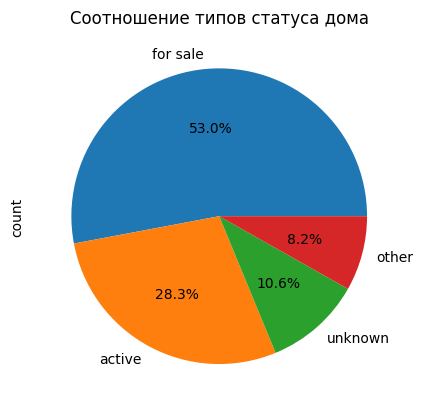

In [62]:
# Создаём список с итоговыми записями
final_items = ['for sale', 'active', 'unknown']

# Значения, которые не в списке. меняем на 'other'
data['status'] = data['status'].apply(lambda x: 'other' if x not in final_items else x)

# Визуализируем полученное распределение значений в признаке
status_type = data['status'].value_counts()
status_type.plot(y='status', kind='pie', title='Соотношение типов статуса дома', autopct='%1.1f%%');

### 2.3. Признак 'propertyType'

Заполним пропуски в данном признаке значениями 'unknown'.

In [64]:
data['propertyType'] = data['propertyType'].fillna('unknown')
data['propertyType'].unique()

array(['Single Family Home', 'single-family home', 'lot/land', ...,
       'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam',
       'Lake House, Single Detached, Tudor',
       'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit'],
      dtype=object)

In [65]:
# Приводим записи к нижнему регистру
data['propertyType'] = data['propertyType'].str.lower()
data['propertyType'].unique()

array(['single family home', 'single-family home', 'lot/land', ...,
       'cabin/lodge, contemporary, converted barn, cottage, loft with bedrooms, log home, post & beam',
       'lake house, single detached, tudor',
       'bilevel, converted dwelling, loft with bedrooms, condo/unit'],
      dtype=object)

In [66]:
data['propertyType'] = data['propertyType'].astype(str)

Обратим внимание на то, что очень много недвижимости в данном признаке различается по признаку 'single family' - 'multi family'. Вычленим эти признаки из всех записей.

In [67]:
family = find_string('family', data['propertyType'])

In [68]:
# Списки с различными вариациями записей данных признаков
single_family = ['single family home', 'single-family home', 'single family']
multy_family = ['multi-family', 'multi-family home', 'multi family']

In [69]:
# Унифицируем записи данных признаков в нашем наборе данных.
data['propertyType'] = data['propertyType'].apply(lambda x: 'single_family' if x in single_family else x)
data['propertyType'] = data['propertyType'].apply(lambda x: 'multy_family' if x in multy_family else x)
data['propertyType'].unique()

array(['single_family', 'lot/land', 'townhouse', ...,
       'cabin/lodge, contemporary, converted barn, cottage, loft with bedrooms, log home, post & beam',
       'lake house, single detached, tudor',
       'bilevel, converted dwelling, loft with bedrooms, condo/unit'],
      dtype=object)

In [70]:
data['propertyType'].value_counts().head(60)

propertyType
single_family                               186577
condo                                        42518
unknown                                      34764
lot/land                                     20526
townhouse                                    18345
multy_family                                 12081
land                                         10934
condo/townhome/row home/co-op                 7701
traditional                                   5913
coop                                          3265
high rise                                     1823
ranch                                         1781
mobile/manufactured                           1618
detached, one story                           1614
single detached, traditional                  1581
contemporary                                  1557
1 story                                       1235
colonial                                      1205
mobile / manufactured                         1066
contemporary/moder

Итак, самыми распространёнными типами домов являются condo (кондо), land (земельный участок) и townhouse (дома, которые расположены в ряд и имеют общие стены). Именно их мы и выделим в отдельные признаки, записав все остальные как other.

In [71]:
# Ищем подстроку 'condo' и заносим строки с данной подстрокой в список
condo = find_string('condo', data['propertyType'])
# Меняем все записи с данными строками на 'condo'
data['propertyType'] = data['propertyType'].apply(lambda x: 'condo' if x in condo else x)
data['propertyType'].unique()

array(['single_family', 'lot/land', 'townhouse', ..., 'townhouse, villa',
       'cabin/lodge, contemporary, converted barn, cottage, loft with bedrooms, log home, post & beam',
       'lake house, single detached, tudor'], dtype=object)

На наш взгляд, все земельные участки нужно удалить. Наша цель - предсказание стоимости домов. Формирование стоимости на земельные участки может быть подвергнуто другой логике и повлиять на наш прогноз.

In [72]:
# Ищем все строки с подстрокой 'land' и выводим их на экран.
land = find_string('land', data['propertyType'])
land

['lot/land',
 'land',
 'multi-level, new englander',
 'new englander',
 'double-wide mobile with land',
 'contemporary, new englander',
 'single-wide mobile with land, traditional',
 'single detached, single-wide mobile with land',
 'single-wide mobile with land']

Как видно, земельные участки имею только два вида записи: 'lot/land' и 'land'. Всё остально в данном списке - это дома. Поэтому список land нужно переписать.

In [73]:
land = ['lot/land', 'land']
data['propertyType'] = data['propertyType'].apply(lambda x: 'land' if x in land else x)
data['propertyType'].value_counts().head(60)

propertyType
single_family                           186577
condo                                    51470
unknown                                  34764
land                                     31460
townhouse                                18345
multy_family                             12081
traditional                               5913
coop                                      3265
high rise                                 1823
ranch                                     1781
mobile/manufactured                       1618
detached, one story                       1614
single detached, traditional              1581
contemporary                              1557
1 story                                   1235
colonial                                  1205
mobile / manufactured                     1066
contemporary/modern                       1000
apartment                                  914
2 stories                                  911
mfd/mobile home                            792


Удалим из нашего набора данных записи о земельных участках.

In [74]:
data = data[data['propertyType'] != 'land']
# Проверяем, сколько записей осталось в дата-сете.
data.shape[0]

345263

In [75]:
# Ищем подстроку 'townhouse' и заносим строки с данной подстрокой в список
townhouse = find_string('townhouse', data['propertyType'])
# Меняем все записи с данными строками на 'townhouse'
data['propertyType'] = data['propertyType'].apply(lambda x: 'townhouse' if x in townhouse else x)
data['propertyType'].value_counts().head(60)

propertyType
single_family                           186577
condo                                    51470
unknown                                  34764
townhouse                                18517
multy_family                             12081
traditional                               5913
coop                                      3265
high rise                                 1823
ranch                                     1781
mobile/manufactured                       1618
detached, one story                       1614
single detached, traditional              1581
contemporary                              1557
1 story                                   1235
colonial                                  1205
mobile / manufactured                     1066
contemporary/modern                       1000
apartment                                  914
2 stories                                  911
mfd/mobile home                            792
single detached                            751


In [76]:
# Список с теми значениями. которые останутся в данном признаке
final_property_types = [
    'single_family', 
    'condo', 
    'unknown', 
    'townhouse',
    'multy_family'
    ]

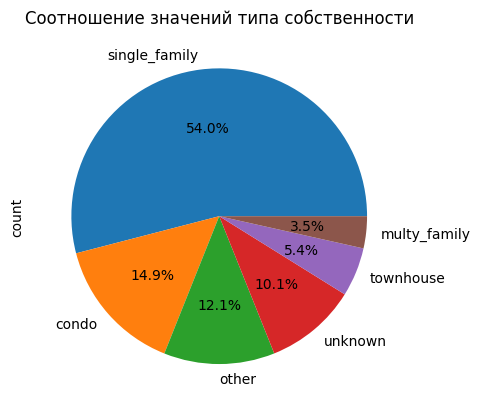

In [77]:
# Значения, которые не в списке, меняем на 'other'
data['propertyType'] = data['propertyType'].apply(lambda x: 'other' if x not in final_property_types else x)

# Визуализируем полученное распределение значений в признаке
status_type = data['propertyType'].value_counts()
status_type.plot(y='propertyType', kind='pie', title='Соотношение значений типа собственности', autopct='%1.1f%%');

### 2.4. Признаки, относящиеся к географическому положению дома.

К таким признакам относятся street, city, zipcode, state. Какую информацию можно из них извлечь? Какждый штат США имеет свой рейтинг по различным аспектам жизни. Такие сведения мы получили на сайте https://worldpopulationreview.com/state-rankings/quality-of-life-by-state, где данная информация доступна для скачивания в виде csv-файла. Посмотрим на эти сведения.

In [80]:
quality_or_life_by_state = pd.read_csv('quality-of-life-by-state-2024.csv')
quality_or_life_by_state.head()

,state,QualityOfLifeTotalScore,QualityOfLifeQualityOfLife,QualityOfLifeAffordability,QualityOfLifeEconomy,QualityOfLifeEducationAndHealth,QualityOfLifeSafety
0,Alabama,45.61,40,1,40,48,32
1,Alaska,40.93,50,42,22,30,45
2,Arizona,48.31,21,25,14,39,40
3,Arkansas,42.42,46,4,34,45,47
4,California,52.03,2,50,15,24,27


Мы думаем, что из данной таблицы можно извлечь такие признаки, как QualityOfLifeTotalScore и QualityOfLifeEconomy. Почему? Общий рейтинг качества жизни делает тот или иной штат более привлевательным для жизни, а значит, жильё в данном штате может быть дороже. Лбщий уровень экономического развития влияет на покупательскую способность граждан, что также может отражаться на ценах, в том числе и на недвижимость.

In [81]:
quality_or_life_by_state = quality_or_life_by_state[['QualityOfLifeTotalScore', 'QualityOfLifeEconomy']]

Поскольку в нашем дата-сете информация о штате представлена в двухбуквенном формате, осталось найти таблицу соответствия полного названия штата и его двухбуквенной аббревиатуры и соединить две таблицы, а затем  присоединить новые признаке к нашему набору данных. Такую таблицу в csv-формате мы скачали с сайта https://www.downloadexcelfiles.com/wo_en/download-excel-file-list-states-us#gsc.tab=0.

In [82]:
list_states = pd.read_excel('list-states-us-36j.xlsx')
list_states.head()

,Sr.No,State,Abbr.,Capital,Largest city,Statehood,Population est.,Total area in mi2 (km2),Land area in mi2 (km2),Water area in mi2 (km2)
0,1,Alabama,AL,Montgomery,Birmingham,"December 14, 1819",4822023,"52,420 (135,767)","50,645 (131,170)","1,775 (4,597)"
1,2,Alaska,AK,Juneau,Anchorage,"January 3, 1959",731449,"665,384 (1,723,337)","570,641 (1,477,950)","94,743 (245,383)"
2,3,Arizona,AZ,Phoenix,Phoenix,"February 14, 1912",6553255,"113,990 (295,233)","113,594 (294,207)","396 (1,026)"
3,4,Arkansas,AR,Little Rock,Little Rock,"June 15, 1836",2949131,"53,179 (137,733)","52,035 (134,770)","1,143 (2,960)"
4,5,California,CA,Sacramento,Los Angeles,"September 9, 1850",38041430,"163,695 (423,968)","155,779 (403,466)","7,916 (20,502)"


In [83]:
# Обрезаем таблицу
list_states = list_states[['State', 'Abbr.']]
# Переименовываем столбец с названиями штатов для удобства соединения
list_states = list_states.rename(columns = {'State': 'state'})
# Соединяем с таблицей quality_or_life_by_state
quality_or_life_by_state = pd.concat([quality_or_life_by_state, list_states],
    axis = 1
    ).drop('state', axis = 1).rename( # Выкидываем столбец с названиями штатов
        columns = {             
            'Abbr.': 'state' # Снова переименовываем столбцы для удобства соединения с исходной таблицей
        }
    )
quality_or_life_by_state.head()

,QualityOfLifeTotalScore,QualityOfLifeEconomy,state
0,45.61,40,AL
1,40.93,22,AK
2,48.31,14,AZ
3,42.42,34,AR
4,52.03,15,CA


In [86]:
# Создаём новые признаки в исходном наборе данных.
data = data.merge(
    quality_or_life_by_state, on = 'state', how = 'left'
    )
data.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy
0,active,single_family,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",0,51.51,17.0
1,for sale,single_family,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",0,52.11,4.0
2,for sale,single_family,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",1,52.03,15.0
3,for sale,single_family,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",0,49.00,26.0
4,for sale,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,"$209,000",0,56.42,38.0


Оставшиеся признаки street, city и zipcode являются, по сути, дублирующими друг друга. Из них для нас большую важность представляет признак zipcode, потому что в США есть статистика по каждому индексу, включающая в себя среднюю цену на недвижимость, а этот фактор очень важен для нас в свете решаемой задачи. Данные о средней стоимости жилья мы будем парсить с сайта https://mapszipcode.com.

In [87]:
url = 'https://mapszipcode.com/' # Определяем значение URL страницы для запроса
response = requests.get(url) # Делаем GET-запрос к ресурсу и результат ответа сохраняем в переменной response

print(response) # Выводим значение response на экран как объект

print(response.status_code) # Выводим числовое значение response на экран

<Response [200]>
200


Отклик с сайта получен. Анализ интернет-страницы показывает, что нужный нам список находится под тегом 'li'. 

In [88]:
page = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер
links = page.find_all('li') # Ищем все ссылки на странице и сохраняем в переменной links в виде списка
print([link.text for link in links]) # Выводим на экран полученный список

['Browse', 'Compare', 'Top Lists', '\nMore Tools ⇓\n\nDistance Calculator\nZip Codes Within Radius\n\n', 'Distance Calculator', 'Zip Codes Within Radius', '\nBrowse zip codes by state / county\n', '\nGet zip codes within a radius\n', '\nCompare Zip Codes\n', '\nZip code 90210 real estate details\n', '\nZip code 10003 household income\n', '\nCompare zip code 90210 to 10003\n']


Нужные нам данные находятся во втором с конца элементе списка. Удалим из него запятую и выделим все цифровые символы. Это и будет интересующая нас средняя стоимость жилья.

In [89]:
re.findall(r'\d+', [link.text for link in links][-2].replace(',', ''))

['10003']

Данные выводятся в формате списка. Нам останется только выделить нулевой объект данного списка и привести его к числовому формату.

Мы заметили, что даже если в поисковую строку на данном сайте ввести неправильные указания штата и города, но правильный зип-код, выведется корректная инфоромация именно по введённому зип-коду. Например, введём такую ссылку: https://mapszipcode.com/massachusetts/somerville/28387/. В этой ссылке я неверно указал город и штат. Насамом деле зип-код 28387 соответствует городу Southern Pines, как это следует из нулевой сроки нашего дата-сета. Но на экран выводится информация именно по зип-коду:

![](Безымянный1.png)

На скриншоте видно, что хоть в навигации и прописаны штат Массачусетс и город Соммервилль, но на самом деле выведена информация по городу Юж. Пайнс и зип-коду, который мы ввели. Запомним это. Данный факт нам поможет перебирать страницы и извлекать нужную информацию по зип-кодам.

Но прежде нам необходимо проверить корректность записи зип-кодов в нашем наборе данных. Почтовый индекс в США должен состоять из пяти цифровых символов. Проверим, так ли это в нашем дата-сете. Для этого организуем проверку на длину записей в столбце и запомним все, в которых длина записи не равна 5.

In [90]:
# Создадим список, куда будем заносить записи из столбца 'zipcode',
# в которых не 5 символов
not_5_symbols_in_zipcodes = []

# Ищем такие запсиси
for elem in data['zipcode'].unique().tolist():
    if len(elem) != 5:
        not_5_symbols_in_zipcodes.append(elem)
    else:
        None
        
# Выводим только уникальные записи, трансформируя список в кортеж
not_5_symbols_in_zipcodes_set = set(not_5_symbols_in_zipcodes)
not_5_symbols_in_zipcodes_set

{'--',
 '0',
 '05441-4400',
 '07004-1106',
 '07004-1300',
 '07004-1413',
 '07004-1528',
 '07004-1607',
 '07004-1809',
 '07004-1878',
 '07004-1935',
 '07004-2116',
 '07004-2137',
 '07004-2214',
 '1103',
 '1104',
 '1105',
 '1106',
 '1107',
 '1108',
 '1109',
 '1118',
 '1119',
 '112229',
 '1128',
 '1129',
 '1151',
 '123456',
 '1453',
 '1602',
 '1603',
 '1604',
 '1605',
 '1606',
 '1607',
 '1608',
 '1609',
 '1610',
 '1611',
 '1850',
 '1851',
 '1852',
 '1854',
 '2105',
 '2108',
 '2109',
 '2110',
 '2111',
 '2113',
 '2114',
 '2115',
 '2116',
 '2118',
 '2119',
 '2120',
 '2121',
 '2122',
 '2124',
 '2125',
 '2126',
 '2127',
 '2128',
 '2129',
 '2130',
 '2131',
 '2132',
 '2134',
 '2135',
 '2136',
 '2138',
 '2140',
 '2141',
 '2199',
 '2210',
 '2215',
 '2467',
 '2601',
 '2630',
 '2632',
 '2635',
 '2648',
 '2655',
 '2668',
 '2675',
 '2740',
 '2744',
 '2745',
 '2746',
 '27529-2107',
 '27529-4334',
 '27529-4367',
 '27529-5051',
 '27587-9373',
 '27587-9999',
 '27601-1141',
 '27601-1443',
 '27601-2737',
 '

Итак все непятизначные зип-коды можно разделить на четыре типа:
1. пропущенные значения (0 и --),
2. четырёхзначные коды,
3. шестизначные коды,
4. коды через тире.

Придётся разбираться с каждым из этих типов.

Начнём по порядку с пропущенных значений.

In [91]:
data[(data['zipcode'] == '0') | (data['zipcode'] == '--')]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy
76497,other,other,Cornejo Ricardo Descalzi,NaN,"{'atAGlanceFacts': [{'factValue': '1995', 'fac...",NaN,Quito Ecuador,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,0,NaN,NY,NaN,"470,000",0,60.64,37.0
211800,other,unknown,0 N Gopher Canyon Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",NaN,--,449 acres,CA,NaN,"$60,000,000",0,52.03,15.0
215350,unknown,townhouse,1744 N Dixie Hwy # 1744,3.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...","2,043",--,3,FL,NaN,"$425,000",0,58.07,6.0


К счастью, пропущенных значений оказалось немного, и мы можем заполнить их вручную по городу и адресу. В результате поиска в интернете удалось выяснить зип-коды по адресу, которые в соответствии с номером сроки равны:
* 76497 - это вообще эквадорский адрес, данную запись нужно удалить;
* 211800 - 92003;
* 215350 - 33305.

Заполним пропуски указанными значениями.

In [92]:
data = data.drop(index=[76497])
data.loc[211800, 'zipcode'] = 92003
data.loc[215350, 'zipcode'] = 33305

Анализ четырёхзначных кодов показывает, что это правильные коды, у которых на первом месте отсутствует ноль, например:

In [93]:
data[data['zipcode'] == '1103']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy
103646,for sale,condo,235 State St APT 221,Bathrooms: 1,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,Springfield,"[{'rating': ['3/10', 'NA', '1/10'], 'data': {'...",Total interior livable area: 924 sqft,1103,1 bd,MA,1.0,"$97,000",0,62.65,10.0


Как видим под кодом 1103 находится город Спрингфилд. Но его код на самом деле 01103. И так у всех четырёхзначных кодов. Следовательно, чтобы исправить данный факт, достаточно ко всем четырёхзначным кодам добавить 0.

In [94]:
# Вначале приведём все записи в столбце к строковому виду
data['zipcode'] = data['zipcode'].astype(str)
# Теперь добавим 0 ко всем четырёхзначным записям
data['zipcode'] = data['zipcode'].apply(lambda x: '0' + x if len(x) == 4 else x)

Проверим результат.

In [95]:
data.loc[103646]['zipcode']

'01103'

Как видим, запись в сроке 103769 исправилась.

Шестизначные коды. Таких всего три. Посмотрим на эти записи.

In [96]:
data[(data['zipcode'] == '112229') | (data['zipcode'] == '123456') | (data['zipcode'] == '331446')]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy
78370,active,other,6789 White River Home,NaN,"{'atAGlanceFacts': [{'factValue': '1989', 'fac...",NaN,Other City Value - Out Of Area,"[{'rating': [], 'data': {'Distance': [], 'Grad...","4,000",123456,NaN,NY,NaN,"899,999",0,60.64,37.0
122591,active,other,2315 Gerritsen Ave Unit 3A,NaN,"{'atAGlanceFacts': [{'factValue': '2001', 'fac...",NaN,Brooklyn,"[{'rating': ['9', '4', '7', 'NR'], 'data': {'D...","1,100",112229,NaN,NY,NaN,"599,000",0,60.64,37.0
147715,active,other,301 Altara #402,NaN,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Coral Gables,"[{'rating': ['7', 'NR', '10', '5', '5'], 'data...","1,212",331446,NaN,FL,NaN,"620,000",0,58.07,6.0


Как видим, дом на строке 78370 вообще не имеет адреса и локализовать его затруднительно. Эту строку мы удалим. Два других дома на самом деле имеют зип-код 11229 и 33146 соответственно.

In [97]:
# Удаляем строку с индексом 78370
data = data.drop(index=[78370])
# Заменяем ошибочное значение в строках с индексами 122591 и 147715
data.loc[122591, 'zipcode'] = '11229'
data.loc[147715, 'zipcode'] = '33146'

Переходим к записям, в которых зип-код записан через тире.

In [98]:
data[data['zipcode'] == '05441-4400']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy
257498,active,other,1331 Waterville Mountain Rd,NaN,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Bakersfield,"[{'rating': ['6', '2'], 'data': {'Distance': [...","2,745",05441-4400,NaN,VT,2,"695,000",0,57.52,8.0


Проверка таких записей по адресу показывает, что значение до тире как раз и соответствует зип-коду. То есть, нам достаточно обрезать такие записи.

In [99]:
data['zipcode'] = data['zipcode'].apply(lambda x: x[:5] if '-' in x else x)
data.loc[257498]

status                                                                active
propertyType                                                           other
street                                          1331 Waterville Mountain Rd 
baths                                                                    NaN
homeFacts                  {'atAGlanceFacts': [{'factValue': '2003', 'fac...
fireplace                                                                NaN
city                                                             Bakersfield
schools                    [{'rating': ['6', '2'], 'data': {'Distance': [...
sqft                                                                   2,745
zipcode                                                                05441
beds                                                                     NaN
state                                                                     VT
stories                                                                    2

Итак, записи обрезались до нужного значения. Проверим ещё раз, все ли оставшиеся запси пятизначные.

In [100]:
# Создадим список, куда будем заносить записи из столбца 'zipcode',
# в которых не 5 символов
not_5_symbols_in_zipcodes = []

# Ищем такие запсиси
for elem in data['zipcode'].unique().tolist():
    if len(elem) != 5:
        not_5_symbols_in_zipcodes.append(elem)
    else:
        None
        
# Выводим только уникальные записи, трансформируя список в кортеж
not_5_symbols_in_zipcodes_set = set(not_5_symbols_in_zipcodes)
not_5_symbols_in_zipcodes_set

set()

Как видно, все зип-коды приведены к корректному виду. Теперь можно спарсить информацию о медианной стоимости жилья по каждому коду. Спарсенные значения будем заносить в словарь, где в качестве ключей будут выступать зип-коды, а в качестве значений - медианная стоимость домов.

In [77]:
# Список с уникальными значениями зип-кодов
zipcodes = data['zipcode'].unique().tolist()

# словарь, в который будем заносить медианные стоимости на дома в зависимости от зип-кода
median_cost_information = dict()

# Организуем цикл
for zipcode in zipcodes: # Перебираем зип-коды
    url = 'https://mapszipcode.com/massachusetts/somerville/' + zipcode # Подключаемся к соответствующей странице
    response = requests.get(url)
    
    page = BeautifulSoup(response.text, 'html.parser') # Получаем список под тегом li
    links = page.find_all('li')
    
    # Берём -2 элемент списка и очищаем его от запятых
    median_cost = [link.text for link in links][-2].replace(',', '')
    # На всяки случай проверяем на отсутствие интересующих нас сведений 
    if len(re.findall(r'\d+', median_cost)) != 0: # Если сведения есть , заносим его в словарь
        median_cost = int(re.findall(r'\d+', median_cost)[0])
        median_cost_information[zipcode] = median_cost
    else:
        median_cost_information[zipcode] = 0 # В противном случае заносим 0

Для удобства преобразуем словарь в дата-фрейм.

In [83]:
median_home_value = pd.DataFrame(list(median_cost_information.items()), columns = ['zipcode', 'Med_home_value'])
median_home_value.head()

,zipcode,Med_home_value
0,28387,226300
1,99216,185700
2,90049,1000000
3,75205,931800
4,32908,126900


In [84]:
median_home_value.to_excel('median_home_value.xlsx')

In [101]:
median_home_value = pd.read_excel('median_home_value.xlsx')

In [102]:
# На всякий случай приведём записи в столбце zipcode к строковому виду
median_home_value['zipcode'] = median_home_value['zipcode'].astype(str)

# Объединим наш дата-фрейм с таблицей median_home_value:
data = data.merge(median_home_value, on = 'zipcode', how = 'left')
data.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value
0,active,single_family,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",0,51.51,17.0,226300.0
1,for sale,single_family,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",0,52.11,4.0,185700.0
2,for sale,single_family,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",1,52.03,15.0,1000000.0
3,for sale,single_family,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",0,49.00,26.0,931800.0
4,for sale,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,"$209,000",0,56.42,38.0,152100.0


Проверим, все ли ячейки заполнились.

In [105]:
data[data['Med_home_value'] == 0]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value


Нулевых значений нет, значит, все ячейки заполнились корректно. На наш взгляд, мы извлекли максимум полезной информации из признаков, обозначающих так или иначе географическое положение недвижимости. Удалять их пока не будем, могут пригодиться.

### Признак 'baths'

Посмотрим на этот признак.

In [106]:
data['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '5.0', '1,500', '7.0', '1,250',
       '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500', '1.5 Baths',
       '2,750', 'Bathrooms: 6', '4.5 Baths', '0', '750', '5.5+', '6',
       '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ',
       '5 ba', '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0',
       '1.1 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 B

Что обращает на себя внимание:
1. Данные записаны в строковом формате, но содержат указание на количесвто ванн (ванных комнат) в доме.
2. В данных есть неадекватно огромные числа.
3. В данных есть дробные числа (напр., 3.2 ванных комнаты).
4. В данных есть записи, разделённые косой линией (напр, '116 / 116 / 116').

Придётся изучить данные подробнее иразобраться с каждым из этих пунктов.

#### Нечисловые символы в записях.

Это наименьшее из зол. Эту проблемы будем решать поиском числовых цифровых символов. Но потом.

#### Большое количество ванных.

Посмотрим на эти дома.

In [107]:
data[(data['baths'] == '2,500') | (data['baths'] == '5,000') | (data['baths'] == '7,500+')]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value
108,active,other,110 Munden Dr,"2,500","{'atAGlanceFacts': [{'factValue': '1963', 'fac...",NaN,San Antonio,"[{'rating': ['4', '4', '4'], 'data': {'Distanc...","1,470",78216,Baths,TX,NaN,"199,900",0,49.00,26.0,151100.0
2224,active,unknown,2442 Red Gate Rd,"2,500","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,ORLANDO,"[{'rating': ['3', '7', '2', '4', '7'], 'data':...",NaN,32818,Baths,FL,NaN,"125,000",0,58.07,6.0,138400.0
2336,other,other,1043 Ericson St,"2,500","{'atAGlanceFacts': [{'factValue': '1981', 'fac...",NaN,San Antonio,"[{'rating': ['3', '4', '3'], 'data': {'Distanc...","1,863",78245,Baths,TX,NaN,"193,000",0,49.00,26.0,114700.0
3305,active,other,3103 Rowhouse Ln,"2,500","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['3', '3', '2'], 'data': {'Distanc...","2,052",77080,Baths,TX,2,"335,995",0,49.00,26.0,128200.0
3526,active,other,16684 Williams St,"5,000","{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Thornton,"[{'rating': ['8', '7', '6'], 'data': {'Distanc...","3,765",80602,Baths,CO,NaN,"514,000",0,53.37,18.0,654004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343848,active,condo,7333 Valley View Ln #705,"7,500+","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Dallas,"[{'rating': ['5', '9', '7', '7', '7', '5'], 'd...","1,350",75240,Baths,TX,NaN,"299,900",0,49.00,26.0,162300.0
343943,active,unknown,195 World Of Tennis Sq,"5,000","{'atAGlanceFacts': [{'factValue': '1971', 'fac...",1,Lakeway,"[{'rating': ['10', '9', '8'], 'data': {'Distan...","1,610",78738,Baths,TX,2,"264,500",0,49.00,26.0,466700.0
344333,active,unknown,1918 Oroville Ct,"2,500","{'atAGlanceFacts': [{'factValue': '2001', 'fac...",NaN,Charlotte,"[{'rating': ['3', '7', 'NR', '6', '3'], 'data'...","2,756",28214,Baths,NC,NaN,"345,000",0,51.51,17.0,131100.0
344452,other,other,1219 Autumn Moon,"2,500","{'atAGlanceFacts': [{'factValue': '2005', 'fac...",NaN,San Antonio,"[{'rating': ['3', '3', '2'], 'data': {'Distanc...","2,422",78245,Baths,TX,NaN,"205,990",0,49.00,26.0,114700.0


Выборочная проверка подобного рода домов по адресу выявила, что на самом деле запятая в данных записях разделяет не тысячи, а целые от десятых, т.е. в записях наболюдается неупорядоченность: целые от десятых разделяет то точка, то запятая. Исправим эту проблему, заменив запятую точкой.

In [108]:
# Заменяем запятые на точки
data['baths'] = data['baths'].str.replace(',', '.')

#### Дробное количество ванных.

Более внимательное изучение сайтов с риэлторской информацией США показал, что ванные комнаты в этой стране действительно могут иметь дробный показатель. Там различаются такие виды ванных комнат, как "полная", "половнная" и даже "четвертная" ванные комнаты. Так что здесь всё корректно. Думаю, мы оставим такие записи.

#### Записи с косой линией.

Внимательное изучение данных лотов показало, что все они соответствуют не одному дому, а нескольким, расположенным рядом. Получить информацию о каждом доме в отдельно не представляется возможным, поэтому мы удалим данные записи из нашего набора данных.

In [109]:
data = data[
    (data['baths'] != '1-0 / 1-0 / 1') & 
    (data['baths'] != '116 / 116 / 116') & 
    (data['baths'] != '3-1 / 2-2') & 
    (data['baths'] != '1 / 1 / 1 / 1') & 
    (data['baths'] != '2-1 / 2-1 / 1-1 / 1-1') & 
    (data['baths'] != '1 / 1-0 / 1-0 / 1-0')
    ]

Отдельно разберём случаи с записями '0 / 0'

In [110]:
data[data['baths'] == '0 / 0']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value
1965,active,single_family,13 Eagleview Dr,0 / 0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Coast,"[{'rating': ['7', '6', '5', '5', '4', '6'], 'd...",2241,32137,4,FL,NaN,"$549,900",0,58.07,6.0,208300.0
8586,active,single_family,20900 14 Mile Rd,0 / 0,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Battle Creek,"[{'rating': ['3', '3', 'NR', 'NR'], 'data': {'...",1248,49014,0.0,MI,Ranch,"$136,900",0,50.87,47.0,111500.0
35384,active,single_family,81 Claiborne St,0 / 0,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Nashville,"[{'rating': ['NR', '3', '3', '2', '4', '10', '...",50966,37210,0.0,TN,2.00,"$3,000,000",0,48.85,21.0,115700.0
91759,active,single_family,4410 Hannah Ford Rd,0 / 0,"{'atAGlanceFacts': [{'factValue': '1988', 'fac...",1,Pegram,"[{'rating': ['4', '4', '5', '8', '5', 'NR'], '...",7004,37143,0.0,TN,1.00,"$800,000",0,48.85,21.0,186300.0
108611,active,single_family,3504 Lara,0 / 0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",No,El Cenizo,"[{'rating': ['5', '6', '2', '1', '5', 'NR'], '...",1024,78046,0,TX,1 Story,"$24,900",0,49.00,26.0,88800.0
110219,active,other,Mill Creek Trl,0 / 0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cleveland,"[{'rating': ['7', '7', '8', '9', '9'], 'data':...",0,30528,0.0,GA,NaN,"$99,000",0,50.76,13.0,162700.0
119326,active,other,8798 W Highway 326,0 / 0,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Ocala,"[{'rating': ['1', '4', '6', '1', '6', '5', 'NR...",0,34482,0,FL,1,"$299,000",0,58.07,6.0,140200.0
139240,active,other,1091 SW 123rd Pl Lot 4,0 / 0,"{'atAGlanceFacts': [{'factValue': '1973', 'fac...",NaN,Ocala,"[{'rating': ['2', '5', '4', '2', '4', '6', 'NR...",0,34473,0,FL,1,"$497,650",0,58.07,6.0,133100.0
153692,active,other,Beechwood Dr,0 / 0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cleveland,"[{'rating': ['7', '7', '8', '9', '9'], 'data':...",0,30528,0.0,GA,NaN,"$20,000",0,50.76,13.0,162700.0
168503,active,other,Johns Dr,0 / 0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cleveland,"[{'rating': ['7', '7', '8', '9', '9'], 'data':...",0,30528,0.0,GA,NaN,"$240,000",0,50.76,13.0,162700.0


Записи проверим на ресурсе https://www.zillow.com и заполним корректными значениями.

In [111]:
data.loc[1965, 'baths'] = 3
data.loc[8586, 'baths'] = 0
data.loc[35384, 'baths'] = 0
data.loc[91759, 'baths'] = 0
data.loc[108611, 'baths'] = 0
data.loc[110219, 'baths'] = 3
data.loc[119326, 'baths'] = 2
data.loc[139240, 'baths'] = 0
data.loc[153692, 'baths'] = 0
data.loc[168503, 'baths'] = 0
data.loc[204905, 'baths'] = 0
data.loc[223714, 'baths'] = 0
data.loc[227278, 'baths'] = 2
data.loc[248930, 'baths'] = 0
data.loc[259103, 'baths'] = 0
data.loc[288180, 'baths'] = 0
data.loc[298273, 'baths'] = 3
data.loc[306033, 'baths'] = 0
data.loc[312007, 'baths'] = 0
data.loc[315780, 'baths'] = 0
data.loc[329395, 'baths'] = 0

# Проверяем, какие записи остались
data[data['baths'] == '0 / 0']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value


Итак, мы заменили все записи с косой чертой. Теперь сделаем то же самое с некоторыми другим записями в этом столбце.

In [112]:
data[data['baths'] == '—']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value
28444,active,unknown,211 Bella Riva Dr,—,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",2,Austin,"[{'rating': ['8', '9', '8'], 'data': {'Distanc...","9,614",78734,Baths,TX,3,"4,850,000",0,49.0,26.0,321700.0
95208,active,unknown,15900 Chateau Ave,—,"{'atAGlanceFacts': [{'factValue': '2013', 'fac...",2,Austin,"[{'rating': ['8', '9', '8'], 'data': {'Distanc...","7,887",78734,Baths,TX,3,"4,199,000",0,49.0,26.0,321700.0
116927,active,unknown,723 Cutlass,—,"{'atAGlanceFacts': [{'factValue': '1997', 'fac...",2,Lakeway,"[{'rating': ['10', '9', '8'], 'data': {'Distan...","3,922",78734,Baths,TX,3,"1,700,000",0,49.0,26.0,321700.0
218187,active,unknown,615 Robin Dale Ct,—,"{'atAGlanceFacts': [{'factValue': '1988', 'fac...",4,Lakeway,"[{'rating': ['10', '9', '8'], 'data': {'Distan...","5,161",78734,Baths,TX,1,"1,850,000",0,49.0,26.0,321700.0
226194,active,unknown,16206 Sydney Carol Ln,—,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",1,Austin,"[{'rating': ['8', '9', '8'], 'data': {'Distanc...","2,432",78734,Baths,TX,3,"554,871",0,49.0,26.0,321700.0
265340,active,unknown,104 Canyon Turn Trl,—,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",3,Austin,"[{'rating': ['10', '10', '8'], 'data': {'Dista...","6,007",78734,Baths,TX,2,"1,995,000",0,49.0,26.0,321700.0


In [113]:
data.loc[28444, 'baths'] = 9
data.loc[95208, 'baths'] = 9
data.loc[116927, 'baths'] = 5
data.loc[218187, 'baths'] = 5
data.loc[226194, 'baths'] = 2
data.loc[265340, 'baths'] = 7

In [114]:
data[data['baths'] == 'Bathrooms: SemiMod']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value
76704,for sale,multy_family,433 Railroad Ave,Bathrooms: SemiMod,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",NaN,Scranton,"[{'rating': ['5/10', '5/10', '2/10'], 'data': ...","Total interior livable area: 1,800 sqft",18505,6 bd,PA,2.0,"$139,900",0,56.42,38.0,114400.0


In [115]:
data.loc[76704, 'baths'] = 2

В этом столбце остались записи с пропущенными значениями. Пока их оставим, а на этом этапе выделим числовые значения из всех записей в этом столбце.

In [116]:
# Выделяем числовые значения из записей в столбце
data['baths'] = data['baths'].str.findall(r'\d*\.\d+|\d+')

# Поскольку полученные значения представлены в формате списка, выделим из него числовое значение
data['baths'] = data['baths'].apply(
    lambda x: float(x[0]) if type(x) == list and len(x) == 1 # Проверяем запись в ячейке на тип и длину
    else np.nan if type(x) == list and len(x) == 0 # Если список пустой, заполняем ячейку пропуском
    else x # Если в ячейке не список, оставляем ту запись, которая была
    )

Теперь приведём все записи в данном столбце к числовому формату.

In [117]:
# Приводим к формату float
data['baths'] = data['baths'].astype(float)
# Смотрим на значения в столбце
sorted(data['baths'].unique())

[0.0,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 1.8,
 2.0,
 2.1,
 2.2,
 2.25,
 2.5,
 2.75,
 2.8,
 3.0,
 3.2,
 3.25,
 3.3,
 3.5,
 3.75,
 4.1,
 4.25,
 4.75,
 5.2,
 5.25,
 5.5,
 6.75,
 8.0,
 nan,
 1.1,
 3.1,
 4.0,
 4.5,
 5.0,
 6.0,
 6.5,
 7.0,
 7.5,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 14.0,
 14.5,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 32.0,
 34.0,
 35.0,
 36.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 55.0,
 60.0,
 64.0,
 68.0,
 76.0,
 241.0,
 750.0]

In [118]:
data['baths'].describe()

count    264672.000000
mean          3.427153
std          22.400371
min           0.000000
25%           2.000000
50%           2.500000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

Обращают на себя внимание трёхзначные значения количества ванных комнат (241 и 750). Выборочная проверка по адресу на сайте https://www.zillow.com показала, что это ошибочные записи. В доме с 241 ванными комнатами их на самом деле 4, а в домах, где указано 750 ванных комнат их количесвто колеблется в районе медианы по данному признаку. Поэтому заменим значение 750 на медиану.

In [119]:
data['baths'] = data['baths'].apply(
    lambda x: 4 if x == 241 
    else data['baths'].median() if x == 750
    else x
)

Посмотрим на распределение значений.

In [120]:
data['baths'].describe()

count    264672.000000
mean          2.756910
std           1.419958
min           0.000000
25%           2.000000
50%           2.500000
75%           3.000000
max          76.000000
Name: baths, dtype: float64

Оставшиеся в признаке пропуски пока оставим.

### Признак 'homeFacts'

Посмотрим на характер записи в ячейке

In [122]:
for i in np.arange(10):
    print(data['homeFacts'][i])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}
{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}
{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLabel': 'Pa

Итак, записи в ячейках представляют собой словарь с ключом 'atAGlanceFacts'. В значении - список со словарями. Рассмотрим этот список подробнее.

In [123]:
list(eval(data['homeFacts'][0]).values())

[[{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]]

Мы видим, что это список из 7 словарей, которые содержат важную информацию:
1. Год постройки,
2. Год модернизации,
3. Тип отопления.
4. Тип кондиционирования,
5. Наличие парковки,
6. Размер приусадебного участка.
7. Стоимость на кв. фут.

Совершенно очевидно, что данная информация представляет для нас ценность, поэтому создадим на её основе новые признаки.

In [124]:
# Организуем перебор вложенных в список словарей
for i in np.arange(7):
    # Извлекаем название признака
    feature_name = list(eval(data['homeFacts'][0]).values())[0][i]['factLabel']
    # Создаём новый столбец с извлечённым названием и заполняем его значениями
    data[feature_name] = data['homeFacts'].apply(lambda x: list(eval(x).values())[0][i]['factValue'])

data.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,...,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,single_family,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,...,51.51,17.0,226300.0,2019,,"Central A/C, Heat Pump",,,None,$144
1,for sale,single_family,12911 E Heroy Ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,...,52.11,4.0,185700.0,2019,,,,,5828 sqft,$159/sqft
2,for sale,single_family,2005 Westridge Rd,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,...,52.03,15.0,1000000.0,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,for sale,single_family,4311 Livingston Ave,8.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,...,49.00,26.0,931800.0,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,for sale,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,...,56.42,38.0,152100.0,1920,,Forced Air,Central,,680 sqft,$233/sqft


Теперь прзнак 'homeFacts' можно удалить.

In [126]:
data = data.drop('homeFacts', axis = 1)

Рассмотрим подробнее новые признаки. И прежде всего, обратим внимание на признак 'Price/sqft'. Помимо него, в данных есть призак 'sqft'. Перемножив их, мы сможем заполнить пропуски в целевой переменной. Но вначале очистим записи в этих признаках от лишних символов и приведём их к числовому занчению.

In [127]:
# Для удобства вначале приведём значения в столбце к строковому виду
data['sqft'] = data['sqft'].astype(str)

# Напишем функция для поиска чисел в строке
def find_numeric(row):
    '''Функция для поиска чисел в строке.
    row - строка в дата-фрейме.
    Возвращает найденное число. Если число не найдено, возвращает 0.'''
    # Ищем числа, в том числе вещественные
    result = re.findall(r'\d*\,\d+|\d+', row)
    # Если число нашлось, выделяем его из списка
    if len(result) >= 1:
        result = result[0]
    # Если число не нашлось, пишем 0
    else:
        result = 0
    return result

# Применяем функцию к столбцу 'sqft'
data['sqft'] = data['sqft'].apply(find_numeric)

Проделаем те же манипуляции со столбцом 'Price/sqft'.

In [128]:
data['Price/sqft'] = data['Price/sqft'].astype(str)
data['Price/sqft'] = data['Price/sqft'].apply(find_numeric)

In [129]:
data.head()

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,...,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,single_family,240 Heather Ln,3.5,Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,...,51.51,17.0,226300.0,2019,,"Central A/C, Heat Pump",,,None,144
1,for sale,single_family,12911 E Heroy Ave,3.0,NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947",99216,3 Beds,...,52.11,4.0,185700.0,2019,,,,,5828 sqft,159
2,for sale,single_family,2005 Westridge Rd,2.0,yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000",90049,3 Beds,...,52.03,15.0,1000000.0,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",965
3,for sale,single_family,4311 Livingston Ave,8.0,yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457",75205,5 Beds,...,49.00,26.0,931800.0,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",371
4,for sale,townhouse,1624 S Newkirk St,NaN,NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897,19145,2 Beds,...,56.42,38.0,152100.0,1920,,Forced Air,Central,,680 sqft,233


Заполняем пропуски в целевой переменной.

In [130]:
# Удаляем запятые из записей в признаках 'sqft' и 'Price/sqft'
data['sqft'] = data['sqft'].str.replace(',', '')
data['Price/sqft'] = data['Price/sqft'].str.replace(',', '')

In [131]:
# Заполняем пропуски нулями
data['sqft'] = data['sqft'].fillna(0)
data['Price/sqft'] = data['Price/sqft'].fillna(0)

In [132]:
# Приводим значения в столбцах к числовому виду
data['sqft'] = data['sqft'].astype(int)
data['Price/sqft'] = data['Price/sqft'].astype(int)
# Заполняем пропуски в столбце 'target'
data['target'] = data['target'].fillna(data['sqft'] * data['Price/sqft'])
# Проверяем, остались ли пропуски в целевой переменной
data[data['target'] == 0].shape[0]

2110

Итак, нам удалось заполнить некоторые пропусков целевой переменной, но не все. Удалим из данных записи с нулевой ценой за дом.

In [133]:
data = data[data['target'] != 0]
data.shape[0]

343145

In [141]:
data.to_csv('temp1.csv')

Теперь попробуем заполнить пропуски в столбце 'sqft', разделив стоимость дома на его цену за кв. фут. Но вначале приведём все значения в столбце 'target' к числовому виду, как мы это уже делали прежде.

In [134]:
# Удаляем лишние символы из записей в признаке 'target'
data['target'] = data['target'].str.replace(',', '')
data['target'] = data['target'].str.replace('$', '')
data['target'] = data['target'].str.replace('+', '')

data['target'] = data['target'].str.replace('1215 - 1437', str(np.mean([1215, 1437])))
# Пропуски заполняем нулями
data['target'] = data['target'].fillna(0)
# Приводим значения к числовому формату
data['target'] = data['target'].astype(int)

In [135]:
# Запишем маску: только те записи, где площадь равна нулю, а 'Price/sqft' - нет, чтобы не делить на ноль
mask = (data['Price/sqft'] != 0) & (data['sqft'] == 0)
# Заносим в переменную sqft формулу для расчёта площади
sqft = data['target'] / data['Price/sqft']
# Заполняем нулевые значения в столбце 'sqft'
data.loc[mask, 'sqft'] = sqft

data[data['sqft'] == 0].shape[0]

24153

Теперь признак 'Price/sqft' можно удалить, т.к. он дублирует, по сути, и целевую переменную, и признак площади дома.

In [136]:
data = data.drop('Price/sqft', axis = 1)

Итак, у нас образовались 7 новых признаков. Разберём их по порядку.

### Признак 'Year built' 

In [138]:
data['Year built'].unique()

array(['2019', '1961', '2006', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', '', '1994', '1910', '1923', '1960', '1977', '1972',
       '1963', '1981', '1949', '1930', '1991', '1958', '2005', '2017',
       '2018', '1983', '1928', '1998', '1997', '1964', '1940', '1973',
       '1968', '1999', '1918', '2007', '1984', '1946', '2003', '2000',
       '2004', '1969', '2002', '1952', '1974', '1947', '1957', '1978',
       '1956', '1967', '1975', '1988', '1955', '1950', '1959', '2012',
       '1924', '1966', '1992', '2001', '1995', '2010', '1971', '1909',
       '1953', '1993', '1990', '1980', '1985', '1951', '1907', '1885',
       '1941', '1927', '1929', '1901', None, '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1895', '1911', '1948', '1942', '1916', '1900', '1931',
 

Этот признак мы заменим на признак возраста дома. Для этого приведём записи в данном столбце к числовому формату. Но вначале унифицируем все пропущенные значения и выясним, что это за дом, который, согласно нашим записям, будет построен через полтриллиона лет.

In [139]:
data[data['Year built'] == '559990649990']

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,...,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Year built,Remodeled year,Heating,Cooling,Parking,lotsize
71265,active,condo,12522 15th Ave NE,2.5,NaN,Seattle,"[{'rating': ['5', '6', '7', '6', '7', 'NR', 'N...",1486.0,98125,3,...,0,52.11,4.0,377400.0,559990649990,,,,,None
324138,active,condo,12522 15th Ave NE,2.5,NaN,Seattle,"[{'rating': ['5', '6', '7', '6', '7', 'NR', 'N...",1233.0,98125,3,...,0,52.11,4.0,377400.0,559990649990,,,,,None


Проверка показала, что на самом деле оба дома были построены в 2021 г.

In [140]:
data.loc[71265, 'Year built'] = 2021
data.loc[324138, 'Year built'] = 2021

In [141]:
# Заполняем пропуски нулями
data['Year built'] = data['Year built'].apply(lambda x:
    0 if x == '' or x == None or x == 'No Data' else x
)

# Приводим значения в столбце к числовому формату
data['Year built'] = data['Year built'].astype(int)
# Отсортируем получившиеся значения в столбце и посмотрим на них
sorted(data['Year built'].unique())

[0,
 1019,
 1057,
 1060,
 1208,
 1703,
 1735,
 1740,
 1750,
 1780,
 1788,
 1790,
 1794,
 1795,
 1796,
 1799,
 1800,
 1803,
 1804,
 1805,
 1807,
 1808,
 1809,
 1810,
 1811,
 1812,
 1815,
 1816,
 1817,
 1818,
 1820,
 1822,
 1823,
 1824,
 1825,
 1828,
 1829,
 1830,
 1831,
 1832,
 1834,
 1835,
 1836,
 1840,
 1842,
 1843,
 1844,
 1845,
 1846,
 1847,
 1848,
 1850,
 1851,
 1852,
 1853,
 1854,
 1855,
 1856,
 1857,
 1858,
 1859,
 1860,
 1861,
 1862,
 1863,
 1864,
 1865,
 1866,
 1867,
 1868,
 1869,
 1870,
 1871,
 1872,
 1873,
 1874,
 1875,
 1876,
 1877,
 1878,
 1879,
 1880,
 1881,
 1882,
 1883,
 1884,
 1885,
 1886,
 1887,
 1888,
 1889,
 1890,
 1891,
 1892,
 1893,
 1894,
 1895,
 1896,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1

Бросаются в глаза дома, постоенные в доколумбовскую эпоху, а также дом, который будет построен в следующем году. Уточним сведения о них.

In [142]:
data[
    (data['Year built'] == 1019) |
    (data['Year built'] == 1057) |
    (data['Year built'] == 1060) |
    (data['Year built'] == 1208) |
    (data['Year built'] == 2025)
          ]

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,...,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Year built,Remodeled year,Heating,Cooling,Parking,lotsize
137229,other,single_family,648 N Mulberry St,2.0,NaN,Logan,"[{'rating': ['9', '6', '4', '6', 'NR', 'NR'], ...",1208.0,43138,3.0,...,0,49.32,48.0,105000.0,1208,,GAS FORCED AIR,,888,None
150263,active,other,2421 Flume Gate Ct,NaN,1,Raleigh,"[{'rating': ['5', '4', '3'], 'data': {'Distanc...",3518.0,27603,NaN,...,0,51.51,17.0,188100.0,2025,,,,,—
158130,active,single_family,5532 NW 57th Pl,2.0,NaN,Ocala,"[{'rating': ['1', '4', '3', '1', '6', '5', 'NR...",1042.0,34482,2,...,0,58.07,6.0,140200.0,1057,,Central Electric,Central Electric,,8712
241785,active,unknown,576 19th St,NaN,NaN,Brooklyn,"[{'rating': ['6', '8', '5', '6'], 'data': {'Di...",1892.0,11218,NaN,...,0,60.64,37.0,559200.0,1060,1960,,,,"1,953 Sq. Ft."
286316,active,other,Ellisway Rd #13,3.0,NaN,Charlotte,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1811.0,28216,Baths,...,0,51.51,17.0,127000.0,1019,,,"Heat Pump for A/C, Heat Pump for Heat",,—
286905,active,other,2405 Flume Gate Ct,NaN,1,Raleigh,"[{'rating': ['5', '4', '3'], 'data': {'Distanc...",3000.0,27603,NaN,...,0,51.51,17.0,188100.0,2025,,,,,0.77 Acres


Устраним ошибки в данных на основании сведений с сайта https://www.zillow.com

In [143]:
data.loc[137229, 'Year built'] = 1908
data.loc[150263, 'Year built'] = 2021
data.loc[158130, 'Year built'] = 1987
data.loc[241785, 'Year built'] = 1960
data.loc[286316, 'Year built'] = 2020
data.loc[286905, 'Year built'] = 2018

Посмотрим на оставшееся количество пропусков в признаке.

In [144]:
data[data['Year built'] == 0].shape[0]

36278

Пропуски пока заполнять не будем. Распределение данных в признаке выглядит так:

In [145]:
data[data['Year built'] != 0]['Year built'].describe()

count    306867.000000
mean       1979.649643
std          33.468743
min        1703.000000
25%        1957.000000
50%        1985.000000
75%        2007.000000
max        2022.000000
Name: Year built, dtype: float64

### Признак 'Remodeled year' 

Посмотрим на этот признак.

In [147]:
data['Remodeled year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1952',
       '1978', '1975', '1947', '1957', '1950', '1970', '2016', '1989',
       '1998', '1980', '1973', '1955', '1991', '2011', '2017', '1986',
       '1941', '2001', '1990', '1979', '1901', '1984', '1918', '1977',
       '1962', '1956', '2013', '1960', '1981', '1969', '1987', '1958',
       '1910', '1925', '1964', '1966', '1992', '1943', '1961', '1948',
       '1931', '2012', '1976', '1974', '1935', '1940', '1971', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '0', '1939',
       '1915', '1928', '1923', '1929', '1898', '1899', '1934', '1953',
       '1926', '1937', '1912', '1917', '1906', '1932', '1919', '1921',
       

Проделаем с признаком те же манипуляции, что и с годом постройки дома.

In [148]:
# Заполняем пропуски нулями
data['Remodeled year'] = data['Remodeled year'].apply(lambda x:
    0 if x == '' or x == None or x == None else x
)

# Приводим значения в столбце к числовому формату
data['Remodeled year'] = data['Remodeled year'].astype(int)
# Отсортируем получившиеся значения в столбце и посмотрим на них
sorted(data['Remodeled year'].unique())

[0,
 1738,
 1845,
 1853,
 1862,
 1869,
 1870,
 1874,
 1876,
 1877,
 1880,
 1883,
 1884,
 1885,
 1886,
 1887,
 1888,
 1889,
 1890,
 1891,
 1892,
 1893,
 1894,
 1895,
 1896,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2

In [149]:
print(f"Количество пропусков в признаке {data[data['Remodeled year'] == 0].shape[0]}")
print(f"Статистическая характеристика признака: \n {data[data['Remodeled year'] != 0]['Remodeled year'].describe()}")

Количество пропусков в признаке 195029
Статистическая характеристика признака: 
 count    148116.000000
mean       1982.960875
std          24.832583
min        1738.000000
25%        1968.000000
50%        1987.000000
75%        2004.000000
max        2021.000000
Name: Remodeled year, dtype: float64


Количество пропусков в данном признаке превышает половину. Пока оставим всё без изменений.

### Признак 'Heating' 

In [151]:
data['Heating'].value_counts().head(60)

Heating
Forced Air                               81563
                                         80413
Forced air                               51117
Other                                    28085
No Data                                   8418
Central Air                               7814
Gas                                       7394
Electric                                  7376
Central Electric                          7111
Central                                   6246
Heat Pump                                 6017
Central, Electric                         4253
Baseboard                                 3714
Wall                                      3200
Electric Heat                             3064
Heat pump                                 2731
Heating System                            2702
Forced air, Heat pump                     1724
Radiant                                   1473
Central Air, Ceiling Fan(s)               1432
Natural Gas Heat                          1383
Centr

Записи дублируются. Необходимо привести всё сперва к нижнему ркгистру.

In [152]:
# Заполняем все пропуски записью 'No Data'
data['Heating'] = data['Heating'].apply(lambda x: 'No Data' if x == '' else x)
data['Heating'] = data['Heating'].fillna('No Data')
# Приводим записи к нижнему регистру
data['Heating'] = data['Heating'].apply(lambda x: x.lower())

Как удалось выяснить из различных интернет-ресурсов, тип отопления может оказывать влияние на стоимость недвижимости в США. В частности, дома с газовым типом отопления стоят дороже, поскольку обслуживание таких домов обходится владельцу дешевле. А вот дома с электричесикм отоплением могут стоить дешевле, поскольку более дороги в эксплуатации. Выделим такие типы отопления из наших данных.

In [153]:
# Ищем подстроку 'gas' и заносим строки с данной подстрокой в список
gas = find_string('gas', data['Heating'])
# Исправляем все записи, содержащие слово gas на 'gas'
data['Heating'] = data['Heating'].apply(lambda x: 'gas' if x in gas else x)

# Делаем то же самое со значением electric
electric = find_string('electric', data['Heating'])
data['Heating'] = data['Heating'].apply(lambda x: 'electric' if x in electric else x)

Следующий тип отопления, который присутствует в наших данных в наибольшем количестве - это 'frced air'. Отнесём к нему все записи, в которых есть слово air. Оставим все записи no data. Остальным присвоим значение other.

In [154]:
air = find_string('air', data['Heating'])

# Исправляем все остальные записи на 'other'
data['Heating'] = data['Heating'].apply(
    lambda x: 'forced_air' if x in air 
    else x if x == 'no data' or x == 'gas' or x == 'electric'
    else 'other'
    )

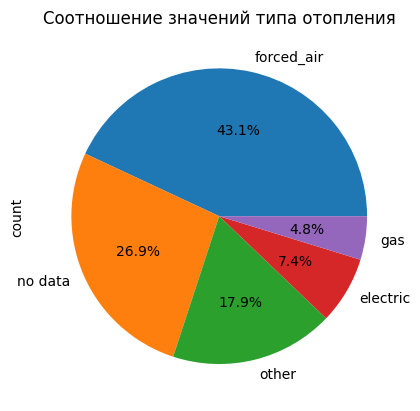

In [155]:
# Визуализируем полученное распределение значений в признаке
heating_type = data['Heating'].value_counts()
heating_type.plot(y='Heating', kind='pie', title='Соотношение значений типа отопления', autopct='%1.1f%%');

### Признак 'Cooling' 

In [157]:
data['Cooling'].value_counts().head(60)

Cooling
Central                                                        156578
                                                                89471
Central Air                                                     14383
No Data                                                         10397
Has Cooling                                                      9729
None                                                             7019
Central Electric                                                 6154
Wall                                                             3922
Central Gas                                                      3573
Central Heating                                                  2807
Cooling System                                                   2694
Central A/C                                                      2051
Other                                                            1789
Central A/C (Electric), Central Heat (Gas)                       1646
Central A/C 

In [158]:
# Заполняем все пропуски записью 'No Data'
data['Cooling'] = data['Cooling'].apply(lambda x: 'No Data' if x == '' else x)
data['Cooling'] = data['Cooling'].fillna('No Data')
# Приводим записи к нижнему регистру
data['Cooling'] = data['Cooling'].apply(lambda x: x.lower())

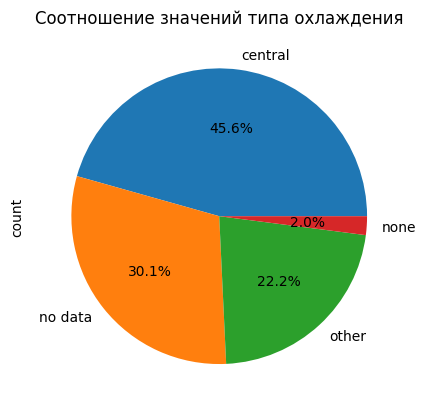

In [159]:
data['Cooling'] = data['Cooling'].apply(lambda x: 
    x if x == 'central' or x == 'no data' or x == 'none'
    else 'other'
)

# Визуализируем полученное распределение значений в признаке
cooling_type = data['Cooling'].value_counts()
cooling_type.plot(y='Cooling', kind='pie', title='Соотношение значений типа охлаждения', autopct='%1.1f%%');

Пропуски заполнять пока не будем.

### Признак 'Parking' 

In [160]:
data['Parking'].value_counts().head(60)

Parking
                                             141380
Attached Garage                               69722
2 spaces                                      27867
1 space                                       14104
No Data                                       13029
Detached Garage                               12843
Carport                                        7506
3 spaces                                       4704
Off Street                                     3533
1                                              2900
4 spaces                                       2899
2                                              2722
Carport, Attached Garage                       2684
None                                           2303
Off street                                     1637
Attached Garage, Detached Garage               1285
On Street                                      1230
0                                              1114
Parking Desc                                    900
Atta

Выделим дома с гаражами и дома без гаражей.

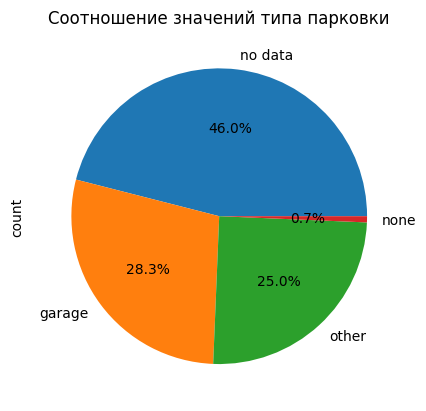

In [161]:
# Заполняем пропущенные значения
data['Parking'] = data['Parking'].apply(lambda x: 'No Data' if x == '' else x)
data['Parking'] = data['Parking'].fillna('No Data')
# Приводим всё к нижнему регистру
data['Parking'] = data['Parking'].apply(lambda x: x.lower())

# Выделяем записи со словом garage и заносим их в список
garage = find_string('garage', data['Parking'])
        
# Меняем записи в признаке на garage, no data и other
data['Parking'] = data['Parking'].apply(lambda x:
    'garage' if x in garage
    else x if x == 'no data' or x == 'none'
    else 'other'
)

# Визуализируем распределение записей
parking_type = data['Parking'].value_counts()
parking_type.plot(y='Parking', kind='pie', title='Соотношение значений типа парковки', autopct='%1.1f%%');

Заполнять пропуски пока не будем.

### Признак 'lotsize' 

In [163]:
data['lotsize'].value_counts().tail(60)

lotsize
3,776 sqft         1
9,480 sqft lot     1
2194               1
5.52 Acres         1
393 sqft           1
618552             1
8,367 sqft lot     1
82175              1
9085               1
9842 sqft          1
33185              1
4,396 sqft         1
8,661 sqft         1
5,591 sqft         1
5,716 Sq. Ft.      1
432943             1
13038              1
4,227 sqft         1
7567               1
7373               1
21576              1
4,868 Sq. Ft.      1
880                1
2,076 sqft         1
180 acres lot      1
2,754 sqft         1
29200              1
8,897 Sq. Ft.      1
9,437 Sq. Ft.      1
17514              1
3,517 sqft         1
10,310 sqft        1
2,463 Sq. Ft.      1
4,848 Sq. Ft.      1
39908              1
1,244 sqft         1
3108442            1
1,188 Sq. Ft.      1
2543               1
2,773 Sq. Ft.      1
4,891 sqft         1
11342              1
52965              1
736 Sq. Ft.        1
928                1
5,241 Sq. Ft.      1
336719             1
4,468

В этом столбце данные указаны в разной размерности: часть в кв. футах, а часть в акрах. Переведём всё в кв. футы.

In [164]:
# Заполняем пропуски
data['lotsize'] = data['lotsize'].fillna('No Data')
data['lotsize'] = data['lotsize'].apply(lambda x: 
    'No Data' if x == '' or x == '—' or x == '-- sqft lot'
    else x
)
# Приводим всё к нижнему регистру
data['lotsize'] = data['lotsize'].apply(lambda x: x.lower())
# Избавляемся от запятых в записях
data['lotsize'] = data['lotsize'].str.replace(',', '')

# Переводим акры в кв. футы
data['lotsize'] = data['lotsize'].apply(lambda x:
    round(float(x.split()[0])*43560.039) if ('acres' in x) or ('acre' in x)
    else int(x.split()[0]) if ('sqft' in x) or ('sq. ft.' in x)
    else x         
)
# Приводим все значения в столбце к числовому формату
data['lotsize'] = data['lotsize'].apply(lambda x:
    np.nan if x == 'no data'
    else int(x)       
)
# Заменяем отрицательное значение в строке 268444 положительным
data.loc[268130, 'lotsize'] = 1742

# Смотрим на статистические показатели признака
data['lotsize'].describe()

count    2.489260e+05
mean     9.612254e+04
std      6.408186e+06
min      0.000000e+00
25%      5.001000e+03
50%      7.832000e+03
75%      1.263200e+04
max      2.147486e+09
Name: lotsize, dtype: float64

Здесь тоже пока оставим пропуски.

### Признак 'fireplace'

Признак содержит 73% пропусков. Удалим его.

In [166]:
data = data.drop('fireplace', axis = 1)

### Признак 'schools'

Посмотрим на характер записи в ячейке

In [167]:
for i in np.arange(10):
    print(data['schools'][i])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]
[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]
[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Brentwood Science School', 'Palisades Charter High School']}]
[{'rating': ['9/10', '9/10', '10/10', '9/10

Записи аналогичны тем, что были в признаке 'homeFacts'. Это список словарей.

In [168]:
for i in np.arange(10):
    print(list(eval(data['schools'][i]))[0].keys())

dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])
dict_keys(['rating', 'data', 'name'])


Итак, в списке всего три словаря с ключами 'rating', 'data', 'name'

In [169]:
for i in np.arange(10):
    print(eval(data['schools'][i])[0]['rating'])

['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
['4/10', 'None/10', '4/10']
['8/10', '4/10', '8/10']
['9/10', '9/10', '10/10', '9/10']
[]
['3', '3', '1', 'NR']
['4', '2', '2']
['2', '2', '4', '7', '4', 'NR']
['4/10', '3/10', '2/10']
['2/10', '8/10', '10/10']


В словарях с ключами rating находятся рейтинги близлежащих школ по дестибальной системе.

In [170]:
for i in np.arange(10):
    print(eval(data['schools'][i])[0]['data'])

{'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}
{'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}
{'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}
{'Distance': ['1.05mi', '0.1mi', '1.05mi', '0.81mi'], 'Grades': ['5-6', 'PK-4', '7-8', '9-12']}
{'Distance': [], 'Grades': []}
{'Distance': ['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi'], 'Grades': ['Preschool to 4', 'Preschool to 12', '5 to 8', '1 to 12']}
{'Distance': ['0.7 mi', '0.4 mi', '2.2 mi'], 'Grades': ['Preschool to 5', '6 to 8', '9 to 12']}
{'Distance': ['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 mi', '6.8 mi'], 'Grades': ['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']}
{'Distance': ['0.7 mi', '0.6 mi', '1.9 mi'], 'Grades': ['PK-5', '5-8', '9-12']}
{'Distance': ['0.3mi', '1.88mi', '2.37mi'], 'Grades': ['9-12', '6-8', 'PK-5']}


В словарях с ключами data находятся ещё два словаря: в одном указываются расстояния до школ, а в другом образовательный уровень гколы.

In [171]:
for i in np.arange(10):
    print(eval(data['schools'][i])[0]['name'])

['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']
['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']
['Paul Revere Middle School', 'Brentwood Science School', 'Palisades Charter High School']
['Mcculloch Intermediate School', 'Bradfield Elementary School', 'Highland Park Middle School', 'Highland Park High School']
[]
['Palmetto Elementary School', 'Haines City Senior High School', 'Lake Marion Creek Elementary School', 'Chosen Generation Christian Academy']
['Crump Elementary School', 'Hickory Ridge Middle School', 'Wooddale High School']
['Roosevelt Elementary School', 'Lincoln Intermediate School', 'Mason City High School', 'Jefferson Elementary School', 'John Adams Middle School', 'Alternative School']
['Edgewood Elementary School', 'Landrum M

В словарях с ключами name указываются названия школ.

Являются ли эти признаки значимыми для определения стоимости дома? На наш взгляд, значимыми признаками, оказывающими влияние на стоимость недвижимости, будут:
* количество школ в близлежащей округе,
* расстояние до ближайшей школы,
* рейтинг школы (мы будем брать школу с максимальным оейтингом).

Выделим эти признаки из записей в столбце.

Вначале выделим признак 'Schools_number'

In [172]:
# Считаем длину списков во вложенных словарях с ключом 'rating'
# и заполняем полученными значениями признак 'Schools_number'
data['Schools_number'] = data['schools'].apply(lambda x: len(eval(x)[0]['rating']))

# Смотрим на статистические показатели нового признака
display(data['Schools_number'].describe())
# Смотрим, есть ли пропуски в новом признаке
data['Schools_number'].isnull().sum()

count    343145.000000
mean          4.202072
std           4.515228
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          65.000000
Name: Schools_number, dtype: float64

0

Пропусков в новом признаке нет.

Теперь введём новый признак 'Best_school_rating'

In [173]:
# Переопределим индексы
data = data.reset_index()
data = data.drop('index', axis = 1)

# Перебираем строки дата-сета
for k in np.arange(0, len(data)):
    # Вводим пустое множество
    temp = set()
    # Перебираем списки в словаре под ключом 'rating'
    for i in np.arange(0, len(eval(data['schools'][k])[0]['rating'])):
        # Каждый элемент списка делим по '/' и заносим первый элемент во множество
        temp.add(eval(data['schools'][k])[0]['rating'][i].split('/')[0])
    # Удаляем из множества запсиси 'None' и 'NR'
    if 'None' in temp:
        temp.remove('None')
    elif 'NR' in temp:
        temp.remove('NR')
    else:
        None

    # В новый столбец заносим максимальное значение из множества,
    # а если множество оказалось пустым, то вносим 0
    if len(temp) == 0:
        data.loc[k, 'Best_school_rating'] = 0
    else:
        data.loc[k, 'Best_school_rating'] = max(temp)
        
# Смотрим на новый признак
data['Best_school_rating'].value_counts()

Best_school_rating
7     60610
8     53455
6     52747
9     51181
5     39807
4     39315
3     24966
2     11151
NA     4231
0      3222
1      1825
10      555
         80
Name: count, dtype: int64

Как видим, пропусков получилось немного. Унифицируем записи в пропущенных значениях. Пропуски пока заполнять не будем.

In [174]:
data['Best_school_rating'] = data['Best_school_rating'].apply(
    lambda x: 'no data' if x == 'NA' or x == '' else x
    )

data['Best_school_rating'].value_counts()

Best_school_rating
7          60610
8          53455
6          52747
9          51181
5          39807
4          39315
3          24966
2          11151
no data     4311
0           3222
1           1825
10           555
Name: count, dtype: int64

Введём признак 'School_distance'.

In [175]:
# Перебираем строки дата-сета
for k in np.arange(0, len(data)):
    # Вводим пустое множество
    temp = set()
    # Перебираем списки в словаре под ключом 'data',
    # а в них списки под ключом 'Distance'
    for i in np.arange(0, len(eval(data['schools'][k])[0]['data']['Distance'])):
        # Каждый элемент списка очищаем от приписки 'mi' и удаляем пробелы
        # Заносим очищенный элемент во множество
        temp.add(eval(data['schools'][k])[0]['data']['Distance'][i].replace('mi', '').strip())
    # Удаляем из множества запсиси 'None', если они есть
    if 'None' in temp:
        temp.remove('None')
    else:
        None

    # В новый столбец заносим минимальное значение из множества,
    # а если множество оказалось пустым, то вносим 0
    if len(temp) == 0:
        data.loc[k, 'School_distance'] = 0
    else:
        data.loc[k, 'School_distance'] = min(temp)
        
# Приводим записи в новом столбце к числовому формату
data['School_distance'] = data['School_distance'].astype(float)
# Смотрим на статистическую характеристику признака
data['School_distance'].describe()

count    343145.000000
mean          1.299686
std           5.866051
min           0.000000
25%           0.320000
50%           0.610000
75%           1.200000
max        1590.380000
Name: School_distance, dtype: float64

Теперь признак 'schools' можно удалить.

In [176]:
data = data.drop('schools', axis = 1)

### Признак 'beds'

Посмотрим на этот признак.

In [178]:
data['beds'].value_counts().head(60)

beds
3 Beds         52022
4 Beds         34743
3              31195
2 Beds         25482
4              19916
2              15997
Baths          15273
3 bd           12680
5 Beds         11090
4 bd            8194
3.0             8081
5               6392
4.0             5231
2 bd            5163
1               4582
6 Beds          3714
5 bd            2619
2.0             2426
6               1792
5.0             1371
0               1171
7 Beds          1077
1 bd            1066
-- bd            845
8 Beds           740
Bath             736
6 bd             643
7                509
1.0              428
                 347
9 Beds           339
8                315
6.0              311
10 Beds          172
7 bd             145
12 Beds          129
9                 94
-- sqft           94
8 bd              94
5,000 sqft        90
0.0               84
11 Beds           83
7.0               67
10                66
1 acre            46
16 Beds           41
8.0               41
0.34 acr

Обращает на себя внимание крайне неупорядоченный характер записей в признаке. Здесь, в частности, встречаются записи с указанием акров и кв. футов, а также записи о ванных комнатах. Создаётся впечатление, что данные были либо некорректно записаны, либо некорректно прочитаны. В любом случае, данный признак нужно удалять. 

In [179]:
data = data.drop('beds', axis = 1)

### Признак 'stories'

В этом признаке очень много пропусков (40%). Удаляем его.

In [180]:
data = data.drop('stories', axis = 1)

### Обработка полученных признаков.

Ещё раз посмотрим на пропуски в данных.

In [181]:
data.isnull().sum()

status                         0
propertyType                   0
street                         0
baths                      79766
city                           9
sqft                           0
zipcode                        0
state                          0
target                         0
Private pool                   0
QualityOfLifeTotalScore     4518
QualityOfLifeEconomy        4518
Med_home_value              2816
Year built                     0
Remodeled year                 0
Heating                        0
Cooling                        0
Parking                        0
lotsize                    94219
Schools_number                 0
Best_school_rating             0
School_distance                0
dtype: int64

Посмотрим на пропуски в признаках QualityOfLifeTotalScore и QualityOfLifeEconomy

In [182]:
data[np.isnan(data['QualityOfLifeTotalScore'])]['state'].value_counts()

state
DC    4514
Fl       1
BA       1
OT       1
OS       1
Name: count, dtype: int64

Пропущены значения в данных со штатами, обозначенными как DC, Fl, BA, OT, OS. 

In [183]:
data[(data['state'] == 'Fl') | (data['state'] == 'BA') | (data['state'] == 'OT') | (data['state'] == 'OS')]

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Private pool,...,Med_home_value,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Schools_number,Best_school_rating,School_distance
103453,active,unknown,9543 W Mcnab #201,NaN,Tamarac,1140.0,33321,Fl,174000,0,...,136600.0,1991,1991,no data,no data,no data,NaN,3,7,0.8
156751,active,unknown,"Mar Grande SE Quadra A, Lotes 9,10, 11 & 12",NaN,,7728.0,33179,BA,225000,0,...,135200.0,1900,0,no data,no data,no data,NaN,0,0,0.0
176084,active,unknown,55 E 1476 Land W,NaN,Other,0.0,11210,OT,50000,0,...,489600.0,0,0,no data,no data,no data,NaN,0,0,0.0
280347,active,unknown,435 pescador,NaN,Foreign Country,1100.0,00000,OS,125000,0,...,NaN,1972,0,no data,no data,no data,NaN,0,0,0.0


Итак, Fl - это Флорида, а остальные - иностранные государства. Иностранные государства удалим, а Флориду исправим.

In [184]:
data.loc[103453, 'QualityOfLifeTotalScore'] = 58.07
data.loc[103453, 'QualityOfLifeEconomy'] = 6
data = data[(data['state'] != 'BA') & (data['state'] != 'OT') & (data['state'] != 'OS')]

DC - это округ Колумбия. На сайте https://www.usnews.com/news/healthiest-communities/district-of-columbia/district-of-columbia нам удалось найти сведения по этому округу. Внесём их в наш дата-сет.

In [185]:
data['QualityOfLifeTotalScore'] = data['QualityOfLifeTotalScore'].fillna(59)
data['QualityOfLifeEconomy'] = data['QualityOfLifeEconomy'].fillna(77)

Проверим, все ли пропуски удалены.

In [186]:
print(data['QualityOfLifeTotalScore'].isnull().sum())
print(data['QualityOfLifeEconomy'].isnull().sum())

0
0


Признак 'Year built' заменим на 'Home_age'.

In [187]:
data['Home_age'] = 2024 - data['Year built']
data.head(5)

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Private pool,...,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Schools_number,Best_school_rating,School_distance,Home_age
0,active,single_family,240 Heather Ln,3.5,Southern Pines,2900.0,28387,NC,418000,0,...,2019,0,other,no data,no data,NaN,8,7,10.50,5
1,for sale,single_family,12911 E Heroy Ave,3.0,Spokane Valley,1947.0,99216,WA,310000,0,...,2019,0,no data,no data,no data,5828.0,3,4,1.01,5
2,for sale,single_family,2005 Westridge Rd,2.0,Los Angeles,3000.0,90049,CA,2895000,1,...,1961,1967,forced_air,central,garage,8626.0,3,8,1.19,63
3,for sale,single_family,4311 Livingston Ave,8.0,Dallas,6457.0,75205,TX,2395000,0,...,2006,2006,forced_air,central,garage,8220.0,4,9,0.10,18
4,for sale,townhouse,1624 S Newkirk St,NaN,Philadelphia,897.0,19145,PA,209000,0,...,1920,0,forced_air,central,no data,680.0,0,0,0.00,104


Удалим признак 'Year built', а значения в новом признаке, равные 2024, заменим на пропуски.

In [188]:
data = data.drop('Year built', axis = 1)
data['Home_age'] = data['Home_age'].apply(lambda x: np.nan if x == 2024 else x)
data['Home_age'].isnull().sum()

36277

Точно так же поступим и с признаком Remodeled year, потому если ремонт был выполнен недавно, это может увеличить стоимость недвижимости, так как покупатели ценят обновлённое жильё. Однако, если ремонт был сделан давно, это может не оказать значительного влияния на стоимость, особенно если использовались устаревшие технологии или материалы.

In [189]:
data['Years_since_remodeling'] = 2024 - data['Remodeled year']
data = data.drop('Remodeled year', axis = 1)
# Если в признаке Remodeled year сведения отсутствовали, заменим значения в новом признаке нулями(ремонт отсутствовал)
data['Years_since_remodeling'] = data['Years_since_remodeling'].apply(lambda x: 0 if x == 2024 else x)
data.head(5)

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Private pool,...,Med_home_value,Heating,Cooling,Parking,lotsize,Schools_number,Best_school_rating,School_distance,Home_age,Years_since_remodeling
0,active,single_family,240 Heather Ln,3.5,Southern Pines,2900.0,28387,NC,418000,0,...,226300.0,other,no data,no data,NaN,8,7,10.50,5.0,0
1,for sale,single_family,12911 E Heroy Ave,3.0,Spokane Valley,1947.0,99216,WA,310000,0,...,185700.0,no data,no data,no data,5828.0,3,4,1.01,5.0,0
2,for sale,single_family,2005 Westridge Rd,2.0,Los Angeles,3000.0,90049,CA,2895000,1,...,1000000.0,forced_air,central,garage,8626.0,3,8,1.19,63.0,57
3,for sale,single_family,4311 Livingston Ave,8.0,Dallas,6457.0,75205,TX,2395000,0,...,931800.0,forced_air,central,garage,8220.0,4,9,0.10,18.0,18
4,for sale,townhouse,1624 S Newkirk St,NaN,Philadelphia,897.0,19145,PA,209000,0,...,152100.0,forced_air,central,no data,680.0,0,0,0.00,104.0,0


В остальных признаках, где есть записи 'no data', заменим их пропусками.

In [190]:
data['Heating'] = data['Heating'].apply(lambda x: np.nan if x == 'no data' else x)
data['Cooling'] = data['Cooling'].apply(lambda x: np.nan if x == 'no data' else x)
data['Parking'] = data['Parking'].apply(lambda x: np.nan if x == 'no data' else x)
data['Best_school_rating'] = data['Best_school_rating'].apply(lambda x: np.nan if x == 'no data' else x)
data['sqft'] = data['sqft'].apply(lambda x: np.nan if x == 0 else x)
data['status'] = data['status'].apply(lambda x: np.nan if x == 'unknown' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: np.nan if x == 'unknown' else x)
# Записи в столбце Best_school_rating приведём к числовому формату
data['Best_school_rating'] = data['Best_school_rating'].apply(lambda x: int(x) if type(x) == str else x)

## <center> 3. Разведывательный анализ данных и заполнение пропусков.

### Признак 'Med_home_value'

Вначале заполним пропуски в столбце 'Med_home_value'. Сделаем мы это, беря средний показатель медианной стоимости домов в городе. 

In [192]:
# Переопределим индексы
data = data.reset_index().drop('index', axis = 1)

# Сгруппируем таблицу по городам. В значениях - средняя медианная стоимость домов
grouped_home_value = pd.DataFrame(data.groupby(by = 'city')['Med_home_value'].mean())

# Создаём список городов, у которых пропущено значение в столбце 'Med_home_value'
cities_list = data[data['Med_home_value'].isnull()]['city'].unique().tolist()

# Создаём словарь, в который занесём значения средней медианной стоимости домов 
# вгородах из списка cities_list
cities_dict = dict() # пустой словарь

for city in cities_list: # перебираем элементы списка cities_list
    # присваисваем им значения из таблицы grouped_home_value
    cities_dict[city] = grouped_home_value.loc[city]['Med_home_value']

# Организуем цикл:
# Перебираем строки:
for i in np.arange(0, len(data)):
    # Если в строке пропущено значение в столбце 'Med_home_value':
    if np.isnan(data['Med_home_value'].loc[i]):
        # присваиваем ему значение из словаря cities_dict:
        data.loc[i, 'Med_home_value'] = cities_dict[data.loc[i]['city']]
    else:
        None

# Смотрим, сколько осталовь пропусков:
data['Med_home_value'].isnull().sum()

901

Итак, пропуски остались. Заполним их средним значением медианной стоимости домов по штатам.

In [193]:
# Сгруппируем таблицу по штатам. В значениях - средняя медианная стоимость домов
grouped_home_value = pd.DataFrame(data.groupby(by = 'state')['Med_home_value'].mean())

# Создаём список штатов, у которых пропущено значение в столбце 'Med_home_value'
states_list = data[data['Med_home_value'].isnull()]['state'].unique().tolist()

# Создаём словарь, в который занесём значения средней медианной стоимости домов 
# в штатах из списка states_list
states_dict = dict() # пустой словарь

for state in states_list: # перебираем элементы списка states_list
    # присваисваем им значения из таблицы grouped_home_value
    states_dict[state] = grouped_home_value.loc[state]['Med_home_value']

# Организуем цикл:
# Перебираем строки:
for i in np.arange(0, len(data)):
    # Если в строке пропущено значение в столбце 'Med_home_value':
    if np.isnan(data['Med_home_value'].loc[i]):
        # присваиваем ему значение из словаря states_dict:
        data.loc[i, 'Med_home_value'] = states_dict[data.loc[i]['state']]
    else:
        None

# Смотрим, сколько осталовь пропусков:
data['Med_home_value'].isnull().sum()

0

### Признак 'Best_school_rating'

Аналогичным способом удалим пропуски в столбце 'Best_school_rating'. Как нам кажется, разумным было бы предположить, что уровень школ в рамках одного микрорайона, который у нас обозначаются признаком 'zipcode', различается не очень сильно, поэтому заполним пропуски в признаке 'Best_school_rating' средним значением по зип-коду.

In [198]:
# Сгруппируем таблицу по зип-кодам. В значениях - средний лучший рейтинг школ
grouped_school_rating = pd.DataFrame(data.groupby(by = 'zipcode')['Best_school_rating'].mean())

# Создаём список зип-кодов, у которых пропущено значение в столбце 'Best_school_rating'
zipcodes_list = data[data['Best_school_rating'].isnull()]['zipcode'].unique().tolist()

# Создаём словарь, в который занесём значения среднего лучшего рейтинга школ
# в зип-кодах из списка zipcodes_list
zipcodes_dict = dict() # пустой словарь

for zipcode in zipcodes_list: # перебираем элементы списка zipcodes_list
    # присваисваем им значения из таблицы grouped_school_rating
    zipcodes_dict[zipcode] = grouped_school_rating.loc[zipcode]['Best_school_rating']

# Организуем цикл:
# Перебираем строки:
for i in np.arange(0, len(data)):
    # Если в строке пропущено значение в столбце 'Best_school_rating':
    if np.isnan(data['Best_school_rating'].loc[i]):
        # присваиваем ему значение из словаря zipcodes_dict:
        data.loc[i, 'Best_school_rating'] = zipcodes_dict[data.loc[i]['zipcode']]
    else:
        None

# Смотрим, сколько осталовь пропусков:
data['Best_school_rating'].isnull().sum()

161

Пропуски остались. Повторим тот же код, но теперь рассмотрим средние лучшие рейтинги школ по городам.

In [199]:
grouped_school_rating = pd.DataFrame(data.groupby(by = 'city')['Best_school_rating'].mean())

cities_list = data[data['Best_school_rating'].isnull()]['city'].unique().tolist()

cities_dict = dict() 

for city in cities_list: 
    cities_dict[city] = grouped_school_rating.loc[city]['Best_school_rating']

for i in np.arange(0, len(data)):
    if np.isnan(data['Best_school_rating'].loc[i]):
        data.loc[i, 'Best_school_rating'] = cities_dict[data.loc[i]['city']]
    else:
        None

data['Best_school_rating'].isnull().sum()

52

Оставшиеся пропуски заполним средними значениями по штату.

In [200]:
grouped_school_rating = pd.DataFrame(data.groupby(by = 'state')['Best_school_rating'].mean())

states_list = data[data['Best_school_rating'].isnull()]['state'].unique().tolist()

states_dict = dict() 

for state in states_list: 
    states_dict[state] = grouped_school_rating.loc[state]['Best_school_rating']

for i in np.arange(0, len(data)):
    if np.isnan(data['Best_school_rating'].loc[i]):
        data.loc[i, 'Best_school_rating'] = states_dict[data.loc[i]['state']]
    else:
        None

data['Best_school_rating'].isnull().sum()

0

### Признак 'Home_age'

Нам кажется разумным предположить, что средний возраст домов в одном и том же микрорайоне будет примерно одинаков. Как правило, тот или иной город как раз и делят на микрорайоны в соответствии с какими-то общими признаками на данной территории. Поэтому нам кажется разумным заполнить пропуски в признаке 'Home_age' по тому же алгоритму, что был приведён выше.

In [202]:
# Сгруппируем таблицу по зип-кодам. В значениях - средний возраст домов
grouped_home_ages = pd.DataFrame(data.groupby(by = 'zipcode')['Home_age'].mean())

# Создаём список зип-кодов, у которых пропущено значение в столбце 'Home_age'
zipcodes_list = data[data['Home_age'].isnull()]['zipcode'].unique().tolist()

# Создаём словарь, в который занесём значения среднего возраста домов
# в зип-кодах из списка zipcodes_list
zipcodes_dict = dict() # пустой словарь

for zipcode in zipcodes_list: # перебираем элементы списка zipcodes_list
    # присваисваем им значения из таблицы grouped_home_ages
    zipcodes_dict[zipcode] = grouped_home_ages.loc[zipcode]['Home_age']

# Организуем цикл:
# Перебираем строки:
for i in np.arange(0, len(data)):
    # Если в строке пропущено значение в столбце 'Home_age':
    if np.isnan(data['Home_age'].loc[i]):
        # присваиваем ему значение из словаря zipcodes_dict:
        data.loc[i, 'Home_age'] = zipcodes_dict[data.loc[i]['zipcode']]
    else:
        None

# Смотрим, сколько осталовь пропусков:
data['Home_age'].isnull().sum()

104

Пропуски остались. Заполним их средним значением по городам.

In [203]:
grouped_home_ages = pd.DataFrame(data.groupby(by = 'city')['Home_age'].mean())

cities_list = data[data['Home_age'].isnull()]['city'].unique().tolist()

cities_dict = dict() 

for city in cities_list: 
    cities_dict[city] = grouped_home_ages.loc[city]['Home_age']

for i in np.arange(0, len(data)):
    if np.isnan(data['Home_age'].loc[i]):
        data.loc[i, 'Home_age'] = cities_dict[data.loc[i]['city']]
    else:
        None

data['Home_age'].isnull().sum()

46

Оставшиеся пропуски заполним средним значением по штатам.

In [204]:
grouped_home_ages = pd.DataFrame(data.groupby(by = 'state')['Home_age'].mean())

states_list = data[data['Home_age'].isnull()]['state'].unique().tolist()

states_dict = dict() 

for state in states_list: 
    states_dict[state] = grouped_home_ages.loc[state]['Home_age']

for i in np.arange(0, len(data)):
    if np.isnan(data['Home_age'].loc[i]):
        data.loc[i, 'Home_age'] = states_dict[data.loc[i]['state']]
    else:
        None

data['Home_age'].isnull().sum()

0

Пропуски в столбце удалены. Теперь все столбцы, связанные с географическим положением, можно удалить.

In [206]:
data = data.drop(['street', 'city', 'zipcode', 'state'], axis = 1)
data

,status,propertyType,baths,sqft,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Heating,Cooling,Parking,lotsize,Schools_number,Best_school_rating,School_distance,Home_age,Years_since_remodeling
0,active,single_family,3.5,2900.0,418000,0,51.51,17.0,226300.0,other,NaN,NaN,NaN,8,7.000000,10.50,5.000000,0
1,for sale,single_family,3.0,1947.0,310000,0,52.11,4.0,185700.0,NaN,NaN,NaN,5828.0,3,4.000000,1.01,5.000000,0
2,for sale,single_family,2.0,3000.0,2895000,1,52.03,15.0,1000000.0,forced_air,central,garage,8626.0,3,8.000000,1.19,63.000000,57
3,for sale,single_family,8.0,6457.0,2395000,0,49.00,26.0,931800.0,forced_air,central,garage,8220.0,4,9.000000,0.10,18.000000,18
4,for sale,townhouse,NaN,897.0,209000,0,56.42,38.0,152100.0,forced_air,central,NaN,680.0,0,0.000000,0.00,104.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343137,NaN,single_family,6.0,4017.0,1249000,1,58.07,6.0,329600.0,other,central,other,8500.0,2,5.000000,1.10,34.000000,34
343138,for sale,condo,3.0,2000.0,674999,0,55.47,50.0,408900.0,other,NaN,none,NaN,3,7.000000,0.40,100.000000,0
343139,for sale,single_family,3.0,1152.0,528000,0,60.64,37.0,383200.0,other,NaN,other,1600.0,2,5.000000,0.48,74.000000,74
343140,NaN,NaN,NaN,NaN,34500,0,49.00,26.0,61000.0,NaN,NaN,NaN,NaN,3,3.050633,0.50,53.940476,0


Теперь выявим записи, в которых более 4 пропущенных значений.

In [207]:
# Создаём пустой список
temp = []
# Перебираем строки
for i in np.arange(0, len(data)):
    # Если сумма пропусков в строке больше 4
    if data.loc[i].isnull().sum() > 4:
        temp.append(i) # добавляем номер строки в список
    else:
        None
    
# Удаляем строки с номерами из списка из нашего набора данных
data = data.drop(index=temp).reset_index().drop('index', axis = 1)
data

,status,propertyType,baths,sqft,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Heating,Cooling,Parking,lotsize,Schools_number,Best_school_rating,School_distance,Home_age,Years_since_remodeling
0,active,single_family,3.5,2900.0,418000,0,51.51,17.0,226300.0,other,NaN,NaN,NaN,8,7.0,10.50,5.0,0
1,for sale,single_family,3.0,1947.0,310000,0,52.11,4.0,185700.0,NaN,NaN,NaN,5828.0,3,4.0,1.01,5.0,0
2,for sale,single_family,2.0,3000.0,2895000,1,52.03,15.0,1000000.0,forced_air,central,garage,8626.0,3,8.0,1.19,63.0,57
3,for sale,single_family,8.0,6457.0,2395000,0,49.00,26.0,931800.0,forced_air,central,garage,8220.0,4,9.0,0.10,18.0,18
4,for sale,townhouse,NaN,897.0,209000,0,56.42,38.0,152100.0,forced_air,central,NaN,680.0,0,0.0,0.00,104.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314583,for sale,condo,3.0,1417.0,799000,0,59.00,77.0,490600.0,forced_air,central,other,NaN,2,3.0,0.10,14.0,0
314584,NaN,single_family,6.0,4017.0,1249000,1,58.07,6.0,329600.0,other,central,other,8500.0,2,5.0,1.10,34.0,34
314585,for sale,condo,3.0,2000.0,674999,0,55.47,50.0,408900.0,other,NaN,none,NaN,3,7.0,0.40,100.0,0
314586,for sale,single_family,3.0,1152.0,528000,0,60.64,37.0,383200.0,other,NaN,other,1600.0,2,5.0,0.48,74.0,74


Приступим к заполнению других пропусков. Прежде всего, посмотрим на корреляцию пропущенных значений.

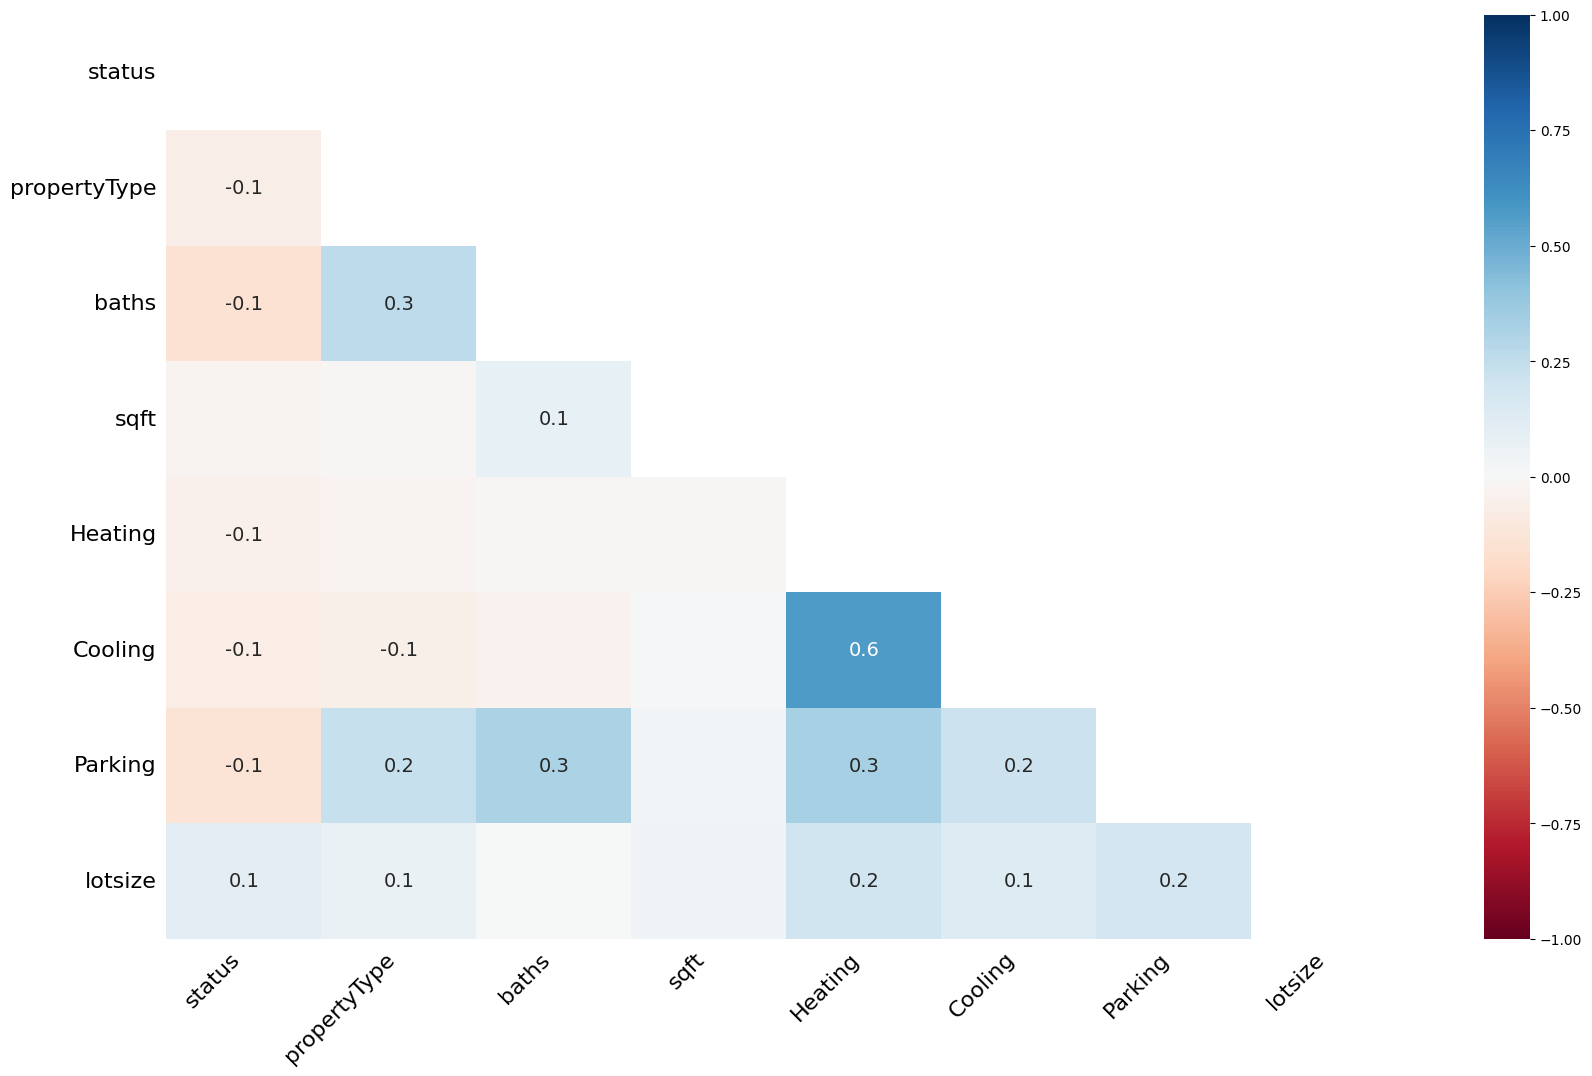

In [208]:
# Составим тепловую карту корреляции пропущенных значений.
msno.heatmap(data);

Как видим, довольно высокая корреляция пропущенных значений есть лишь в признакх 'Heating' и 'Cooling'. То есть, в большинстве случаев, если есть пропуск в одном признаке, то он есть и в другом. Остальные пропуски между собой не связаны.



### Признак 'sqft'

Начнём с признака 'sqft', т. к. там пропусков меньше всего. Посмотрим, на корреляцию этого признака с другими. Для этого создадим временный дата-сет, из которого уберём признаки, явно не влияющие на площадь жилья, а в оставшихся заполним пропуски медианами и модами и закодируем категориальные признаки.

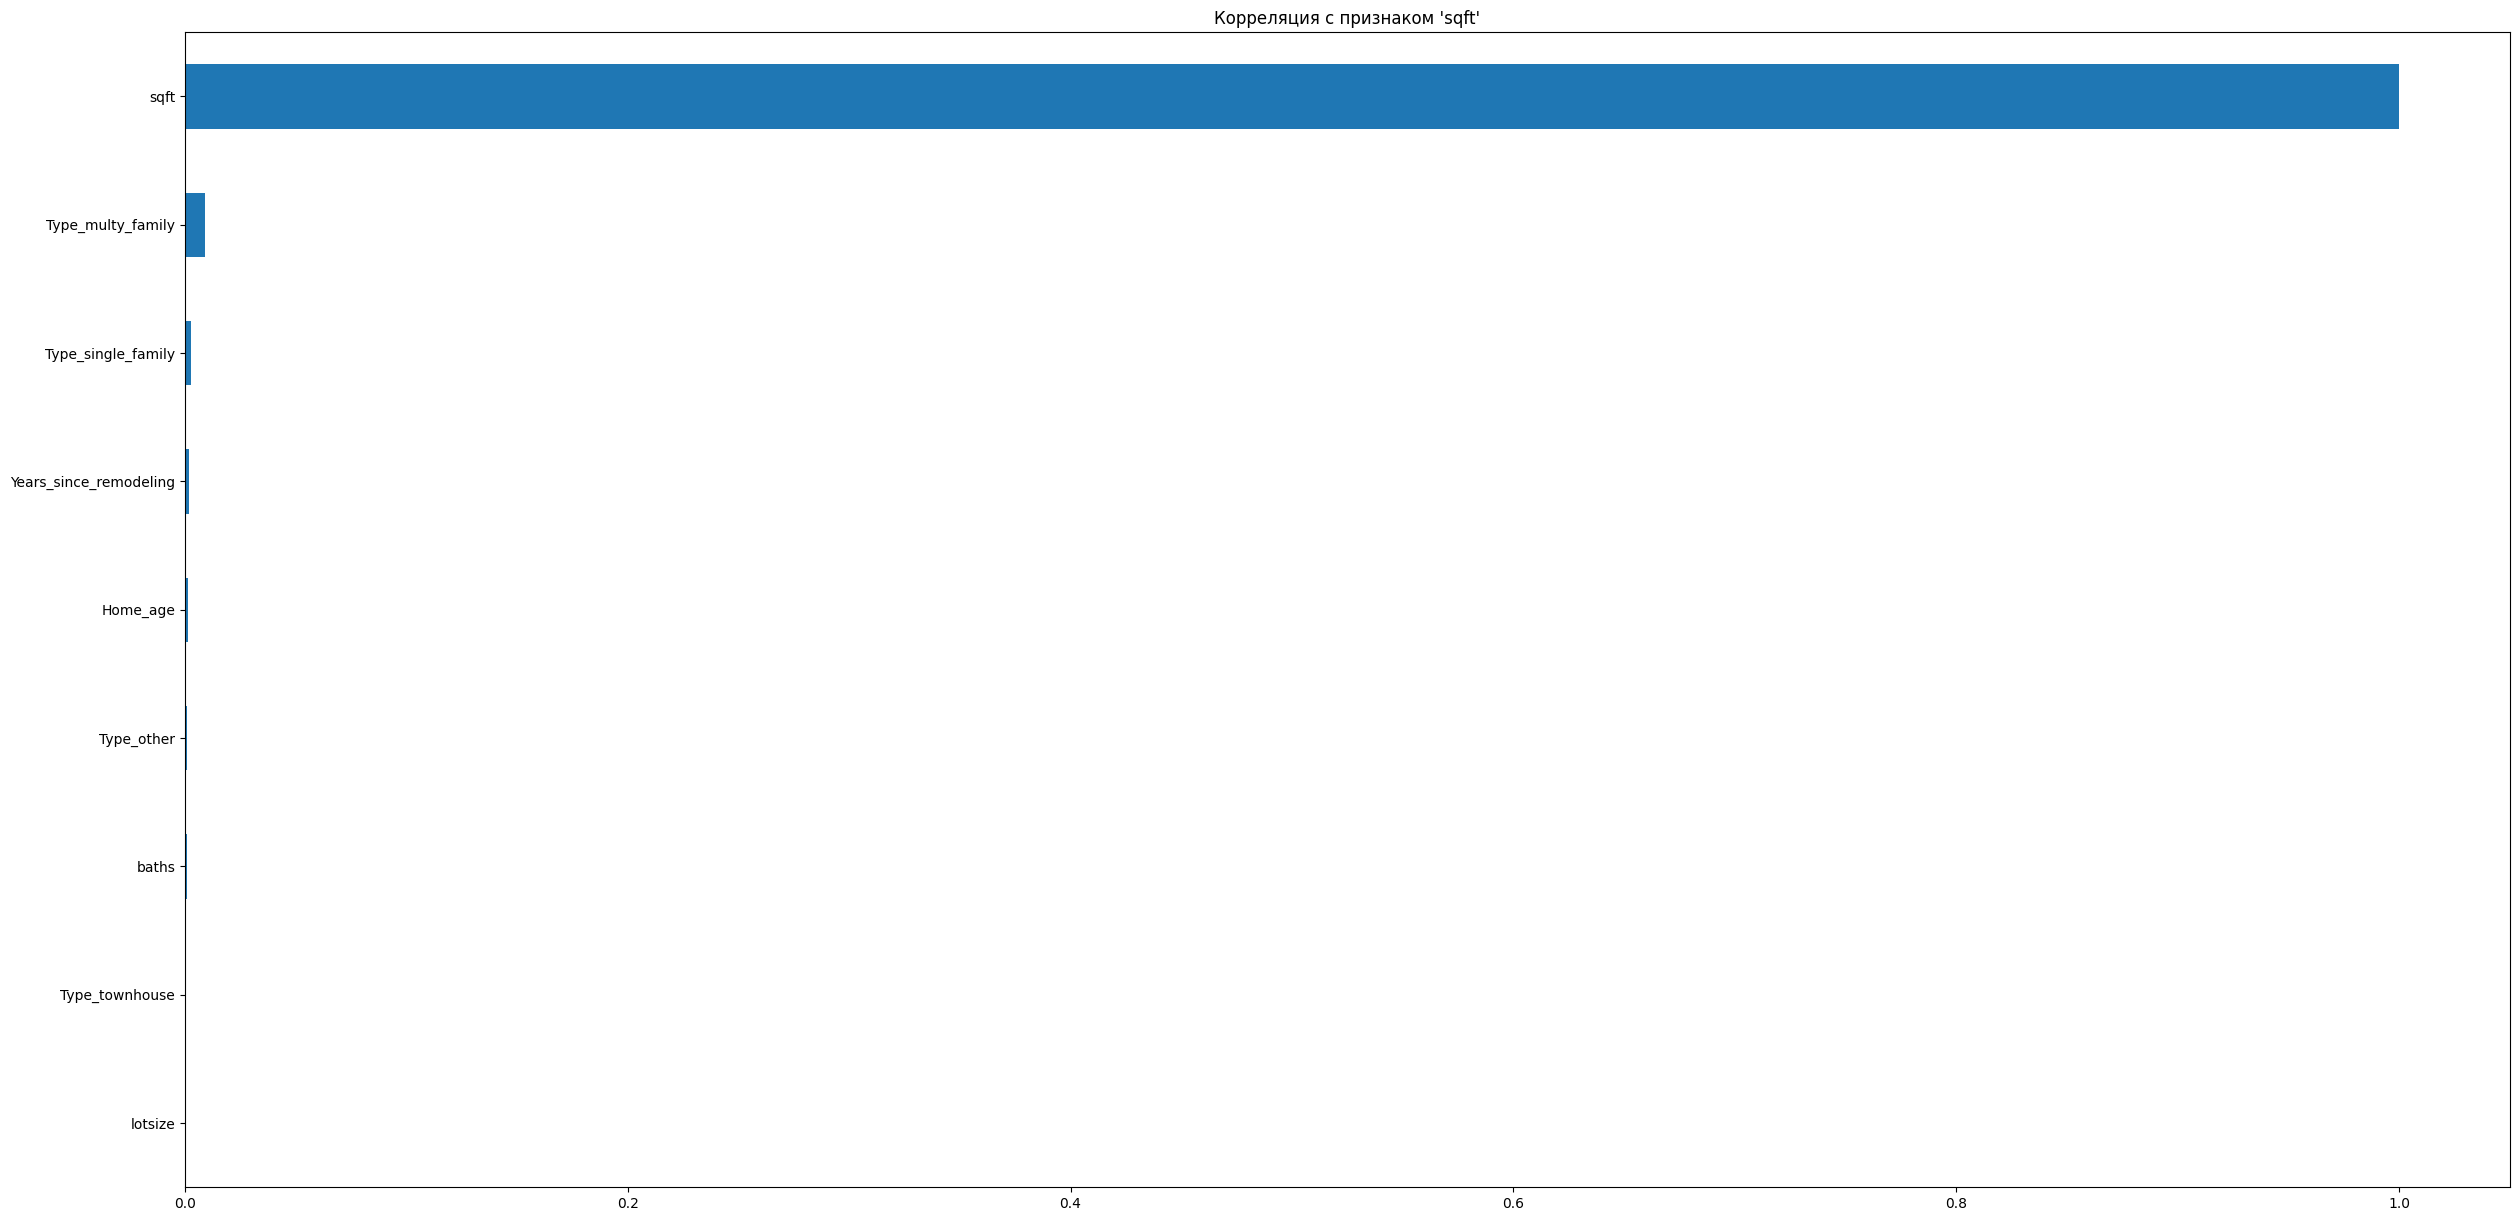

In [209]:
# Создаём временный дата-сет
temp = data[['propertyType', 'baths', 'lotsize', 'Home_age', 'Years_since_remodeling', 'sqft']]
# Пропуски заполняем медианами
temp['baths'] = temp['baths'].fillna(temp['baths'].median())
temp['lotsize'] = temp['lotsize'].fillna(temp['lotsize'].median())
# Удаляем пропуски из признака 'sqft'
temp = temp.dropna(axis = 0)

# Кодируем категориальные признаки
temp = pd.get_dummies(temp, columns = ['propertyType'], prefix='Type', dummy_na=True, drop_first=True, dtype=int)

# Смотрим на корреляцию признака 'sqft' с другими признаками
corr = temp.corr()
fig, ax = plt.subplots(figsize = (30, 15))
corr['sqft'].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh()
plt.title("Корреляция с признаком 'sqft'");

Итак, как видим, признак 'sqft' слабо коррелируется с другими признаками. Посмотрим, как меняется медианная площадь жилья в зависимости от типа дома.

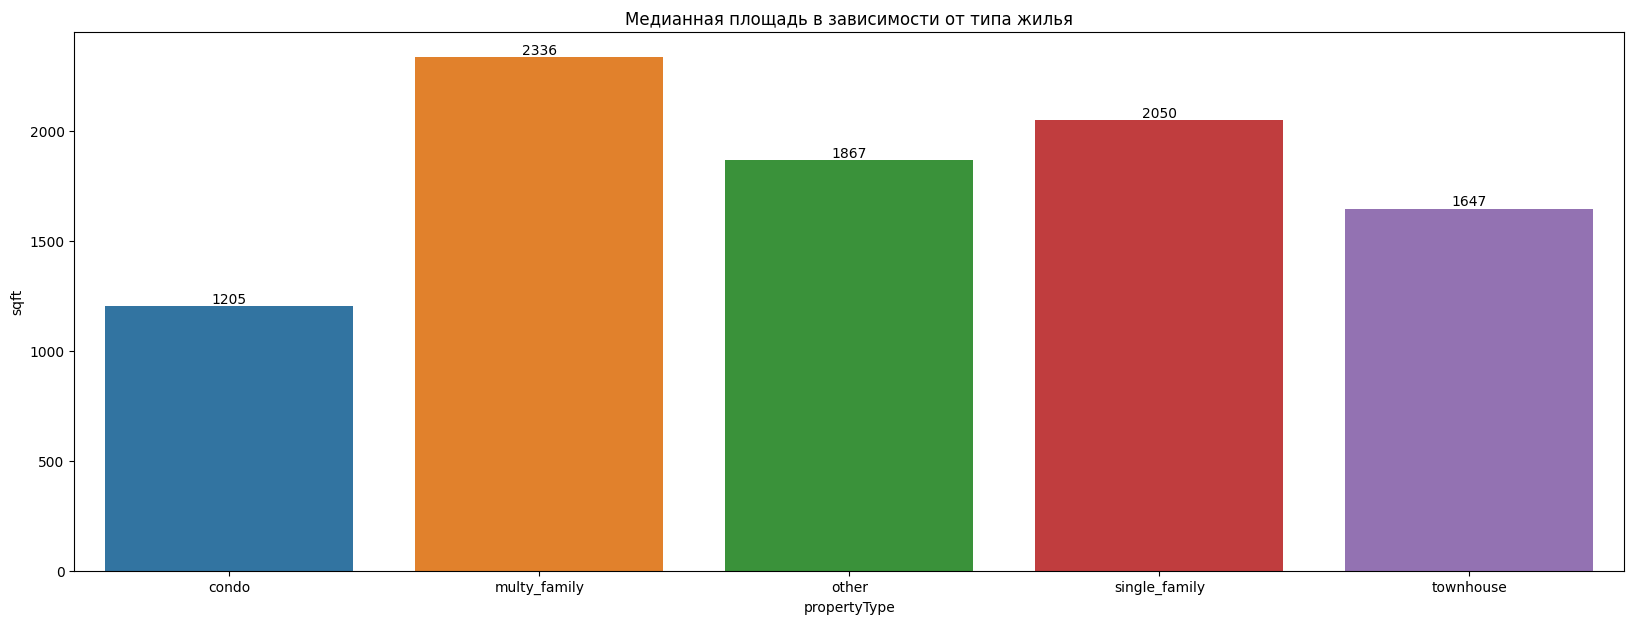

In [210]:
# Группируем медианную площадь жилья по типу собствености.
grouped = pd.DataFrame(data.groupby(by = 'propertyType')['sqft'].median())

# Визуализируем:
fig, axes = plt.subplots(figsize = (20, 7))
ax = sns.barplot(grouped, x = grouped.index, y = 'sqft', ax = axes)
ax.set_title('Медианная площадь в зависимости от типа жилья')
ax.bar_label(ax.containers[0], fontsize=10);

Как видим, зависимость медианной площади жилья от типа дома всё же прослеживается: наибольшими по площади являются многосемейные дома, а наименьшими - кондо. Заполним пропуски в признаке 'sqft', исходя из полученных показателей, т.е. медианным значением по каждому типу собственности.

In [211]:
# Организуем цикл, в котором перебираем индексы таблицы grouped:
for i in np.arange(0, len(grouped.index.to_list())):
    # Временная таблица с пропусками в признаке 'sqft':
    temp = data[data['sqft'].isnull()]
    # Обрезаем временную таблицу по типу собственности и фиксируем индексы:
    temp_list = temp[temp['propertyType'] == grouped.index.to_list()[i]].index.to_list()
    # По полученным индексам заполняем пропуски значениями из таблицы grouped:
    data.loc[temp_list, 'sqft'] = grouped.loc[grouped.index.to_list()[i]]['sqft']

# Проверяем, сколько осталось пропусков:
data['sqft'].isnull().sum()

122

In [212]:
# Оставшиеся пропуски заполним медианой по всему дата-сету:
data['sqft'] = data['sqft'].fillna(data['sqft'].median())

# Проверяем, сколько осталось пропусков:
data['sqft'].isnull().sum()

0

Все пропуски в признаке заполнены.

### Признак 'propertyType'

Опять смотрим на корреляцию данного признака с другими. 

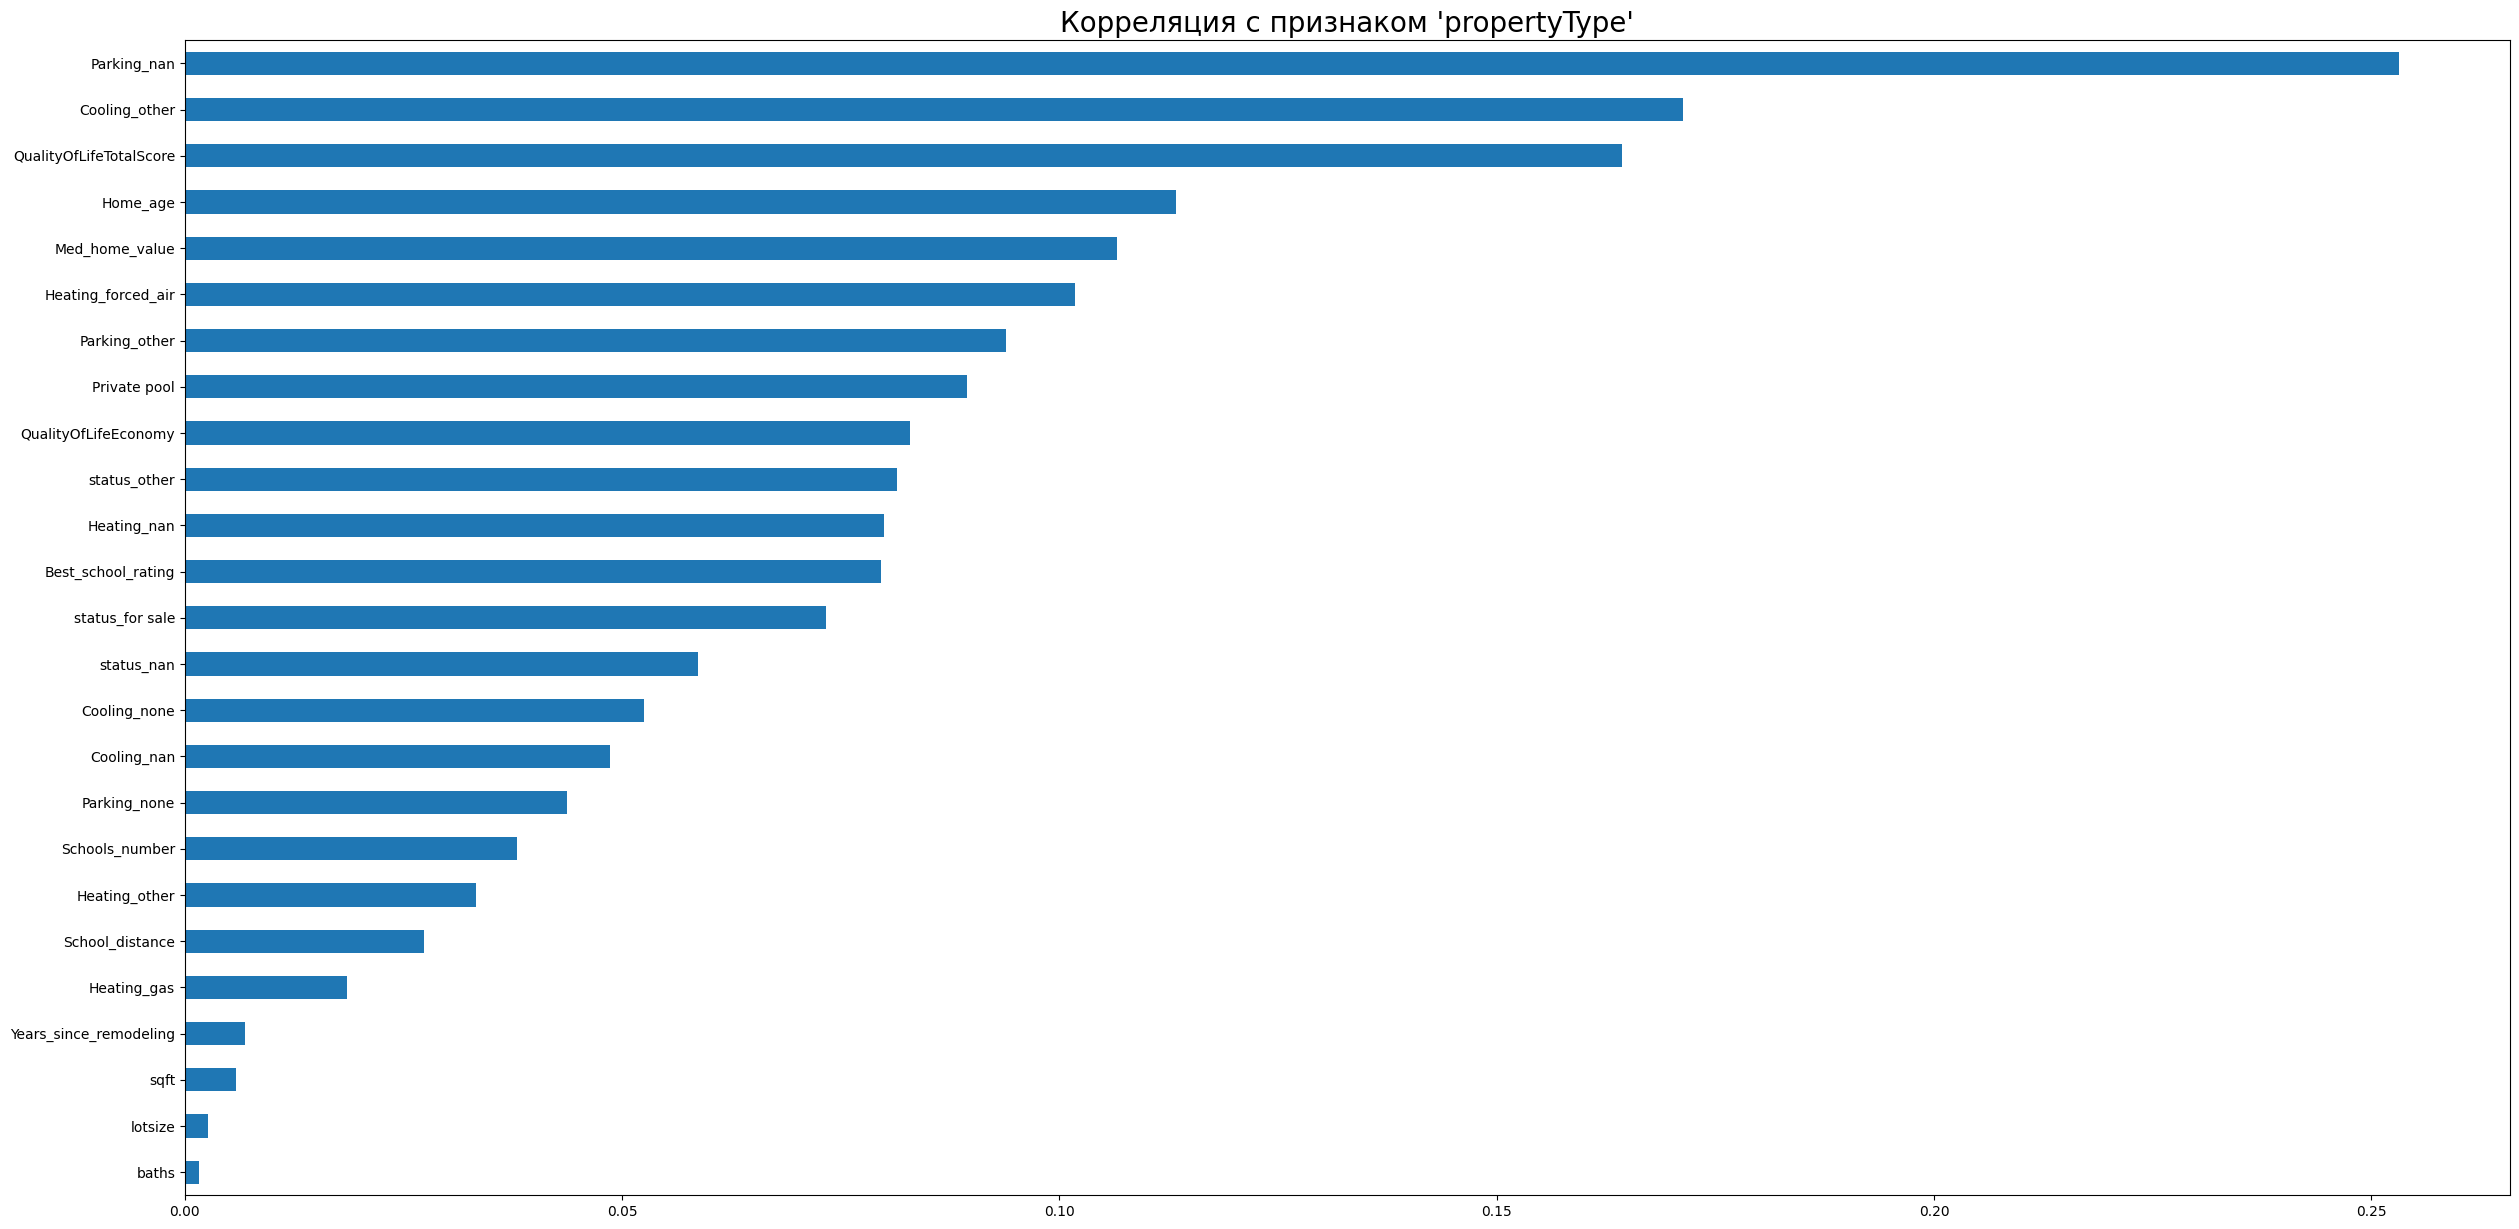

In [214]:
# Создаём временный дата-сет
temp = data.drop('target', axis = 1)
# Пропуски заполняем медианами
temp['baths'] = temp['baths'].fillna(temp['baths'].median())
temp['lotsize'] = temp['lotsize'].fillna(temp['lotsize'].median())
# Удаляем пропуски из признака 'propertyType'
temp = temp[temp['propertyType'].isnull() == False]
# Кодируем этот признак:
temp['propertyType'] = temp['propertyType'].apply(lambda x:
    4 if x == 'single_family'
    else 3 if x == 'condo'
    else 2 if x == 'other'
    else 1 if x == 'townhouse'
    else 0)

# Кодируем категориальные признаки
temp = pd.get_dummies(temp, columns = ['Parking'], prefix='Parking', dummy_na=True, drop_first=True, dtype=int)
temp = pd.get_dummies(temp, columns = ['status'], prefix='status', dummy_na=True, drop_first=True, dtype=int)
temp = pd.get_dummies(temp, columns = ['Heating'], prefix='Heating', dummy_na=True, drop_first=True, dtype=int)
temp = pd.get_dummies(temp, columns = ['Cooling'], prefix='Cooling', dummy_na=True, drop_first=True, dtype=int)

# Смотрим на корреляцию признака 'sqft' с другими признаками
corr = temp.corr()
fig, ax = plt.subplots(figsize = (30, 15))
corr['propertyType'].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh()
plt.title("Корреляция с признаком 'propertyType'", fontsize = 20);

Корреляция признака с другими довольно слабая. Поручим установить закономерности алгоритмам машинного обучения. Решим задачу классификации, где в качестве целевого признака будет 'propertyType'. 

In [215]:
# Выделяем целевую переменную из временного дата-сета.
temp_y = temp['propertyType']
temp_X = temp.drop('propertyType', axis = 1)

In [216]:
# Делим временный дата-сет на обучающую и валидационную выборки:
temp_X_train, temp_X_valid, temp_y_train, temp_y_valid = train_test_split(
    temp_X, temp_y,
    test_size=0.2,
    random_state=42)

Для построения модели будем использовать CatBoostClassifier, потому что он не требует масштабирования данных. В качестве метрики качества возьмём accuracy, потому что нам важна точность предсказания.

In [217]:
model = CatBoostClassifier(random_state=42, silent=True)

model.fit(temp_X_train, temp_y_train)
metrics.accuracy_score(temp_y_valid, model.predict(temp_X_valid))

0.9080647287588162

Точность модели довольно высокая. Попробуем её улучшить, подобрав гиперпараметры.

In [125]:
def optuna_cbc(trial):
  # задаем пространства поиска гиперпараметров
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
  depth = trial.suggest_int('depth', 2, 10)
  colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.1, 1)
  min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100)
  

  # создаем модель
  model = CatBoostClassifier(learning_rate=learning_rate,
                            depth=depth,
                            colsample_bylevel=colsample_bylevel,
                            min_data_in_leaf=min_data_in_leaf,
                            silent=True,
                            loss_function='MultiClass',
                            random_state=42)
  # обучаем модель
  model.fit(temp_X_train, temp_y_train)
  score = metrics.accuracy_score(temp_y_valid, model.predict(temp_X_valid))

  return score

# cоздаем объект исследования
study_cbc = optuna.create_study(
    study_name="CatBoostClassifier",
    direction="maximize"
    )
# ищем лучшую комбинацию гиперпараметров
study_cbc.optimize(optuna_cbc, n_trials=20)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_cbc.best_params}')

[I 2024-04-19 23:37:56,039] A new study created in memory with name: CatBoostClassifier
[I 2024-04-19 23:43:29,977] Trial 0 finished with value: 0.911570111915734 and parameters: {'learning_rate': 0.06538536551712856, 'depth': 8, 'colsample_bylevel': 0.8369008855218436, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.911570111915734.
[I 2024-04-19 23:45:23,841] Trial 1 finished with value: 0.8554476629361422 and parameters: {'learning_rate': 0.022143093243106513, 'depth': 3, 'colsample_bylevel': 0.7435439849819475, 'min_data_in_leaf': 76}. Best is trial 0 with value: 0.911570111915734.
[I 2024-04-19 23:52:56,305] Trial 2 finished with value: 0.8968729427254772 and parameters: {'learning_rate': 0.015520181050273725, 'depth': 9, 'colsample_bylevel': 0.8724710720055255, 'min_data_in_leaf': 70}. Best is trial 0 with value: 0.911570111915734.
[I 2024-04-19 23:54:59,904] Trial 3 finished with value: 0.8674456879526004 and parameters: {'learning_rate': 0.020639259404962796, 'depth': 4,

Наилучшие значения гиперпараметров: {'learning_rate': 0.08549045338585823, 'depth': 10, 'colsample_bylevel': 0.3546769507463873, 'min_data_in_leaf': 11}


Загрузим в обученную модель стлбец 'propertyType' с пропущенными значениями и сделаем предсказание.

In [218]:
X_test = data[data['propertyType'].isnull()]

X_test['baths'] = X_test['baths'].fillna(temp['baths'].median())
X_test['lotsize'] = X_test['lotsize'].fillna(temp['lotsize'].median())

X_test = pd.get_dummies(X_test, columns = ['Parking'], prefix='Parking', dummy_na=True, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns = ['status'], prefix='status', dummy_na=True, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns = ['Heating'], prefix='Heating', dummy_na=True, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns = ['Cooling'], prefix='Cooling', dummy_na=True, drop_first=True, dtype=int)

In [219]:
X_test

,propertyType,baths,sqft,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,lotsize,Schools_number,...,status_for sale,status_other,status_nan,Heating_forced_air,Heating_gas,Heating_other,Heating_nan,Cooling_none,Cooling_other,Cooling_nan
14,NaN,1.75,2203.0,335000,0,58.07,6.0,138800.0,5304.0,4,...,0,0,0,0,0,0,1,0,0,1
64,NaN,2.50,538.0,650000,0,58.07,6.0,438900.0,7749.0,5,...,0,0,0,1,0,0,0,0,1,0
77,NaN,2.50,667.0,138500,0,58.07,6.0,270300.0,7749.0,7,...,0,0,0,0,0,0,0,0,1,0
110,NaN,2.50,1350.0,102000,0,48.85,21.0,117900.0,43560.0,3,...,0,0,0,0,0,0,0,0,1,0
131,NaN,2.50,1517.0,299999,0,58.07,6.0,153500.0,8786.0,3,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314472,NaN,2.50,1771.0,209900,0,51.51,17.0,131800.0,12197.0,3,...,0,0,0,0,0,0,1,0,1,0
314497,NaN,2.00,1456.0,210000,0,58.07,6.0,178300.0,5445.0,5,...,0,1,0,0,0,1,0,0,1,0
314514,NaN,2.50,1180.0,335000,0,58.07,6.0,335400.0,7749.0,3,...,0,0,0,1,0,0,0,0,1,0
314550,NaN,2.50,842.0,299000,0,58.07,6.0,273000.0,7749.0,5,...,0,0,0,1,0,0,0,0,1,0


In [220]:
y_test = X_test['propertyType']
X_test = X_test.drop('propertyType', axis = 1)

In [222]:
model = CatBoostClassifier(**study_cbc.best_params, 
                        silent=True,
                        loss_function='MultiClass',
                        random_state=42)

model.fit(temp_X_train, temp_y_train)
y_pred = model.predict(X_test)

In [223]:
y_pred

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]], dtype=int64)

В переменной y_pred содержатся предсказания нашей модели для признака 'propertyType'. Нам осталось заполнить этими предсказаниями пропуски в данном признаке в исходном наборе данных.

In [224]:
# Для удобства преобразуем переменную y_test в дата-фрейм:
y_test_df = pd.DataFrame(y_test)
# Заполним столбец 'propertyType' предсказаниями
y_test_df['propertyType'] = y_pred
# Перекодируем значения в таблице y_test_df
y_test_df['propertyType'] = y_test_df['propertyType'].apply(lambda x:
    'single_family' if x == 4
    else 'condo' if x == 3
    else 'other' if x == 2
    else 'townhouse' if x == 1
    else 'multy_family')

# Создадим временный список индексов из таблицы y_test_df:
temp_list = y_test_df.index.to_list()
# Перебираем список с индексами:
for i in np.arange(0, len(y_test_df.index.to_list())):
    # Заполняем пропуски в исходной таблице по полученным индексам:
    data.loc[temp_list[i], 'propertyType'] = y_test_df.loc[temp_list[i]]['propertyType']

# Проверяем, остались ли пропуски в признаке:
data['propertyType'].isnull().sum()

0

Пропусков не осталось. Посмотрим, как распределились значения в признаке 'propertyType'.

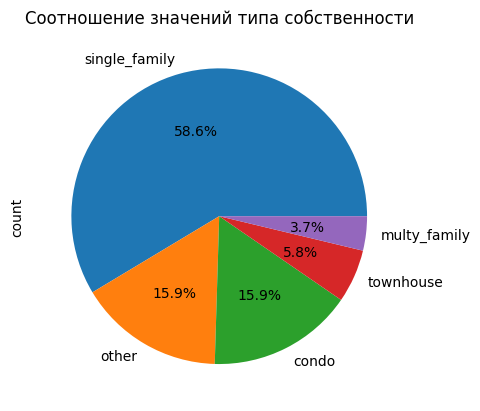

In [225]:
status_type = data['propertyType'].value_counts()
status_type.plot(y='propertyType', kind='pie', title='Соотношение значений типа собственности', autopct='%1.1f%%');

### Признак 'status'

Ксожалению, статус дома никак не связан с другими признаками, мы не можем предугадать, по каким причинам был выставлен на продажу дом. Единственный признак, который, по нашему предположению, зависит от статуса дома, - это его стоимость, т.е. наша целевая переменная, но мы не хотим заполнять признак статуса дома, исходя из признака стоимости, чтобы не подстроить нашу целевую переменную под другие признаки, т.к. это может исказить модель предсказания. Поэтому заполним признак 'status' модой.

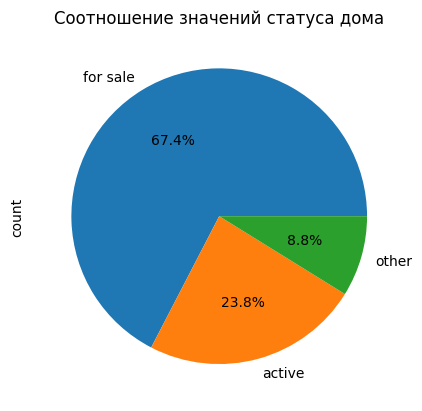

In [226]:
data['status'] = data['status'].fillna('for sale')

status_type = data['status'].value_counts()
status_type.plot(y='status', kind='pie', title='Соотношение значений статуса дома', autopct='%1.1f%%');

### Признак 'baths'

Количество ванных комнаят может зависеть от типа дома, его площади, года постройки или реконструкции. Посмотрим, так ли это.

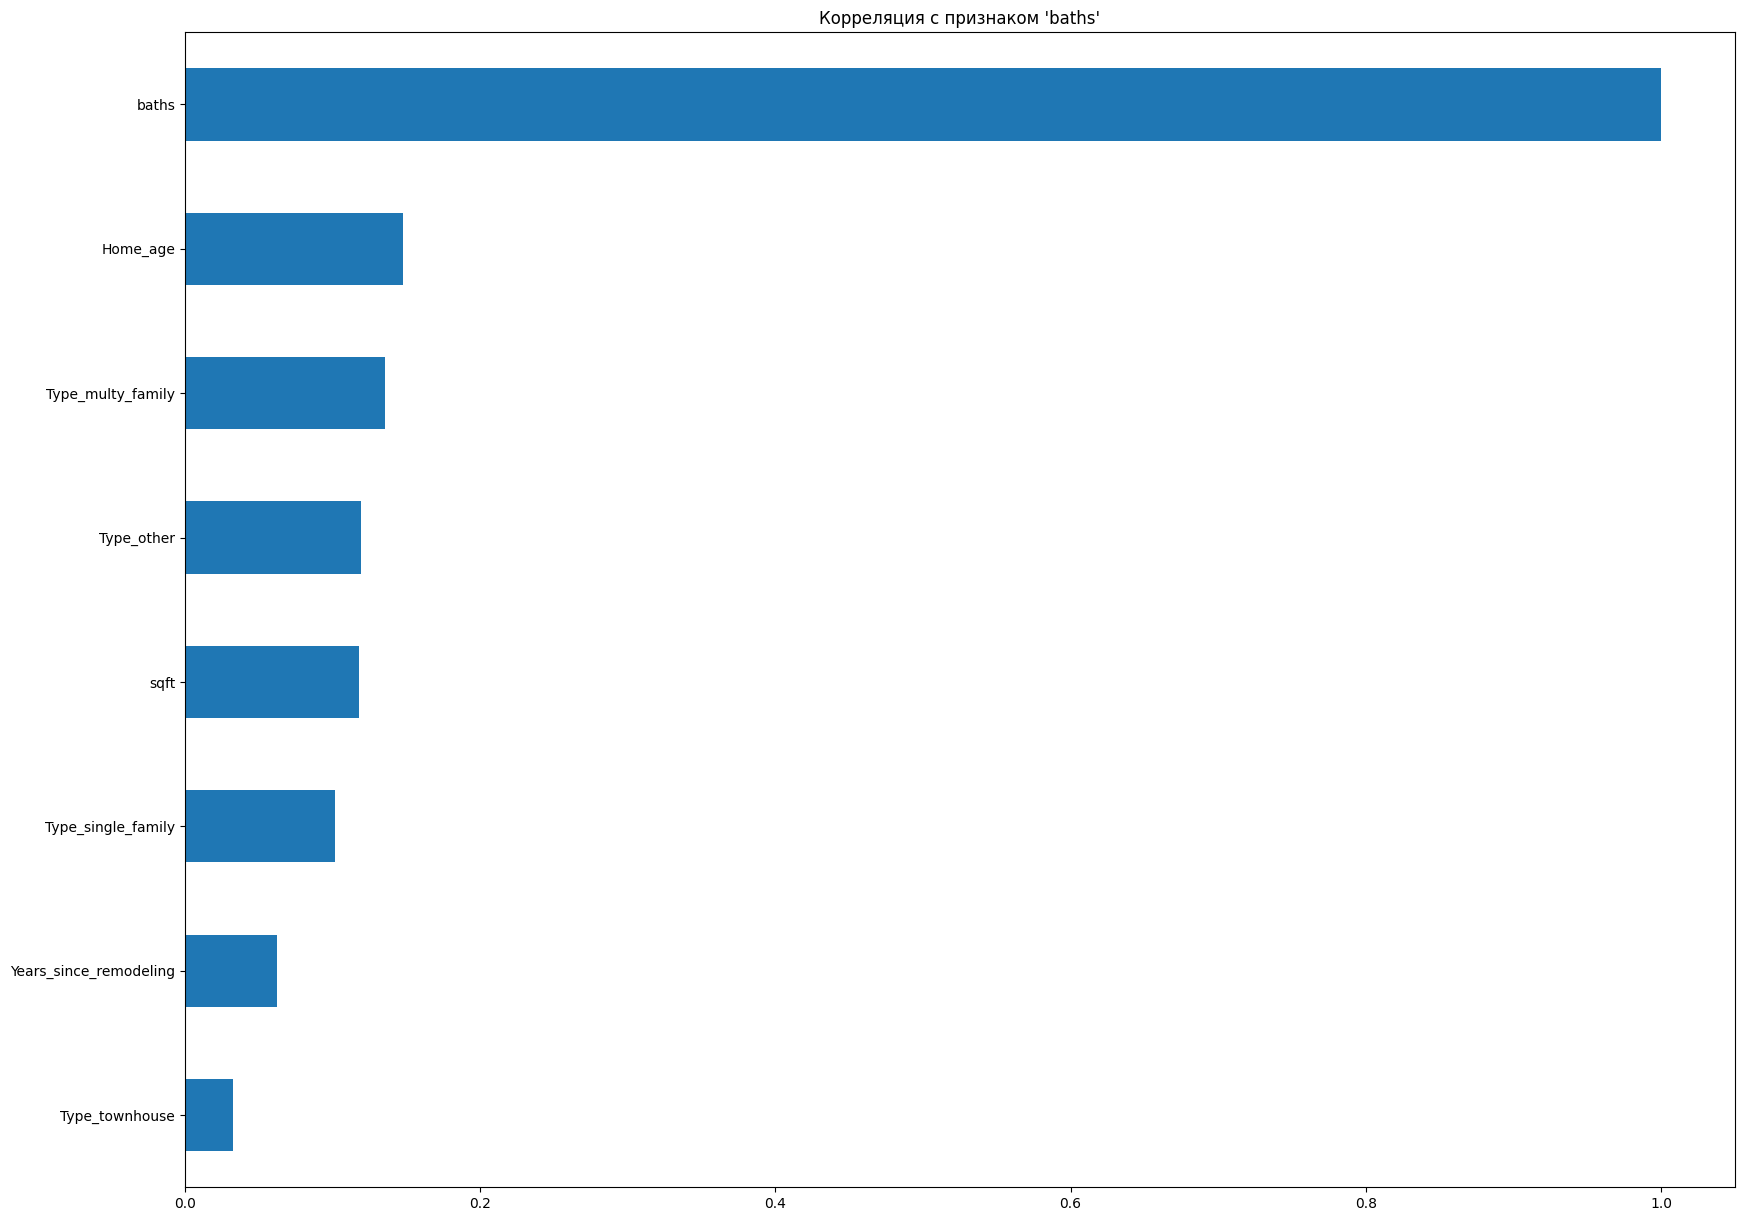

In [227]:
# Создаём временный дата-сет
temp = data[['propertyType', 'baths', 'Home_age', 'Years_since_remodeling', 'sqft']]

# Удаляем пропуски из признака 'baths'
temp = temp.dropna(axis = 0)

# Кодируем категориальные признаки
temp = pd.get_dummies(temp, columns = ['propertyType'], prefix='Type', dummy_na=True, drop_first=True, dtype=int)

# Смотрим на корреляцию признака 'baths' с другими признаками
corr = temp.corr()
fig, ax = plt.subplots(figsize = (20, 15))
corr['baths'].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh()
plt.title("Корреляция с признаком 'baths'");

Корреляция невысокая. Посмотрим на зависимости в признаках по отдельности.

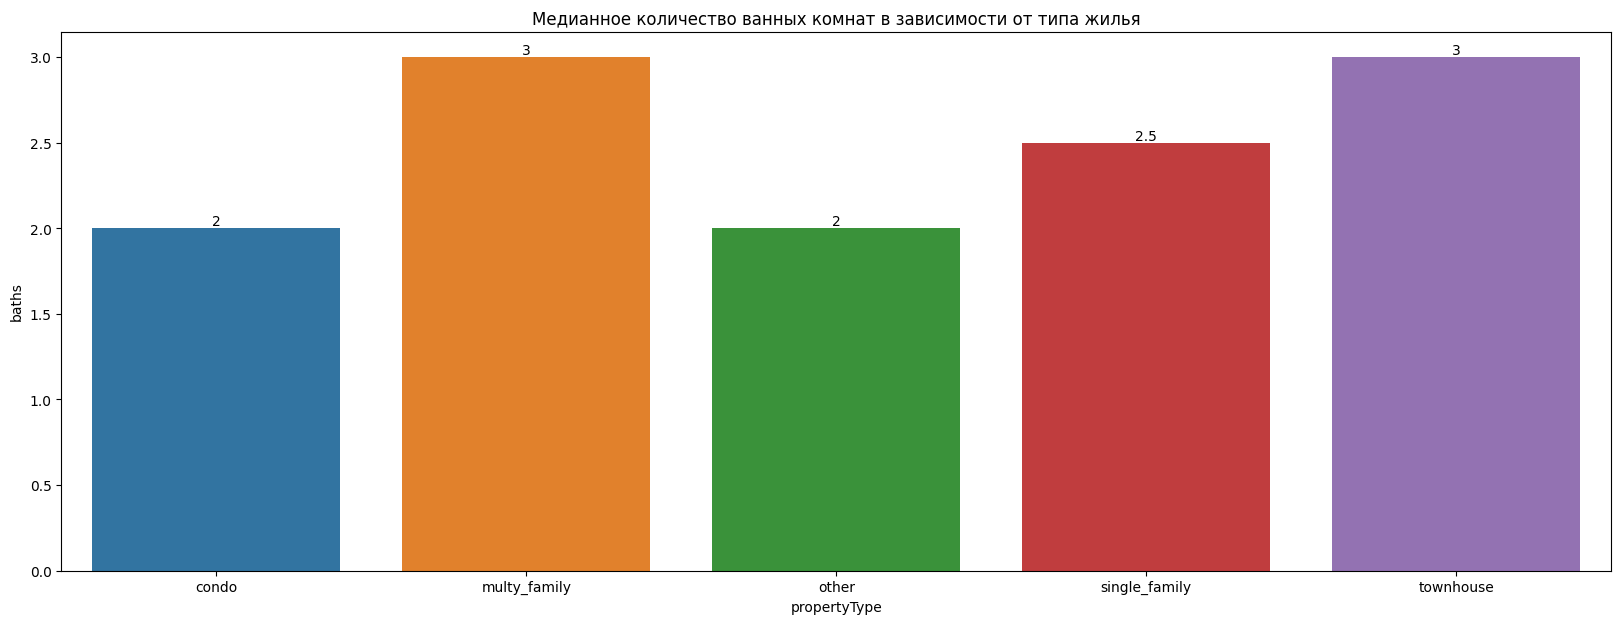

In [228]:
# Группируем медианное количество ванных комнат по типу собствености.
grouped = pd.DataFrame(data.groupby(by = 'propertyType')['baths'].median())

# Визуализируем:
fig, axes = plt.subplots(figsize = (20, 7))
ax = sns.barplot(grouped, x = grouped.index, y = 'baths', ax = axes)
ax.set_title('Медианное количество ванных комнат в зависимости от типа жилья')
ax.bar_label(ax.containers[0], fontsize=10);

Различия не слишком существенные. Но мы знаем, что в наших данных есть дома с очень большим количеством ванных комнат. Посмотрим на то же распределение, но теперь сгруппируем данные по средней, а не по медиане.

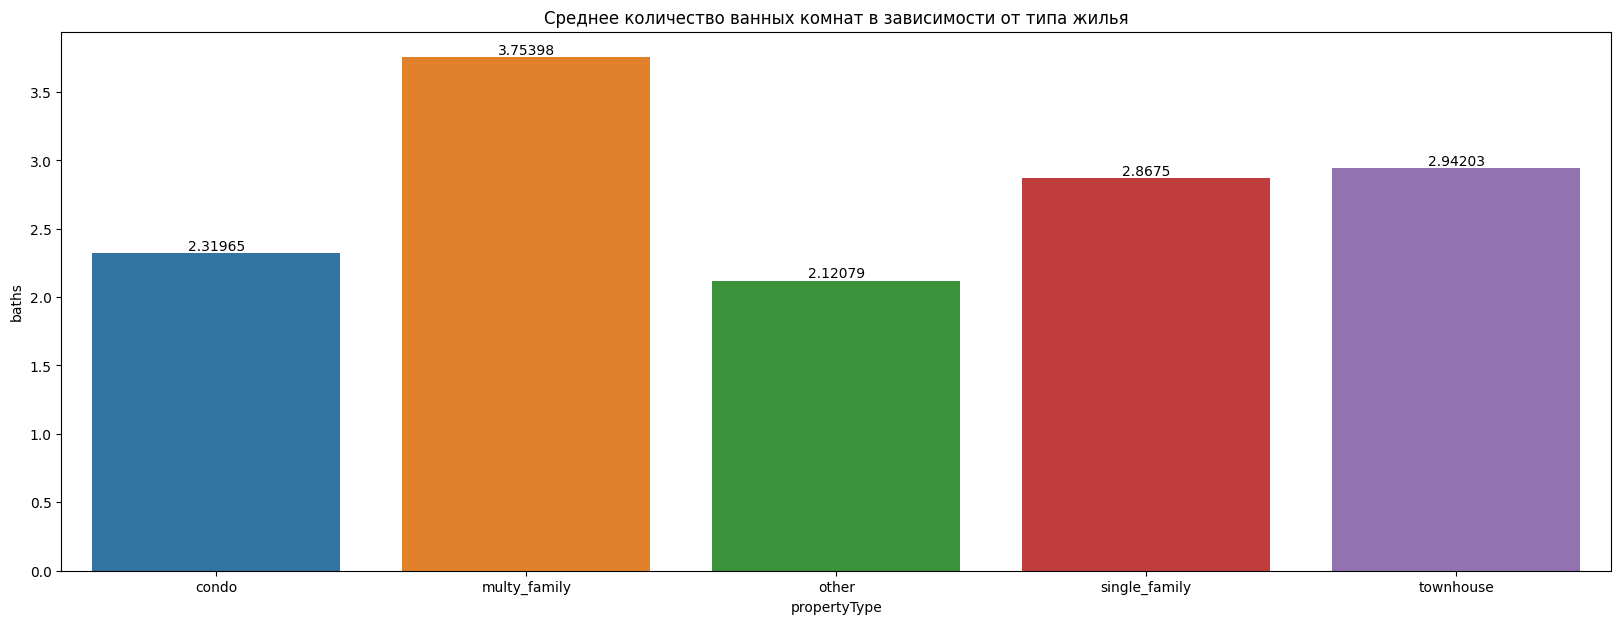

In [229]:
# Группируем среднее количество ванных комнат по типу собствености.
grouped = pd.DataFrame(data.groupby(by = 'propertyType')['baths'].mean())

# Визуализируем:
fig, axes = plt.subplots(figsize = (20, 7))
ax = sns.barplot(grouped, x = grouped.index, y = 'baths', ax = axes)
ax.set_title('Среднее количество ванных комнат в зависимости от типа жилья')
ax.bar_label(ax.containers[0], fontsize=10);

Теперь видно, что среднее количество ванных комнат в многосемейных домах превосходит этот же показатель в других домах, хотя медиана в многосемейных домах и таунхаусах одинакова.

Посмотрим, как зависит среднее количество ванных комнат от числовых признаков.

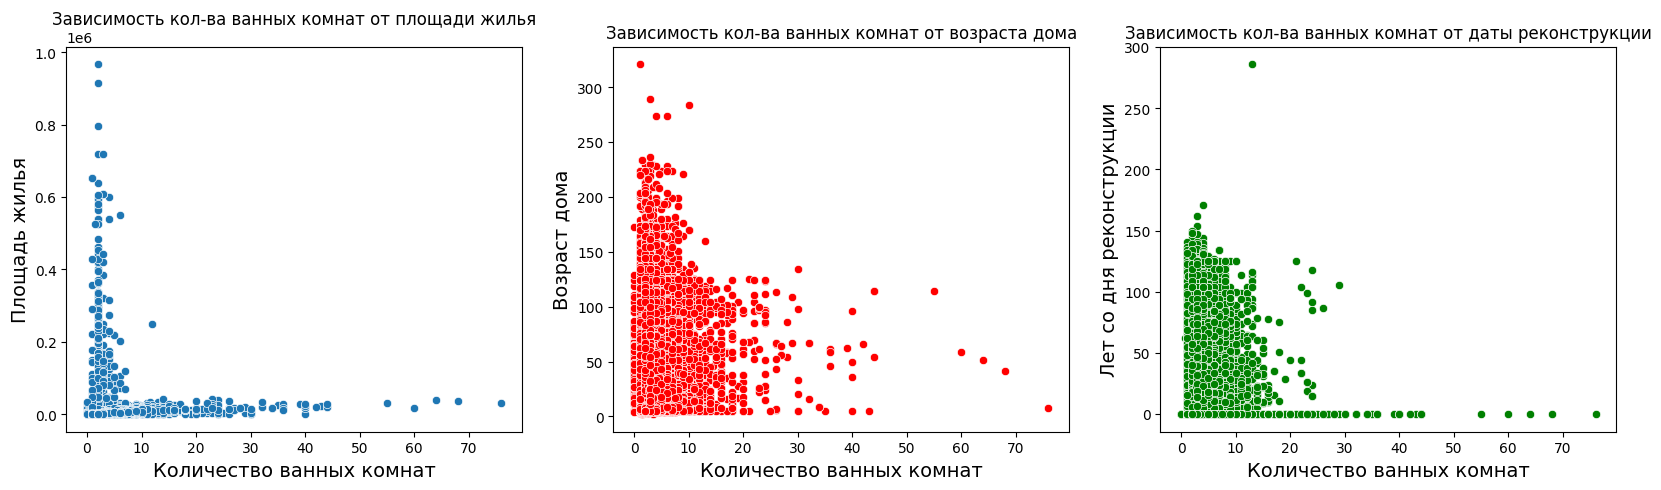

In [230]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
scatter1 = sns.scatterplot(data=data, x='baths', y='sqft', ax = axes[0])
scatter1.set_title('Зависимость кол-ва ванных комнат от площади жилья', fontsize=12)
scatter1.set_xlabel('Количество ванных комнат', fontsize=14)
scatter1.set_ylabel('Площадь жилья', fontsize=14)

scatter2 = sns.scatterplot(data=data, x='baths', y='Home_age', ax = axes[1], c = 'red')
scatter2.set_title('Зависимость кол-ва ванных комнат от возраста дома', fontsize=12)
scatter2.set_xlabel('Количество ванных комнат', fontsize=14)
scatter2.set_ylabel('Возраст дома', fontsize=14)

scatter3 = sns.scatterplot(data=data, x='baths', y='Years_since_remodeling', ax = axes[2], c = 'green')
scatter3.set_title('Зависимость кол-ва ванных комнат от даты реконструкции', fontsize=12)
scatter3.set_xlabel('Количество ванных комнат', fontsize=14)
scatter3.set_ylabel('Лет со дня реконструкции', fontsize=14);

На графиках таже отчётливо видно, что связь количествa ванных комнат с другими числовыми признаками крайне низкая. Поэтому представляется целесообразным заполнить пропуски в данном признаке медианой.

In [231]:
data['baths'] = data['baths'].fillna(data['baths'].median())

### Признаки 'Heating' и 'Cooling'

Оба этих признака должны зависеть от года постройки или реконструкции. Проверим эту гипотезу.

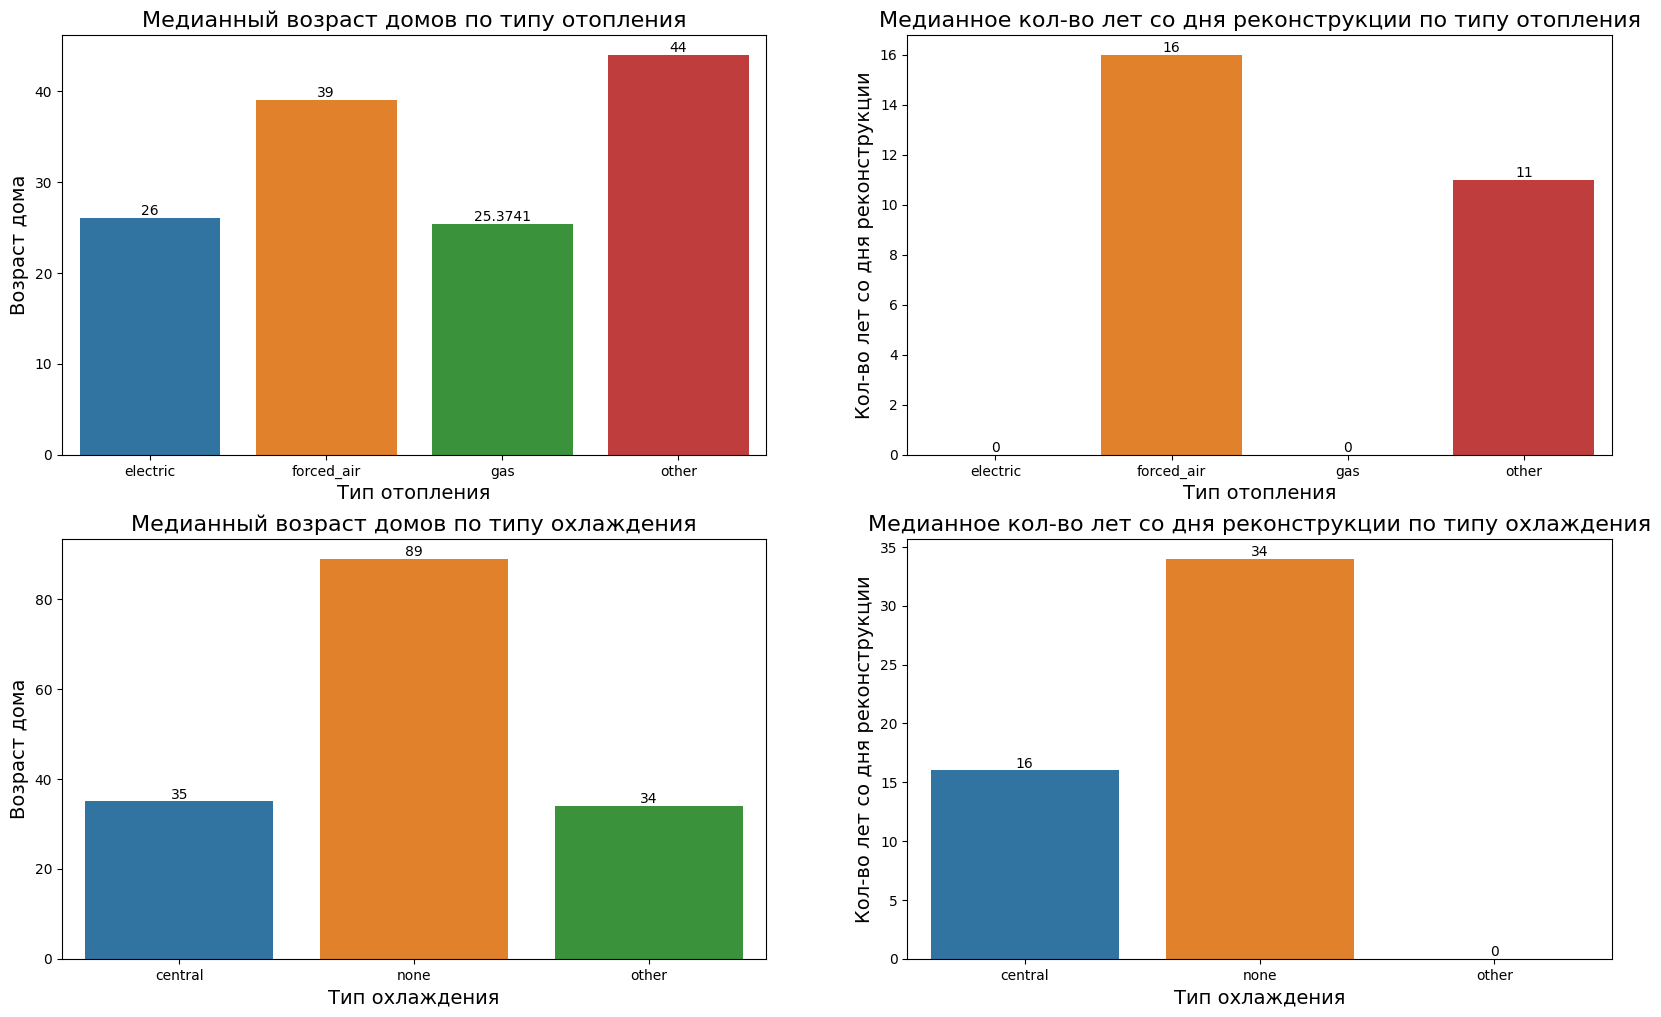

In [233]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

grouped1 = pd.DataFrame(data.groupby(by = 'Heating')['Home_age'].median())

barplot1 = sns.barplot(grouped1, x = grouped1.index, y = 'Home_age', ax = axes[0, 0])
barplot1.set_title('Медианный возраст домов по типу отопления', fontsize=16)
barplot1.bar_label(barplot1.containers[0], fontsize=10);
barplot1.set_xlabel('Тип отопления', fontsize=14)
barplot1.set_ylabel('Возраст дома', fontsize=14)

grouped2 = pd.DataFrame(data.groupby(by = 'Heating')['Years_since_remodeling'].median())

barplot2 = sns.barplot(grouped2, x = grouped2.index, y = 'Years_since_remodeling', ax = axes[0, 1])
barplot2.set_title('Медианное кол-во лет со дня реконструкции по типу отопления', fontsize=16)
barplot2.bar_label(barplot2.containers[0], fontsize=10);
barplot2.set_xlabel('Тип отопления', fontsize=14)
barplot2.set_ylabel('Кол-во лет со дня реконструкции', fontsize=14)

grouped3 = pd.DataFrame(data.groupby(by = 'Cooling')['Home_age'].median())

barplot3 = sns.barplot(grouped3, x = grouped3.index, y = 'Home_age', ax = axes[1, 0])
barplot3.set_title('Медианный возраст домов по типу охлаждения', fontsize=16)
barplot3.bar_label(barplot3.containers[0], fontsize=10);
barplot3.set_xlabel('Тип охлаждения', fontsize=14)
barplot3.set_ylabel('Возраст дома', fontsize=14)

grouped4 = pd.DataFrame(data.groupby(by = 'Cooling')['Years_since_remodeling'].median())

barplot4 = sns.barplot(grouped4, x = grouped4.index, y = 'Years_since_remodeling', ax = axes[1, 1])
barplot4.set_title('Медианное кол-во лет со дня реконструкции по типу охлаждения', fontsize=16)
barplot4.bar_label(barplot4.containers[0], fontsize=10);
barplot4.set_xlabel('Тип охлаждения', fontsize=14)
barplot4.set_ylabel('Кол-во лет со дня реконструкции', fontsize=14);

Как видно из графиков, электрическое и газовое отопление являются более современными и строятся в новых домах. Косвенное доказательство данному утверждению - медианное нулевое количество лет со дня реконструкции таких домов, т.е. они настолько новые, что пока не требовали ремонта или реконструкции. Другие виды отопления встречаются в более старых домах. Посмотрим на корреляцию данных признаков с остальными.

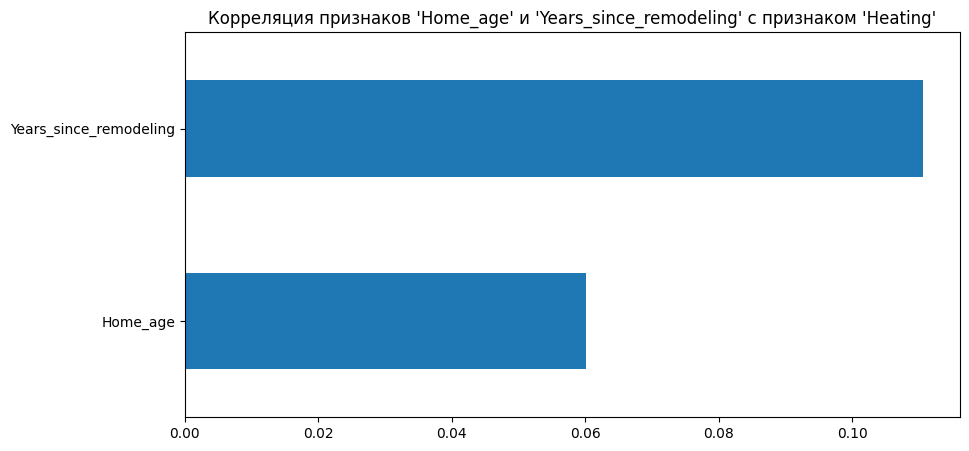

In [234]:
# Создаём временный дата-сет
temp = data[['Heating', 'Home_age', 'Years_since_remodeling']]

# Удаляем пропуски из признака 'Heating'
temp = temp.dropna(axis = 0)

# Перекодируем признак 'Heating'
temp['Heating'] = temp['Heating'].apply(lambda x:
    3 if x == 'forced_air'
    else 2 if x == 'other'
    else 1 if x == 'electric'
    else 0)

# Смотрим на корреляцию признака 'sqft' с другими признаками
corr = temp.corr()
fig, ax = plt.subplots(figsize = (10, 5))
corr['Heating'].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh()
plt.title("Корреляция признаков 'Home_age' и 'Years_since_remodeling' с признаком 'Heating'");

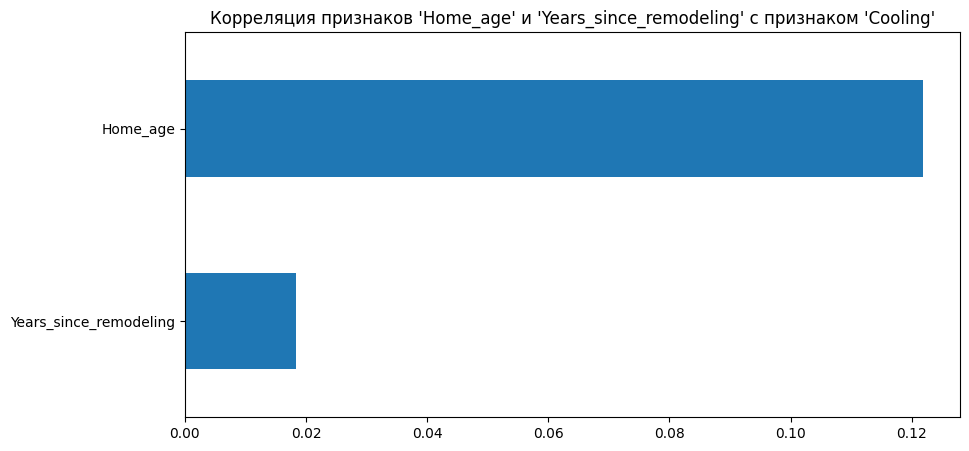

In [235]:
# Создаём временный дата-сет
temp = data[['Cooling', 'Home_age', 'Years_since_remodeling']]

# Удаляем пропуски из признака 'Cooling'
temp = temp.dropna(axis = 0)

# Перекодируем признак 'Cooling'
temp['Cooling'] = temp['Cooling'].apply(lambda x:
    2 if x == 'central'
    else 1 if x == 'other'
    else 0)

# Смотрим на корреляцию признака 'sqft' с другими признаками
corr = temp.corr()
fig, ax = plt.subplots(figsize = (10, 5))
corr['Cooling'].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh()
plt.title("Корреляция признаков 'Home_age' и 'Years_since_remodeling' с признаком 'Cooling'");

Как видим, корреляция довольно слабая. Поскольку пропуски в признаке 'Heating' занимают довольно много места (26,9%), заполнение их модой сильно бы исказило зависимости в данных. Именно поэтому мы считаем целесообразным заполнить пропуски новыми данными - 'unknown'.

Что касается признака 'Cooling', то учитывая, во-первых, что пропуски в нём занимают более трети от всех записей, во-вторых, что они сильно скоррелированы с пропусками в признаке 'Heating' и наконец, в-третьих, что адекватно заполнить пропуски здесь не представляется возможным из-за слабой корреляции данного признака с другими, мы решили удалить данный признак из нашего набора данных.

In [236]:
data['Heating'] = data['Heating'].fillna('unknown')
data = data.drop('Cooling', axis = 1)

### Признак 'Parking'

Данный признак мы перекодируем по принципу двоичного кодирования: есть гараж - нет гаража, потому что очевидно, что его наличие будет оказывать существенное влияние на стоимость дома.

In [237]:
data['Parking'] = data['Parking'].apply(lambda x: 1 if x == 'garage' else 0)

### Признак 'lotsize'

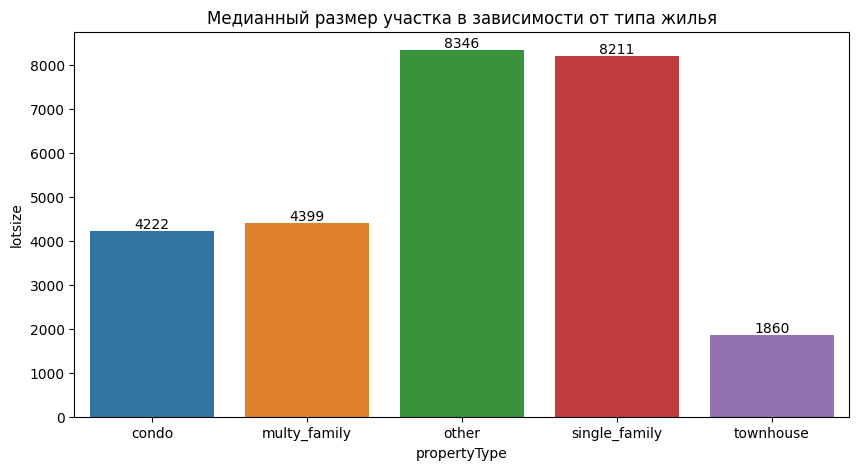

In [238]:
# Группируем медианный размер участка по типу собствености.
grouped = pd.DataFrame(data.groupby(by = 'propertyType')['lotsize'].median())

# Визуализируем:
fig, axes = plt.subplots(figsize = (10, 5))
ax = sns.barplot(grouped, x = grouped.index, y = 'lotsize', ax = axes)
ax.set_title('Медианный размер участка в зависимости от типа жилья')
ax.bar_label(ax.containers[0], fontsize=10);

Как видим, при односемейных домах участки больше, чем при всех остальных примерно в два раза. Посмотрим, как влияет на размер участка наличие бассейна.

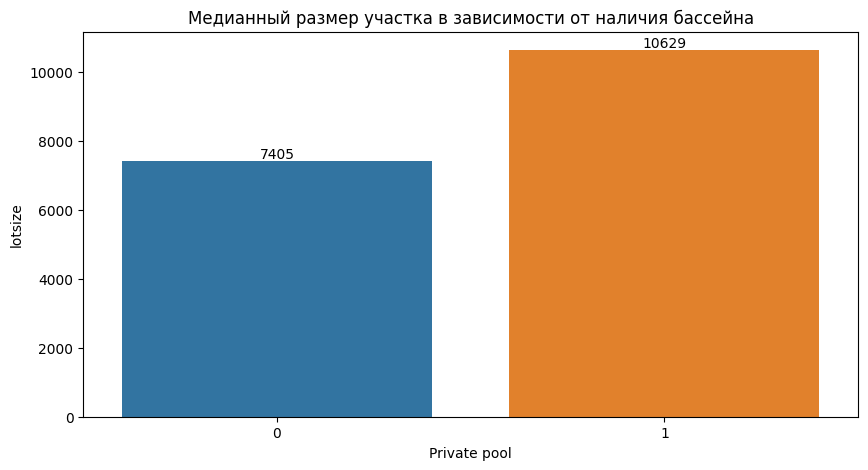

In [239]:
# Группируем медианный размер участка по признаку наличия бассейна:
grouped = pd.DataFrame(data.groupby(by = 'Private pool')['lotsize'].median())

# Визуализируем:
fig, axes = plt.subplots(figsize = (10, 5))
ax = sns.barplot(grouped, x = grouped.index, y = 'lotsize', ax = axes)
ax.set_title('Медианный размер участка в зависимости от наличия бассейна')
ax.bar_label(ax.containers[0], fontsize=10);

Итак, ожидаемо при наличии бассейна площадь участка увеличивается. Посмотрим, наблюдается ли такая же зависимость в случае наличия гаража.

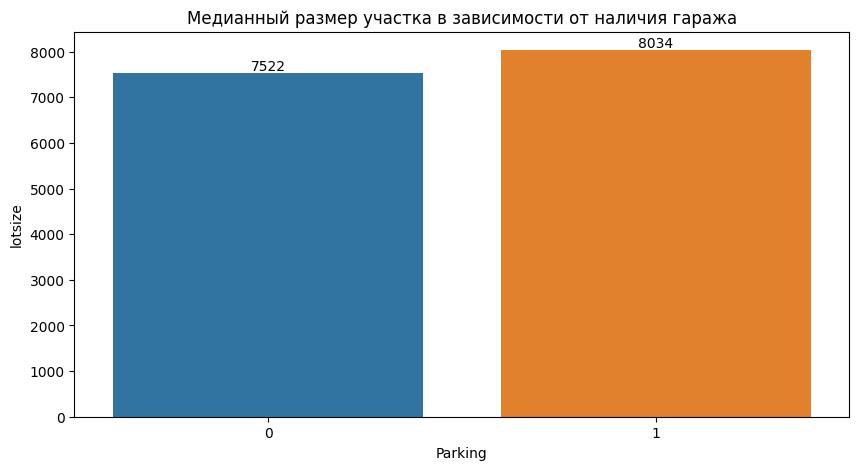

In [240]:
# Группируем медианный размер участка по признаку наличия гаража:
grouped = pd.DataFrame(data.groupby(by = 'Parking')['lotsize'].median())

# Визуализируем:
fig, axes = plt.subplots(figsize = (10, 5))
ax = sns.barplot(grouped, x = grouped.index, y = 'lotsize', ax = axes)
ax.set_title('Медианный размер участка в зависимости от наличия гаража')
ax.bar_label(ax.containers[0], fontsize=10);

Здесь разница не так очевидна. А что если у дома есть и бассейн, и гараж?

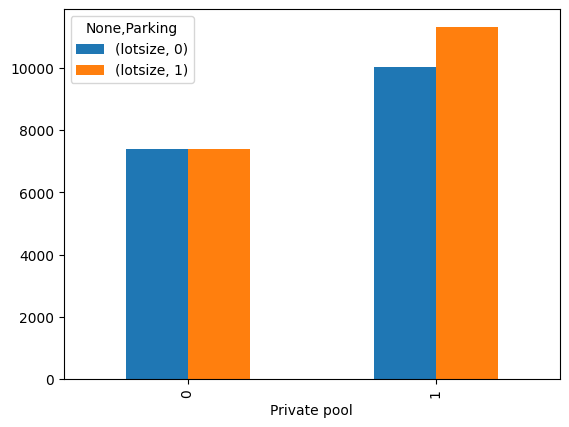

In [241]:
# Группируем медианный размер участка по признаку наличия бассейна:
grouped = pd.DataFrame(data.groupby(by = ['Private pool', 'Parking'])['lotsize'].median())

# Визуализируем:
grouped.unstack().plot(kind='bar');

Итак, наличие бассейна оказывает большее влияние на размер участка, чем наличие гаража. Если при доме есть и гараж, и бассейн, то размер участка наибольший. 

А как влияют на размер участка числовые признаки, в частности, площадь дома, качество жизни и экономики в штате и медианная стоимость домов в микрорайоне, где он находится? Посмотрим.

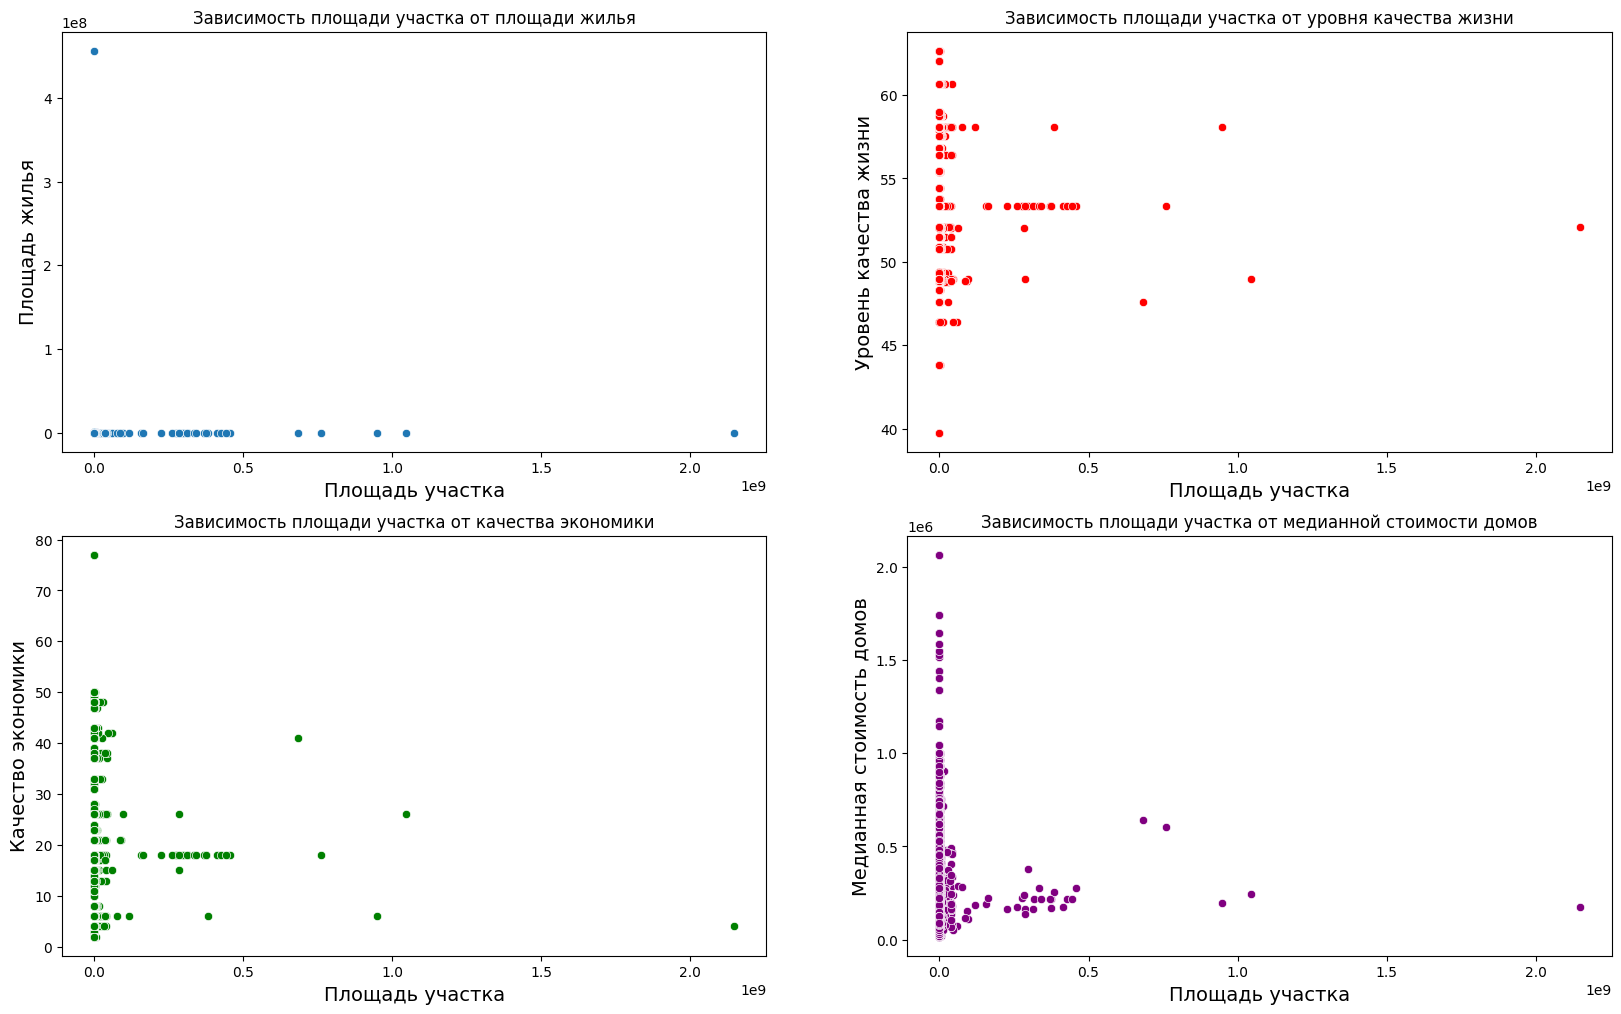

In [242]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
scatter1 = sns.scatterplot(data=data, x='lotsize', y='sqft', ax = axes[0, 0])
scatter1.set_title('Зависимость площади участка от площади жилья', fontsize=12)
scatter1.set_xlabel('Площадь участка', fontsize=14)
scatter1.set_ylabel('Площадь жилья', fontsize=14)

scatter2 = sns.scatterplot(data=data, x='lotsize', y='QualityOfLifeTotalScore', ax = axes[0, 1], c = 'red')
scatter2.set_title('Зависимость площади участка от уровня качества жизни', fontsize=12)
scatter2.set_xlabel('Площадь участка', fontsize=14)
scatter2.set_ylabel('Уровень качества жизни', fontsize=14)

scatter3 = sns.scatterplot(data=data, x='lotsize', y='QualityOfLifeEconomy', ax = axes[1, 0], c = 'green')
scatter3.set_title('Зависимость площади участка от качества экономики', fontsize=12)
scatter3.set_xlabel('Площадь участка', fontsize=14)
scatter3.set_ylabel('Качество экономики', fontsize=14)

scatter4 = sns.scatterplot(data=data, x='lotsize', y='Med_home_value', ax = axes[1, 1], c = 'purple')
scatter4.set_title('Зависимость площади участка от медианной стоимости домов', fontsize=12)
scatter4.set_xlabel('Площадь участка', fontsize=14)
scatter4.set_ylabel('Медианная стоимость домов', fontsize=14);

Как видим, явной зависимости между признаками нет.

Посмотрим на корреляцию признака 'lotsize' с другими.

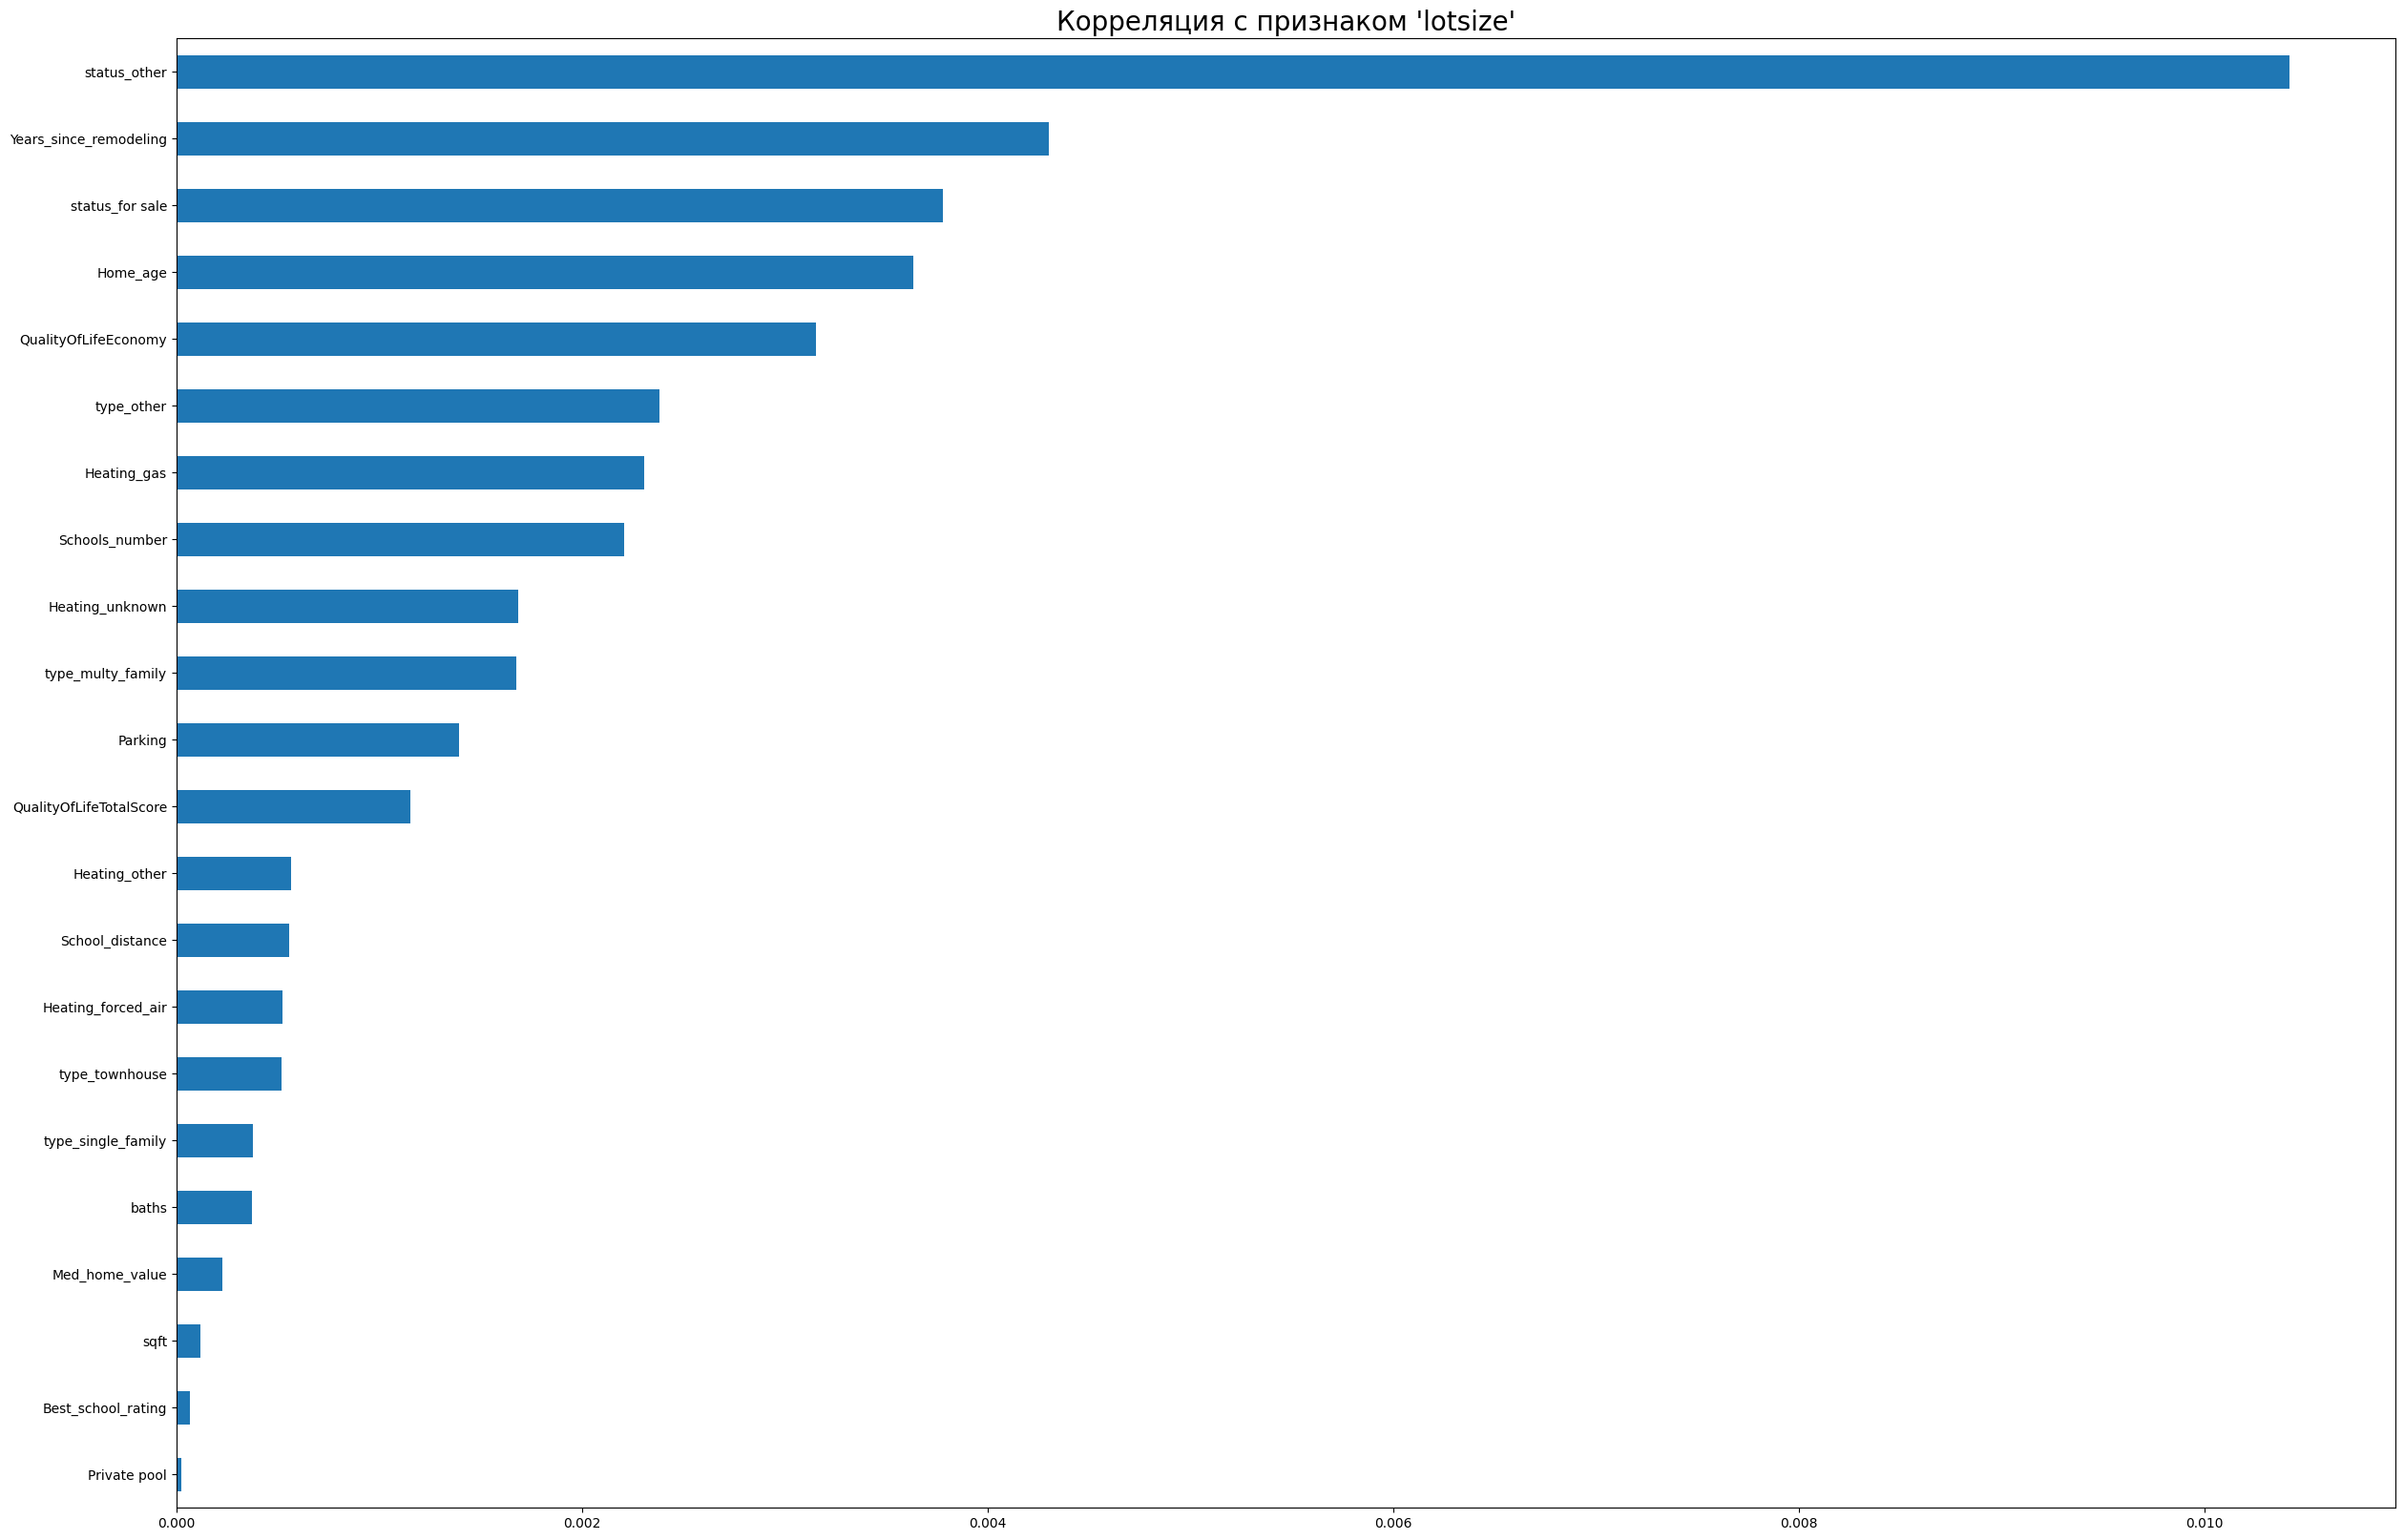

In [243]:
# Создаём временный дата-сет
temp = data.drop('target', axis = 1)

# Удаляем пропуски из признака 'lotsize'
temp = temp[temp['lotsize'].isnull() == False]

# Кодируем категориальные признаки
temp = pd.get_dummies(temp, columns = ['status'], prefix='status', drop_first=True, dtype=int)
temp = pd.get_dummies(temp, columns = ['Heating'], prefix='Heating', drop_first=True, dtype=int)
temp = pd.get_dummies(temp, columns = ['propertyType'], prefix='type', drop_first=True, dtype=int)

# Смотрим на корреляцию признака 'lotsize' с другими признаками
corr = temp.corr()
fig, ax = plt.subplots(figsize = (30, 20))
corr['lotsize'].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh()
plt.title("Корреляция с признаком 'lotsize'", fontsize = 20);

Корреляция очень слабая. Может быть, зависимость в данных лучше найдёт модель машинного обучения? Попробуем построить модель, предсказывающую площадь участка.

In [244]:
# Выделяем целевую переменную из временного дата-сета.
temp_y = temp['lotsize']
temp_X = temp.drop('lotsize', axis = 1)

In [245]:
# Делим временный дата-сет на обучающую и валидационную выборки:
temp_X_train, temp_X_valid, temp_y_train, temp_y_valid = train_test_split(
    temp_X, temp_y,
    test_size=0.2,
    random_state=42)

В качестве модели выберем CatBoostRegressor, поскольку он не требует масштабирования данных.

In [262]:
model = CatBoostRegressor(random_state=42, silent=True)

model.fit(temp_X_train, temp_y_train)
metrics.mean_absolute_percentage_error(temp_y_valid, model.predict(temp_X_valid))

91.62071949183478

Ошибка получилась очень большой. Это значит, нам не удастся заполнить пропуски в признаке 'lotsize', основываясь на зависимостях в данных. В таком случае, заполним его медианой.

In [246]:
data['lotsize'] = data['lotsize'].fillna(data['lotsize'].median())

Убедимся, что все пропуски заполнены.

In [248]:
data.isnull().sum()

status                     0
propertyType               0
baths                      0
sqft                       0
target                     0
Private pool               0
QualityOfLifeTotalScore    0
QualityOfLifeEconomy       0
Med_home_value             0
Heating                    0
Parking                    0
lotsize                    0
Schools_number             0
Best_school_rating         0
School_distance            0
Home_age                   0
Years_since_remodeling     0
dtype: int64

In [265]:
data.to_csv('temp.csv')

In [283]:
data = pd.read_csv('temp.csv').drop('Unnamed: 0', axis = 1)
data

,status,propertyType,baths,sqft,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Heating,Parking,lotsize,Schools_number,Best_school_rating,School_distance,Home_age,Years_since_remodeling
0,active,single_family,3.5,2900.0,418000,0,51.51,17.0,226300.0,other,0,7749.0,8,7.0,10.50,5.0,0
1,for sale,single_family,3.0,1947.0,310000,0,52.11,4.0,185700.0,unknown,0,5828.0,3,4.0,1.01,5.0,0
2,for sale,single_family,2.0,3000.0,2895000,1,52.03,15.0,1000000.0,forced_air,1,8626.0,3,8.0,1.19,63.0,57
3,for sale,single_family,8.0,6457.0,2395000,0,49.00,26.0,931800.0,forced_air,1,8220.0,4,9.0,0.10,18.0,18
4,for sale,townhouse,2.5,897.0,209000,0,56.42,38.0,152100.0,forced_air,0,680.0,0,0.0,0.00,104.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314583,for sale,condo,3.0,1417.0,799000,0,59.00,77.0,490600.0,forced_air,0,7749.0,2,3.0,0.10,14.0,0
314584,for sale,single_family,6.0,4017.0,1249000,1,58.07,6.0,329600.0,other,0,8500.0,2,5.0,1.10,34.0,34
314585,for sale,condo,3.0,2000.0,674999,0,55.47,50.0,408900.0,other,0,7749.0,3,7.0,0.40,100.0,0
314586,for sale,single_family,3.0,1152.0,528000,0,60.64,37.0,383200.0,other,0,1600.0,2,5.0,0.48,74.0,74


### Анализ данных на наличие выбросов.

Проанализируем разброс данных в числовых признаках.

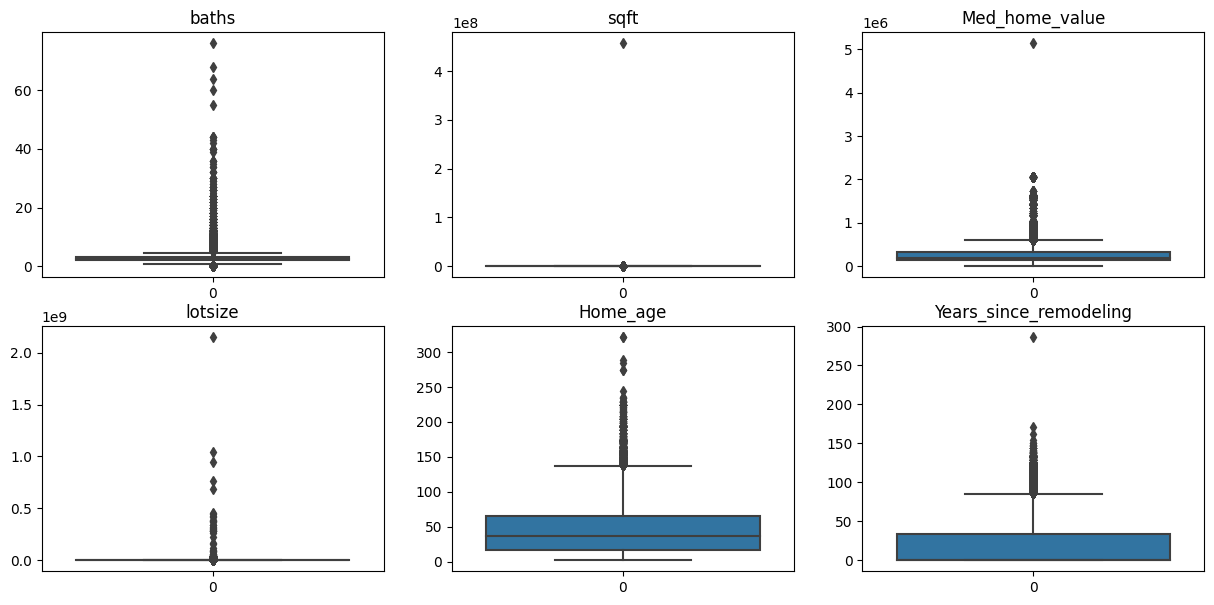

In [249]:
# Построим коробчатые диаграммы для числовых признаков:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15, 7))

ax1 = sns.boxplot(data['baths'], ax=axes[0,0])
ax1.set_title('baths', fontsize=12)
ax2 = sns.boxplot(data['sqft'], ax=axes[0,1])
ax2.set_title('sqft', fontsize=12)
ax3 = sns.boxplot(data['Med_home_value'], ax=axes[0,2])
ax3.set_title('Med_home_value', fontsize=12)
ax4 = sns.boxplot(data['lotsize'], ax=axes[1,0])
ax4.set_title('lotsize', fontsize=12)
ax5 = sns.boxplot(data['Home_age'], ax=axes[1,1])
ax5.set_title('Home_age', fontsize=12)
ax6 = sns.boxplot(data['Years_since_remodeling'], ax=axes[1,2])
ax6.set_title('Years_since_remodeling', fontsize=12);

Как видно, в данных есть аномальные значения. Посмотрим на расределение данных в признаках.

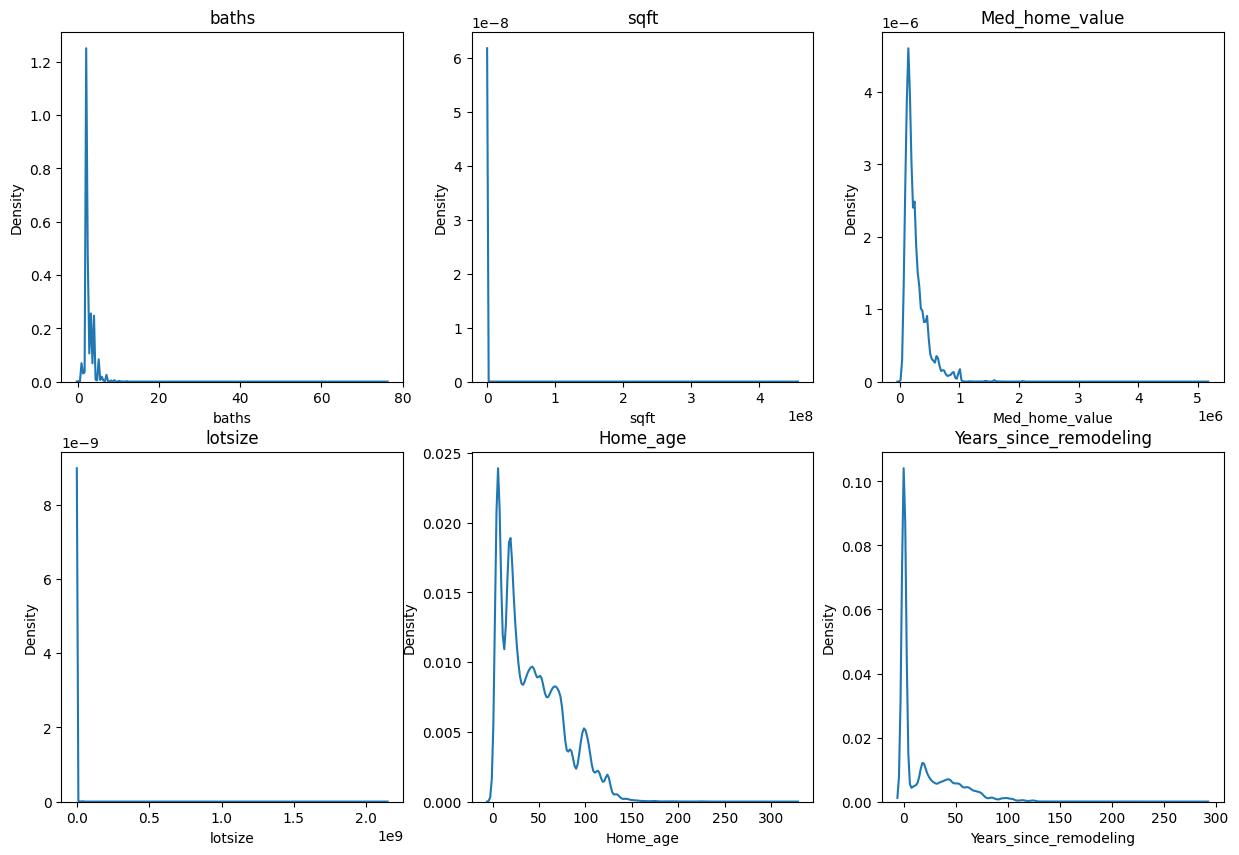

In [250]:
# Посмотрим на графики распределения kde в числовых признаках:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15, 10))

ax1 = sns.kdeplot(data['baths'], ax=axes[0,0])
ax1.set_title('baths', fontsize=12)
ax2 = sns.kdeplot(data['sqft'], ax=axes[0,1])
ax2.set_title('sqft', fontsize=12)
ax3 = sns.kdeplot(data['Med_home_value'], ax=axes[0,2])
ax3.set_title('Med_home_value', fontsize=12)
ax4 = sns.kdeplot(data['lotsize'], ax=axes[1,0])
ax4.set_title('lotsize', fontsize=12)
ax5 = sns.kdeplot(data['Home_age'], ax=axes[1,1])
ax5.set_title('Home_age', fontsize=12)
ax6 = sns.kdeplot(data['Years_since_remodeling'], ax=axes[1,2])
ax6.set_title('Years_since_remodeling', fontsize=12);

Ожидаемо данные распределены ненормально, поэтому для определения выбросов в данных будем использовать метод Тьюки.

Начнём с признака 'sqft', поскольку, как видно из коробчатой диаграммы, данные там распределены наиболее экстремально.

In [251]:
# Определим выбросы в признаке 'lotsize' по методу Тьюки:
def outliers_iqr(data, feature): # Создаём функцию с переменными DF и необходимый столбец
    '''
    Выявление выбросов методом Тьюки
    data: DataFrame,
    feature: признак, в котором нужно выявить выбросы.
    На выходе получаем два DataFrame:
    outliers - DataFrame с выбросами,
    cleaned - DataFrame, очищенный от выбросов
    '''
    x = data[feature] # x - это необходимый столбец
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75), # Ищем в необходимом столбце квантили
    iqr = quartile_3 - quartile_1 # Теперь межквартильный размах
    lower_bound = quartile_1 - (iqr * 1.5) # Нижняя граница Тьюки
    upper_bound = quartile_3 + (iqr * 1.5) # Верхняя граница Тьюки
    outliers = data[(x < lower_bound) | (x > upper_bound)] # Это выбросы
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)] # Это очищенные записи
    return outliers, cleaned

# Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:
outliers, cleaned = outliers_iqr(data, 'sqft') # Применяем функцию к необходимому столбцу
print(f"Число выбросов по методу Тьюки: {outliers.shape[0]} \n\
со значениями от {outliers['sqft'].min()} до {outliers['sqft'].max()}")

Число выбросов по методу Тьюки: 17061 
со значениями от 4558.0 до 456602479.0


Очистим данные от выбросов и посмотрим на новое распределение в данных в признаке 'sqft'.

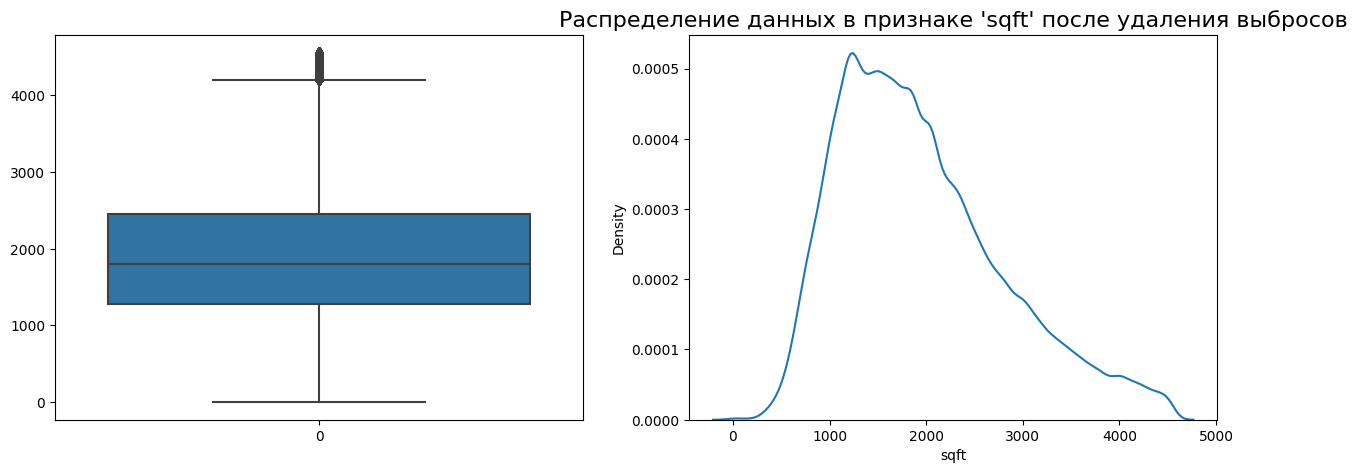

In [252]:
data = cleaned

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.title("Распределение данных в признаке 'sqft' после удаления выбросов", fontsize = 16)

ax1 = sns.boxplot(data['sqft'], ax=axes[0])
ax2 = sns.kdeplot(data['sqft'], ax=axes[1]);

Далее последовательно очистим от выбросов другие признаки.

In [253]:
outliers, cleaned = outliers_iqr(data, 'lotsize') # Применяем функцию к необходимому столбцу
print(f"Число выбросов по методу Тьюки: {outliers.shape[0]} \n\
со значениями от {outliers['lotsize'].min()} до {outliers['lotsize'].max()}")

Число выбросов по методу Тьюки: 36261 
со значениями от 15807.0 до 1045508890.0


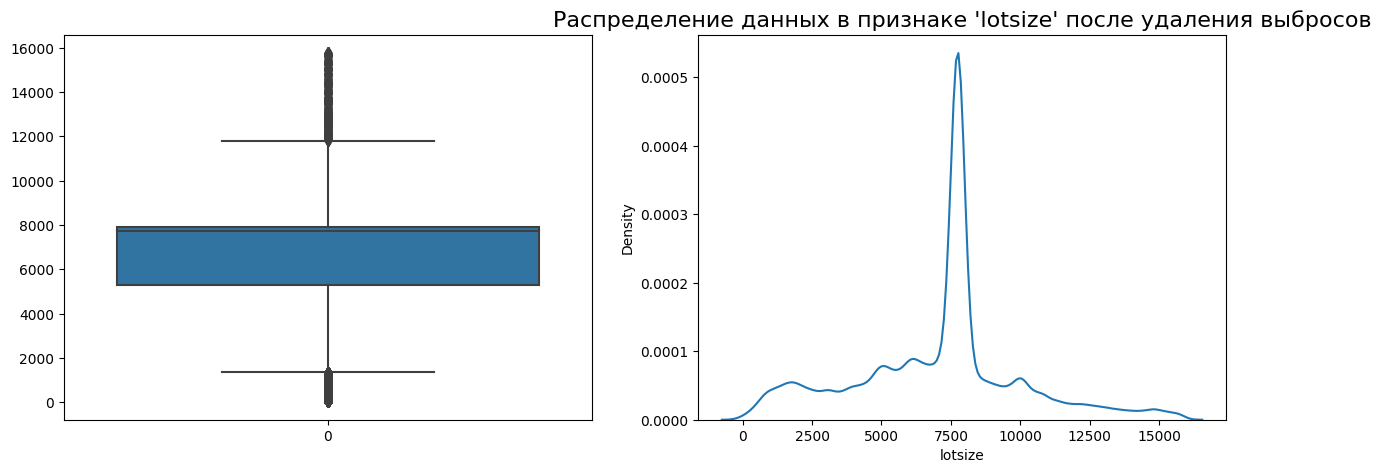

In [254]:
data = cleaned

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.title("Распределение данных в признаке 'lotsize' после удаления выбросов", fontsize = 16)

ax1 = sns.boxplot(data['lotsize'], ax=axes[0])
ax2 = sns.kdeplot(data['lotsize'], ax=axes[1]);

In [255]:
outliers, cleaned = outliers_iqr(data, 'baths') # Применяем функцию к необходимому столбцу
print(f"Число выбросов по методу Тьюки: {outliers.shape[0]} \n\
со значениями от {outliers['baths'].min()} до {outliers['baths'].max()}")

Число выбросов по методу Тьюки: 7037 
со значениями от 0.0 до 40.0


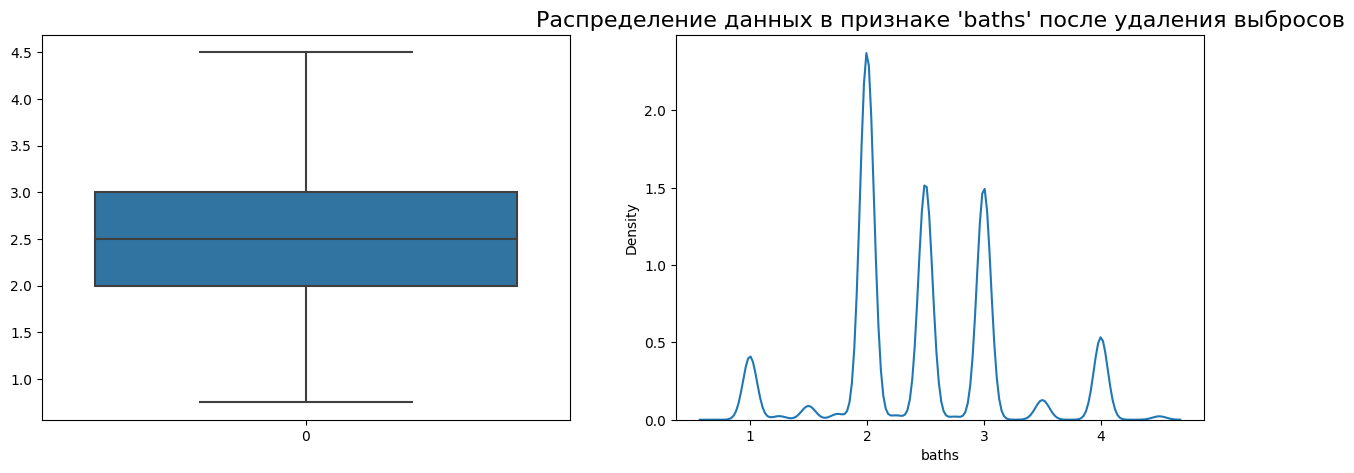

In [256]:
data = cleaned

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.title("Распределение данных в признаке 'baths' после удаления выбросов", fontsize = 16)

ax1 = sns.boxplot(data['baths'], ax=axes[0])
ax2 = sns.kdeplot(data['baths'], ax=axes[1]);

In [257]:
outliers, cleaned = outliers_iqr(data, 'Home_age') # Применяем функцию к необходимому столбцу
print(f"Число выбросов по методу Тьюки: {outliers.shape[0]} \n\
со значениями от {outliers['Home_age'].min()} до {outliers['Home_age'].max()}")

Число выбросов по методу Тьюки: 799 
со значениями от 140.0 до 321.0


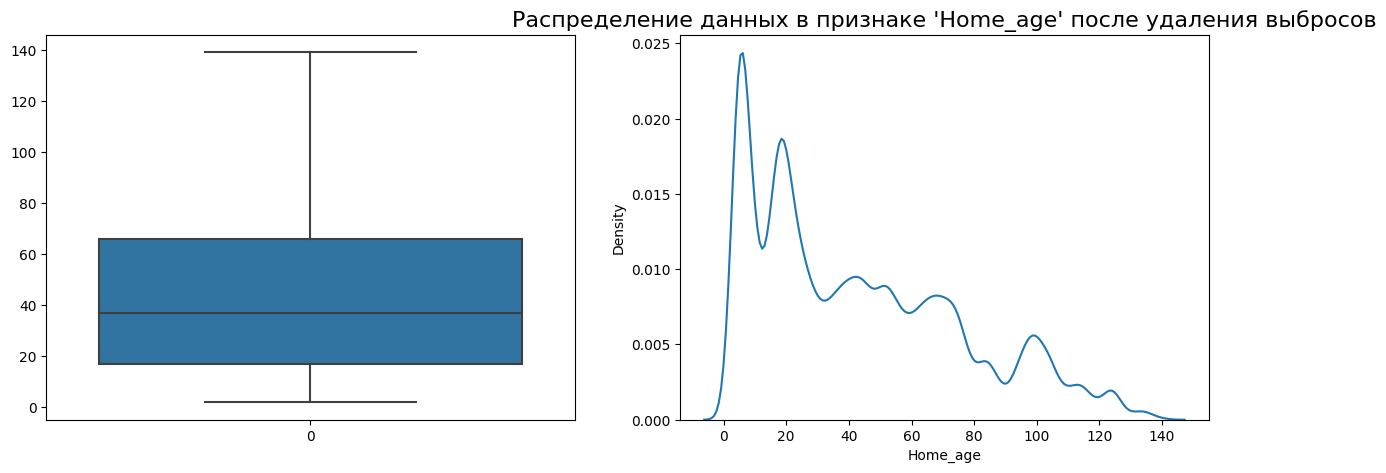

In [258]:
data = cleaned

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.title("Распределение данных в признаке 'Home_age' после удаления выбросов", fontsize = 16)

ax1 = sns.boxplot(data['Home_age'], ax=axes[0])
ax2 = sns.kdeplot(data['Home_age'], ax=axes[1]);

In [259]:
outliers, cleaned = outliers_iqr(data, 'Years_since_remodeling') # Применяем функцию к необходимому столбцу
print(f"Число выбросов по методу Тьюки: {outliers.shape[0]} \n\
со значениями от {outliers['Years_since_remodeling'].min()} до {outliers['Years_since_remodeling'].max()}")

Число выбросов по методу Тьюки: 6572 
со значениями от 88 до 139


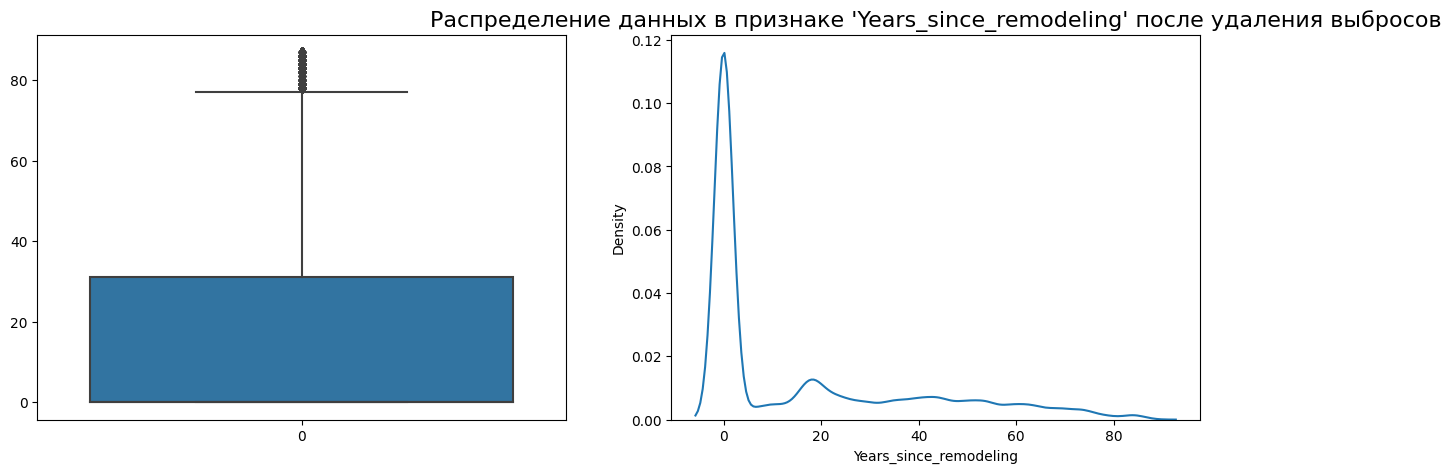

In [260]:
data = cleaned

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.title("Распределение данных в признаке 'Years_since_remodeling' после удаления выбросов", fontsize = 16)

ax1 = sns.boxplot(data['Years_since_remodeling'], ax=axes[0])
ax2 = sns.kdeplot(data['Years_since_remodeling'], ax=axes[1]);

Теперь проанализируем на выбросы целевую переменную.

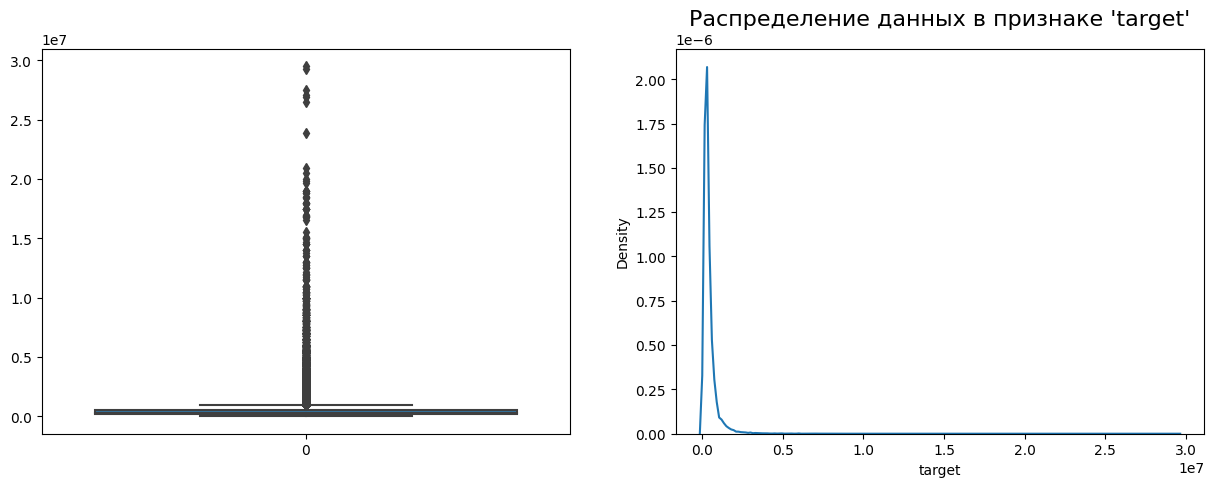

In [261]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.title("Распределение данных в признаке 'target'", fontsize = 16)

ax1 = sns.boxplot(data['target'], ax=axes[0])
ax2 = sns.kdeplot(data['target'], ax=axes[1]);

In [262]:
outliers, cleaned = outliers_iqr(data, 'target') # Применяем функцию к необходимому столбцу
print(f"Число выбросов по методу Тьюки: {outliers.shape[0]} \n\
со значениями от {outliers['target'].min()} до {outliers['target'].max()}")

Число выбросов по методу Тьюки: 18850 
со значениями от 912990 до 29500000


In [263]:
data = cleaned

In [300]:
data.to_csv('temp1.csv')

In [2]:
data = pd.read_csv('temp1.csv').drop('Unnamed: 0', axis = 1)
data

,status,propertyType,baths,sqft,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Heating,Parking,lotsize,Schools_number,Best_school_rating,School_distance,Home_age,Years_since_remodeling
0,active,single_family,3.5,2900.0,418000,0,51.51,17.0,226300.0,other,0,7749.0,8,7.0,10.50,5.0,0
1,for sale,single_family,3.0,1947.0,310000,0,52.11,4.0,185700.0,unknown,0,5828.0,3,4.0,1.01,5.0,0
2,for sale,townhouse,2.5,897.0,209000,0,56.42,38.0,152100.0,forced_air,0,680.0,0,0.0,0.00,104.0,0
3,active,other,2.5,1507.0,181500,0,58.07,6.0,151200.0,electric,0,4996.0,4,3.0,0.80,18.0,18
4,for sale,single_family,3.0,1930.0,311995,0,49.00,26.0,128200.0,gas,1,2056.0,3,4.0,0.60,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228003,for sale,single_family,2.0,1841.0,252990,0,49.00,26.0,123300.0,unknown,0,7749.0,3,7.0,0.30,5.0,0
228004,for sale,condo,3.0,1417.0,799000,0,59.00,77.0,490600.0,forced_air,0,7749.0,2,3.0,0.10,14.0,0
228005,for sale,condo,3.0,2000.0,674999,0,55.47,50.0,408900.0,other,0,7749.0,3,7.0,0.40,100.0,0
228006,for sale,single_family,3.0,1152.0,528000,0,60.64,37.0,383200.0,other,0,1600.0,2,5.0,0.48,74.0,74


Теперь обратим внимание на крайне низкие значения в целевой переменной. Могут ли дома стоить 0 дол. или 1 дол.? Вообще-то анализ сайта https://www.zillow.com/ показывает, что да, могут. Но это связано либо с незаполненностью данных, либо с выставлением дома на аукцион. Нам думается, что крайне низкие показатели стоимости дома могут ввести нашу модель в заблуждение и привести к неточности в прогнозе. Анализ того же ресурса показывает, что дома стоимостью менее 100 тыс. дол. - это скорее исключение, чем правило. Поэтому нам представляется целесообразным удалить из нашего дата-сета все значения столбца 'target' менее чем 100 тыс дол.

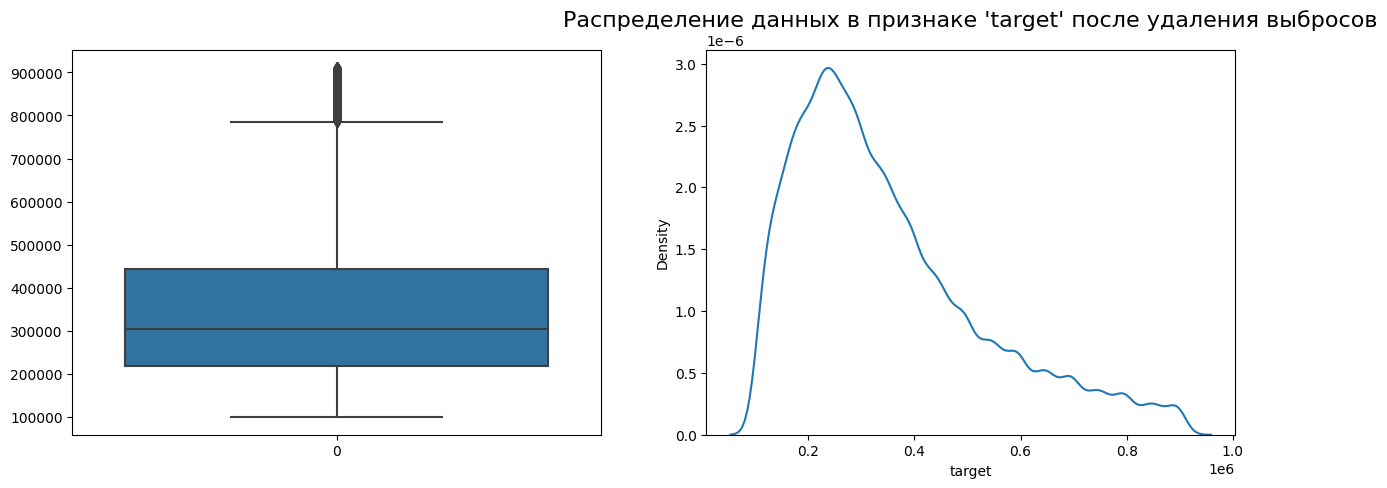

In [264]:
data = data[data['target'] >= 100000]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.title("Распределение данных в признаке 'target' после удаления выбросов", fontsize = 16)

ax1 = sns.boxplot(data['target'], ax=axes[0])
ax2 = sns.kdeplot(data['target'], ax=axes[1]);

Посмотрим на наш дата-сет после очистки его от выбросов. Переопределим в нём индексы.

In [265]:
data = data.reset_index().drop('index', axis = 1)
data

,status,propertyType,baths,sqft,target,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Heating,Parking,lotsize,Schools_number,Best_school_rating,School_distance,Home_age,Years_since_remodeling
0,active,single_family,3.5,2900.0,418000,0,51.51,17.0,226300.0,other,0,7749.0,8,7.0,10.50,5.0,0
1,for sale,single_family,3.0,1947.0,310000,0,52.11,4.0,185700.0,unknown,0,5828.0,3,4.0,1.01,5.0,0
2,for sale,townhouse,2.5,897.0,209000,0,56.42,38.0,152100.0,forced_air,0,680.0,0,0.0,0.00,104.0,0
3,active,other,2.5,1507.0,181500,0,58.07,6.0,151200.0,electric,0,4996.0,4,3.0,0.80,18.0,18
4,for sale,single_family,3.0,1930.0,311995,0,49.00,26.0,128200.0,gas,1,2056.0,3,4.0,0.60,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209774,for sale,single_family,2.0,1841.0,252990,0,49.00,26.0,123300.0,unknown,0,7749.0,3,7.0,0.30,5.0,0
209775,for sale,condo,3.0,1417.0,799000,0,59.00,77.0,490600.0,forced_air,0,7749.0,2,3.0,0.10,14.0,0
209776,for sale,condo,3.0,2000.0,674999,0,55.47,50.0,408900.0,other,0,7749.0,3,7.0,0.40,100.0,0
209777,for sale,single_family,3.0,1152.0,528000,0,60.64,37.0,383200.0,other,0,1600.0,2,5.0,0.48,74.0,74


Посмотрим, как изменились наши категориальные переменные после очистки набора данных.

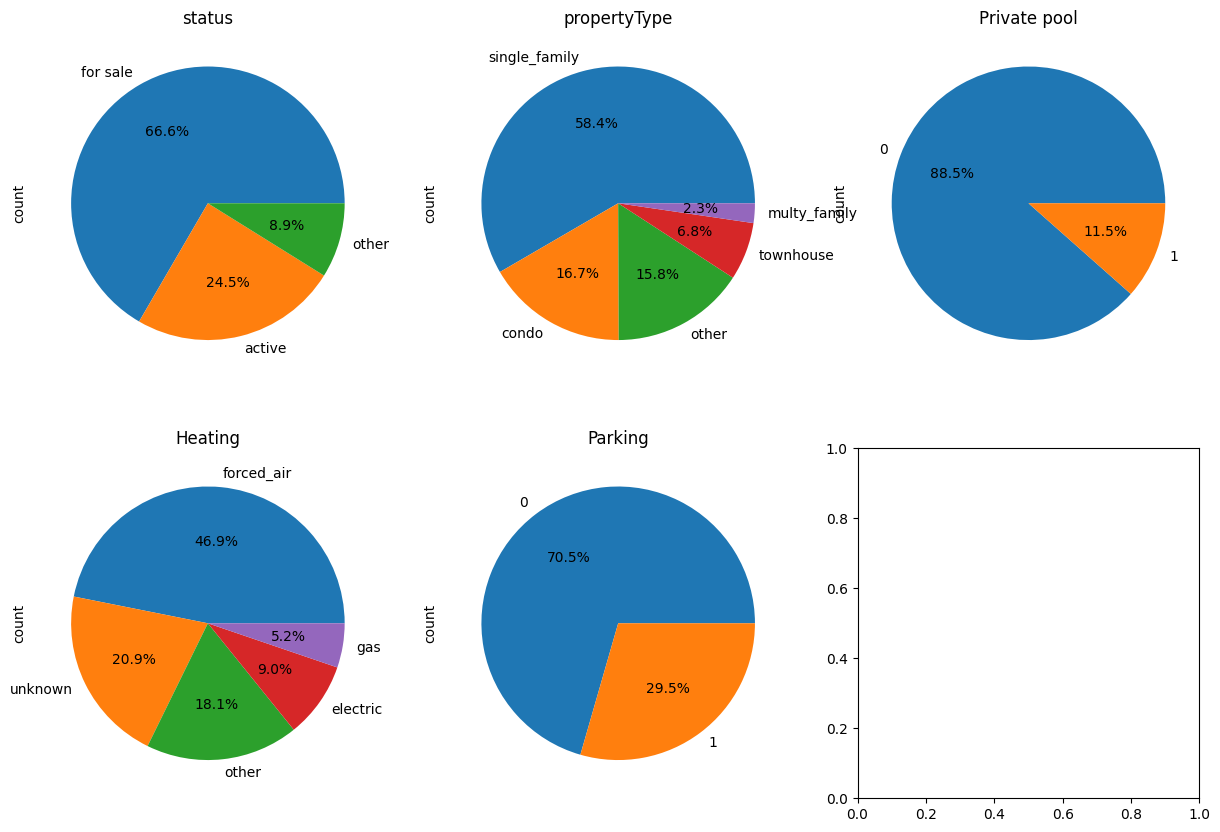

In [266]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15, 10))

ax1 = data['status'].value_counts().plot(y='status', kind='pie', title='Соотношение значений статуса дома', autopct='%1.1f%%', ax=axes[0,0])
ax1.set_title('status', fontsize=12)
ax2 = data['propertyType'].value_counts().plot(y='propertyType', kind='pie', title='Соотношение значений типа дома', autopct='%1.1f%%', ax=axes[0,1])
ax2.set_title('propertyType', fontsize=12)
ax3 = data['Private pool'].value_counts().plot(y='Private pool', kind='pie', title='Соотношение значений наличия бассейна', autopct='%1.1f%%', ax=axes[0,2])
ax3.set_title('Private pool', fontsize=12)
ax4 = data['Heating'].value_counts().plot(y='Heating', kind='pie', title='Соотношение значений типа отопления', autopct='%1.1f%%', ax=axes[1,0])
ax4.set_title('Heating', fontsize=12)
ax5 = data['Parking'].value_counts().plot(y='Parking', kind='pie', title='Соотношение значений типа парковки', autopct='%1.1f%%', ax=axes[1,1])
ax5.set_title('Parking', fontsize=12);

Посмотрим на их связь с целевой переменной.

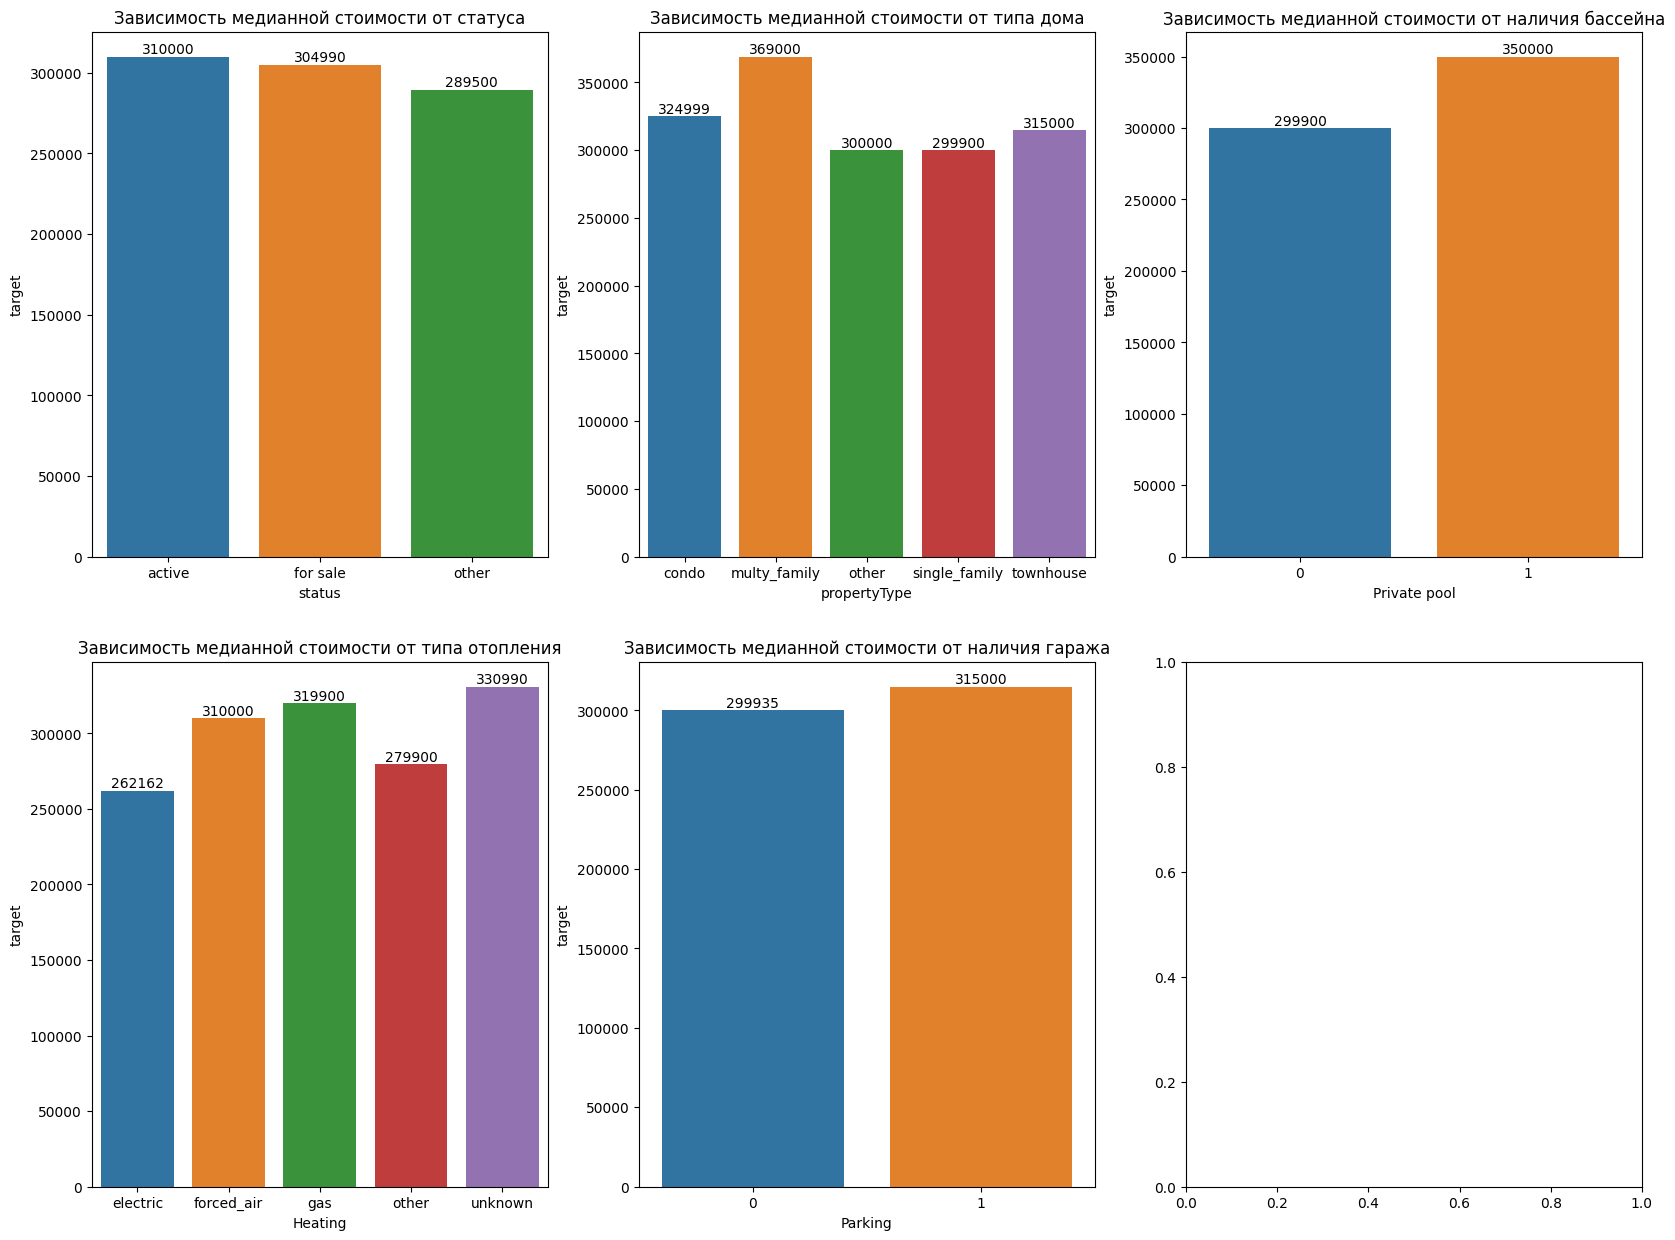

In [267]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (20, 15))

ax1 = sns.barplot(
    pd.DataFrame(data.groupby(by = 'status')['target'].median()), 
    x = pd.DataFrame(data.groupby(by = 'status')['target'].median()).index, 
    y = 'target', 
    ax = axes[0, 0]
)
ax1.set_title('Зависимость медианной стоимости от статуса')
ax1.bar_label(ax1.containers[0], fontsize=10)

ax2 = sns.barplot(
    pd.DataFrame(data.groupby(by = 'propertyType')['target'].median()), 
    x = pd.DataFrame(data.groupby(by = 'propertyType')['target'].median()).index, 
    y = 'target', 
    ax = axes[0, 1]
)
ax2.set_title('Зависимость медианной стоимости от типа дома')
ax2.bar_label(ax2.containers[0], fontsize=10)

ax3 = sns.barplot(
    pd.DataFrame(data.groupby(by = 'Private pool')['target'].median()), 
    x = pd.DataFrame(data.groupby(by = 'Private pool')['target'].median()).index, 
    y = 'target', 
    ax = axes[0, 2]
)
ax3.set_title('Зависимость медианной стоимости от наличия бассейна')
ax3.bar_label(ax3.containers[0], fontsize=10)

ax4 = sns.barplot(
    pd.DataFrame(data.groupby(by = 'Heating')['target'].median()), 
    x = pd.DataFrame(data.groupby(by = 'Heating')['target'].median()).index, 
    y = 'target', 
    ax = axes[1, 0]
)
ax4.set_title('Зависимость медианной стоимости от типа отопления')
ax4.bar_label(ax4.containers[0], fontsize=10)

ax5 = sns.barplot(
    pd.DataFrame(data.groupby(by = 'Parking')['target'].median()), 
    x = pd.DataFrame(data.groupby(by = 'Parking')['target'].median()).index, 
    y = 'target', 
    ax = axes[1, 1]
)
ax5.set_title('Зависимость медианной стоимости от наличия гаража')
ax5.bar_label(ax5.containers[0], fontsize=10);

Из представленных диаграмм обращает на себя внимание признак 'Heating'. Нам представляется целесообразным перекодировать его, объединив значения 'other' и 'electric', а также 'forced_air' и 'gas', поскольку разница в медианной стоимости между этими значениями незначительна.

In [269]:
data['Heating'] = data['Heating'].apply(
    lambda x: 1 if x == 'other' or x == 'electric'
    else 2 if x == 'forced_air' or x == 'gas'
    else 3)

Посмотрим, как изменилась связь данного признака с медианной стоимостью дома.

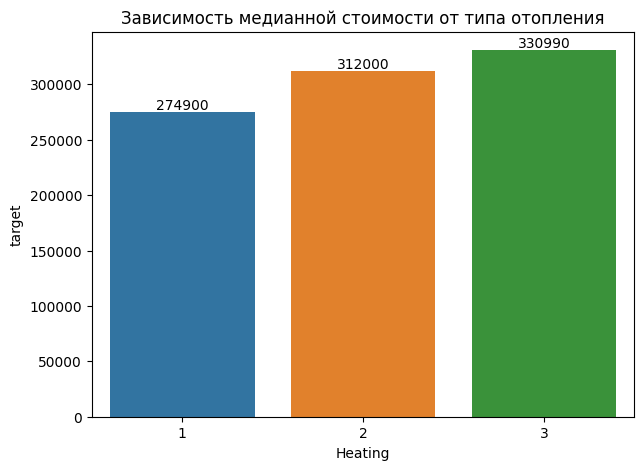

In [270]:
fig, axes = plt.subplots(figsize = (7, 5))

ax = sns.barplot(
    pd.DataFrame(data.groupby(by = 'Heating')['target'].median()), 
    x = pd.DataFrame(data.groupby(by = 'Heating')['target'].median()).index, 
    y = 'target', 
)
ax.set_title('Зависимость медианной стоимости от типа отопления')
ax.bar_label(ax.containers[0], fontsize=10);

Теперь дифференциация между типами отопления стала намного лучше. Закодируем этот признак, а также остальные категориальные признаки.

In [271]:
data = pd.get_dummies(data, columns = ['Heating'], prefix='Heating', dtype=int)
data = pd.get_dummies(data, columns = ['status'], prefix='status', dtype=int)
data = pd.get_dummies(data, columns = ['propertyType'], prefix='Type', dtype=int)

Посмотрим на корреляцию признаков с целевой переменной.

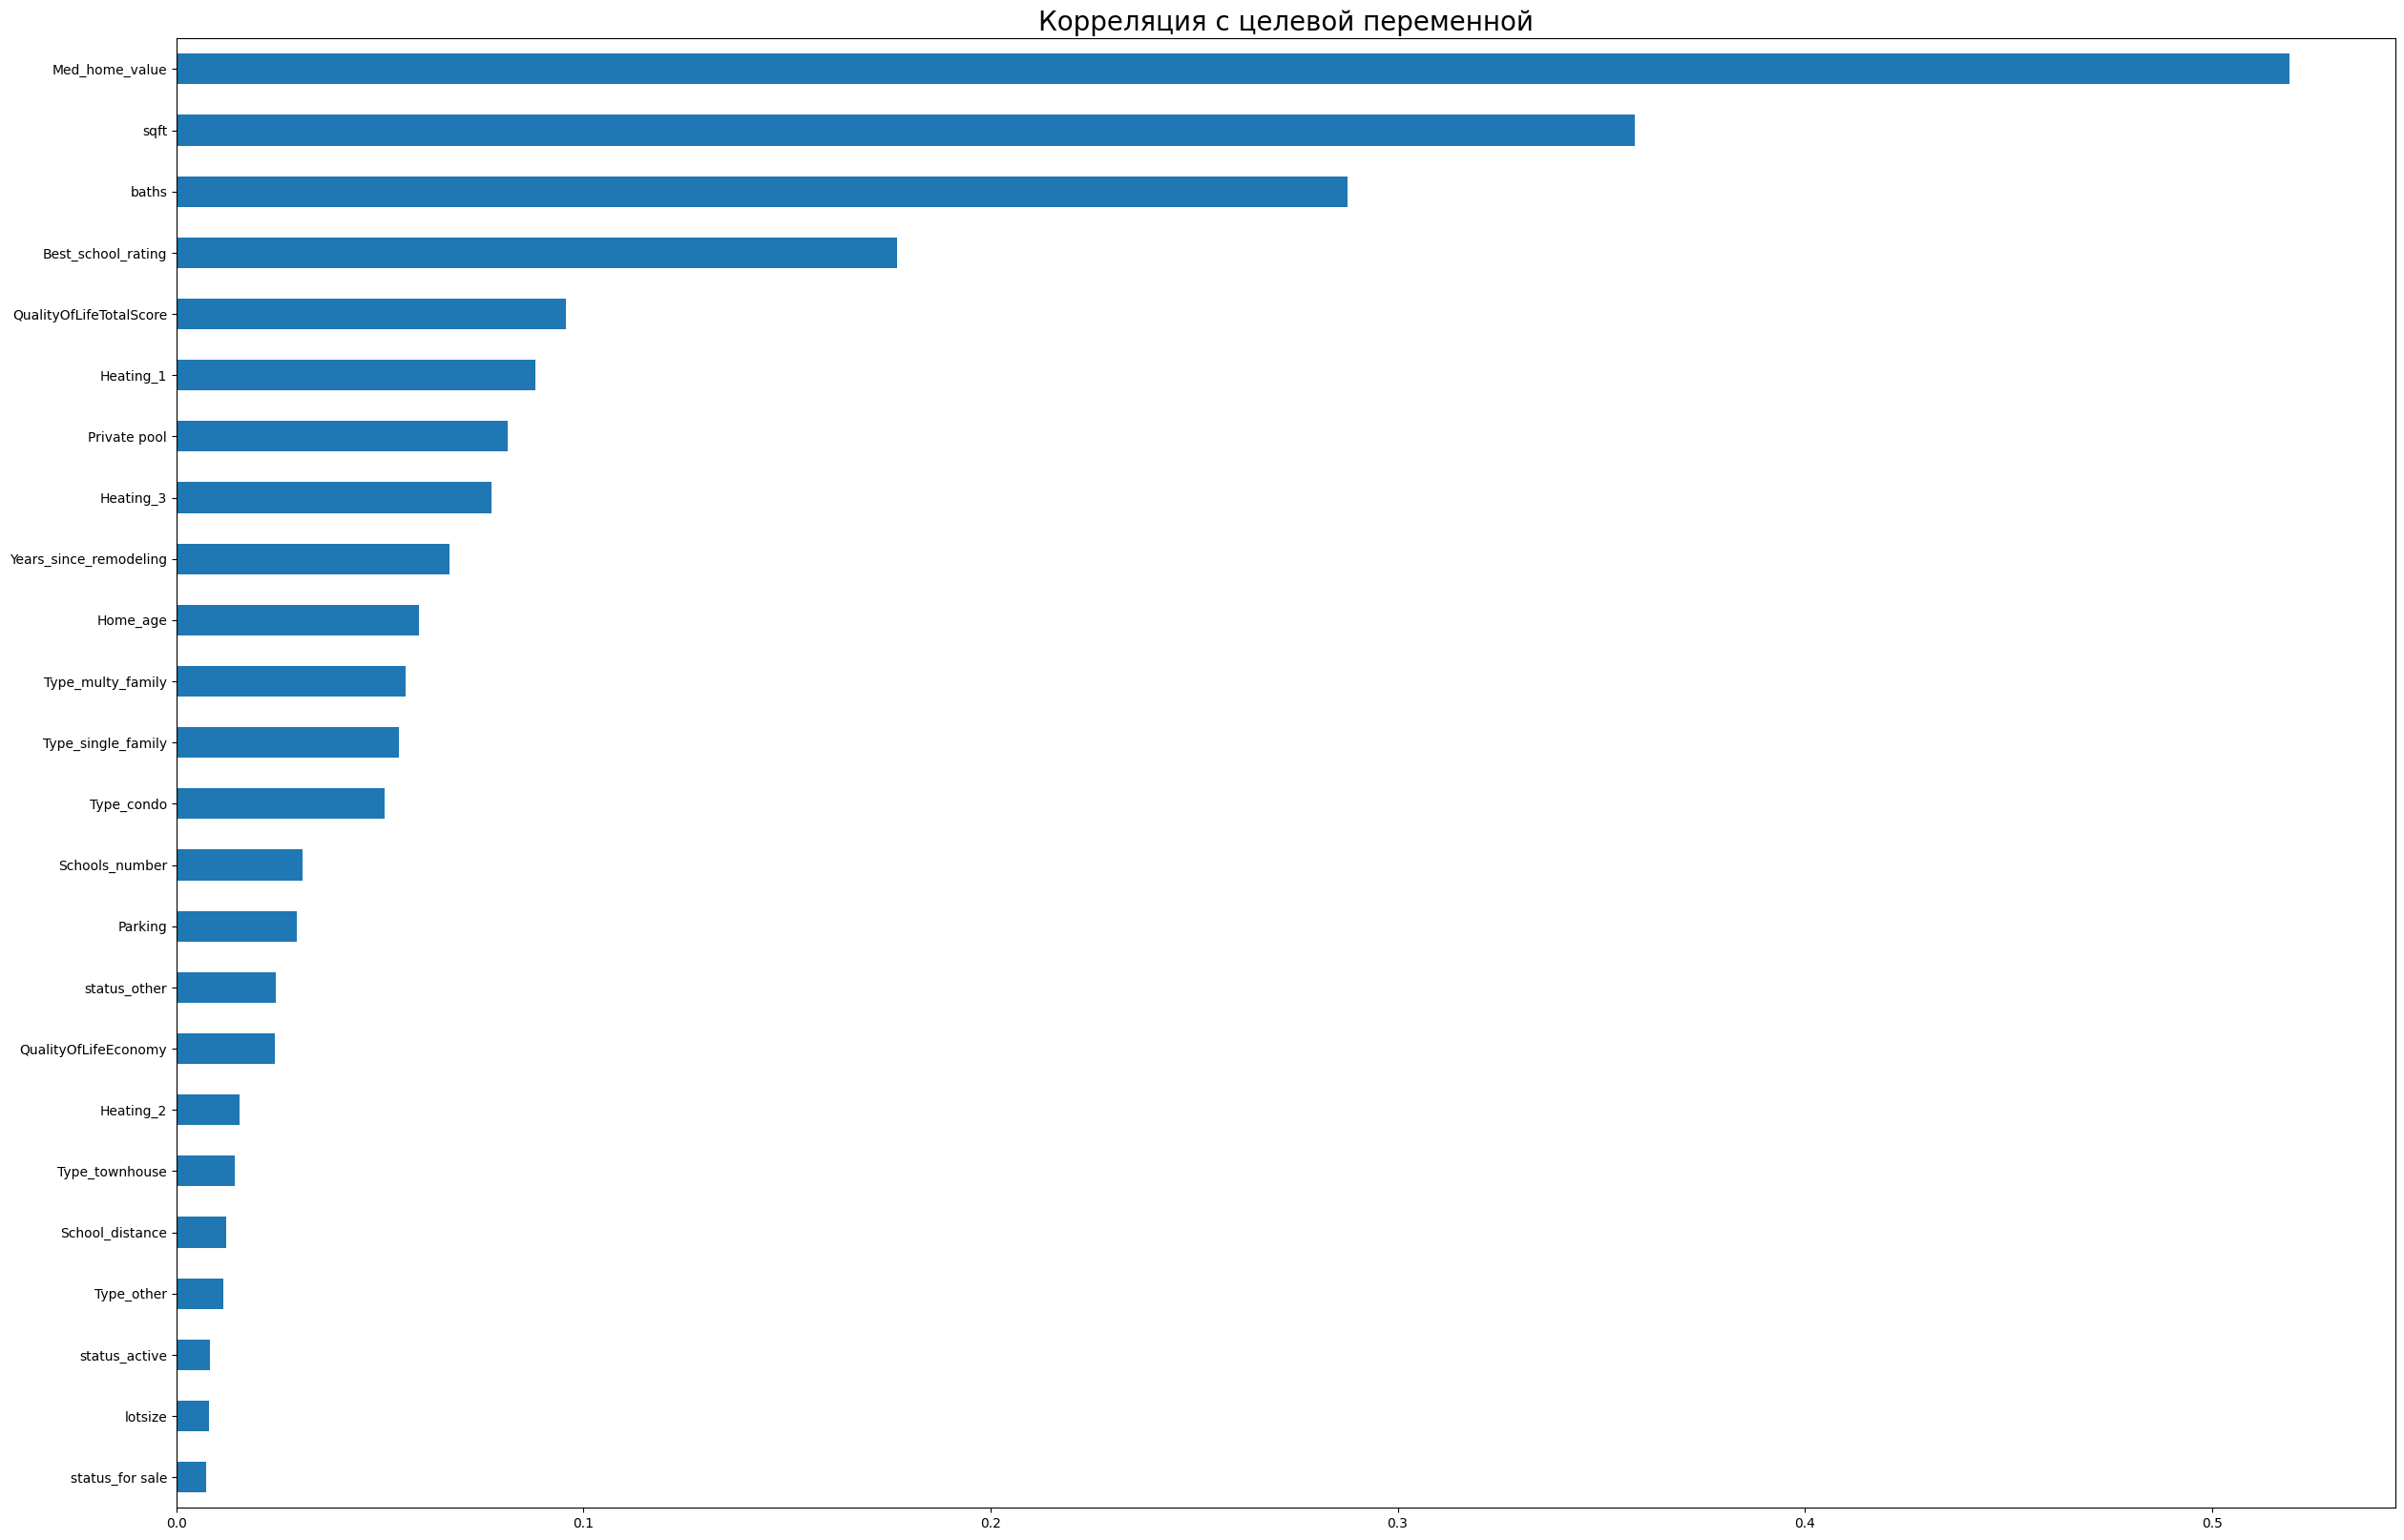

In [272]:
corr = data.corr()
fig, ax = plt.subplots(figsize = (30, 20))
corr['target'].apply(lambda x: abs(x)).sort_values()[:-1].plot.barh()
plt.title("Корреляция с целевой переменной", fontsize = 20);

Как видим, наибольшую корреляцию с целевой переменной имеет признак 'Med_home_value', сформированный нами на основе информации, извлечённой из зип-кодов домов. Из признаков, изначально содержавшихся в наболре данных, больше всего коррелируются с целевой пременной данные о площади жилья, количестве ванных комнат и лучшего рейтинга школ. Поскольку признаков в нашем дата-сете немного, оставим их все.

Проверим признаки на мультиколлинеарность.

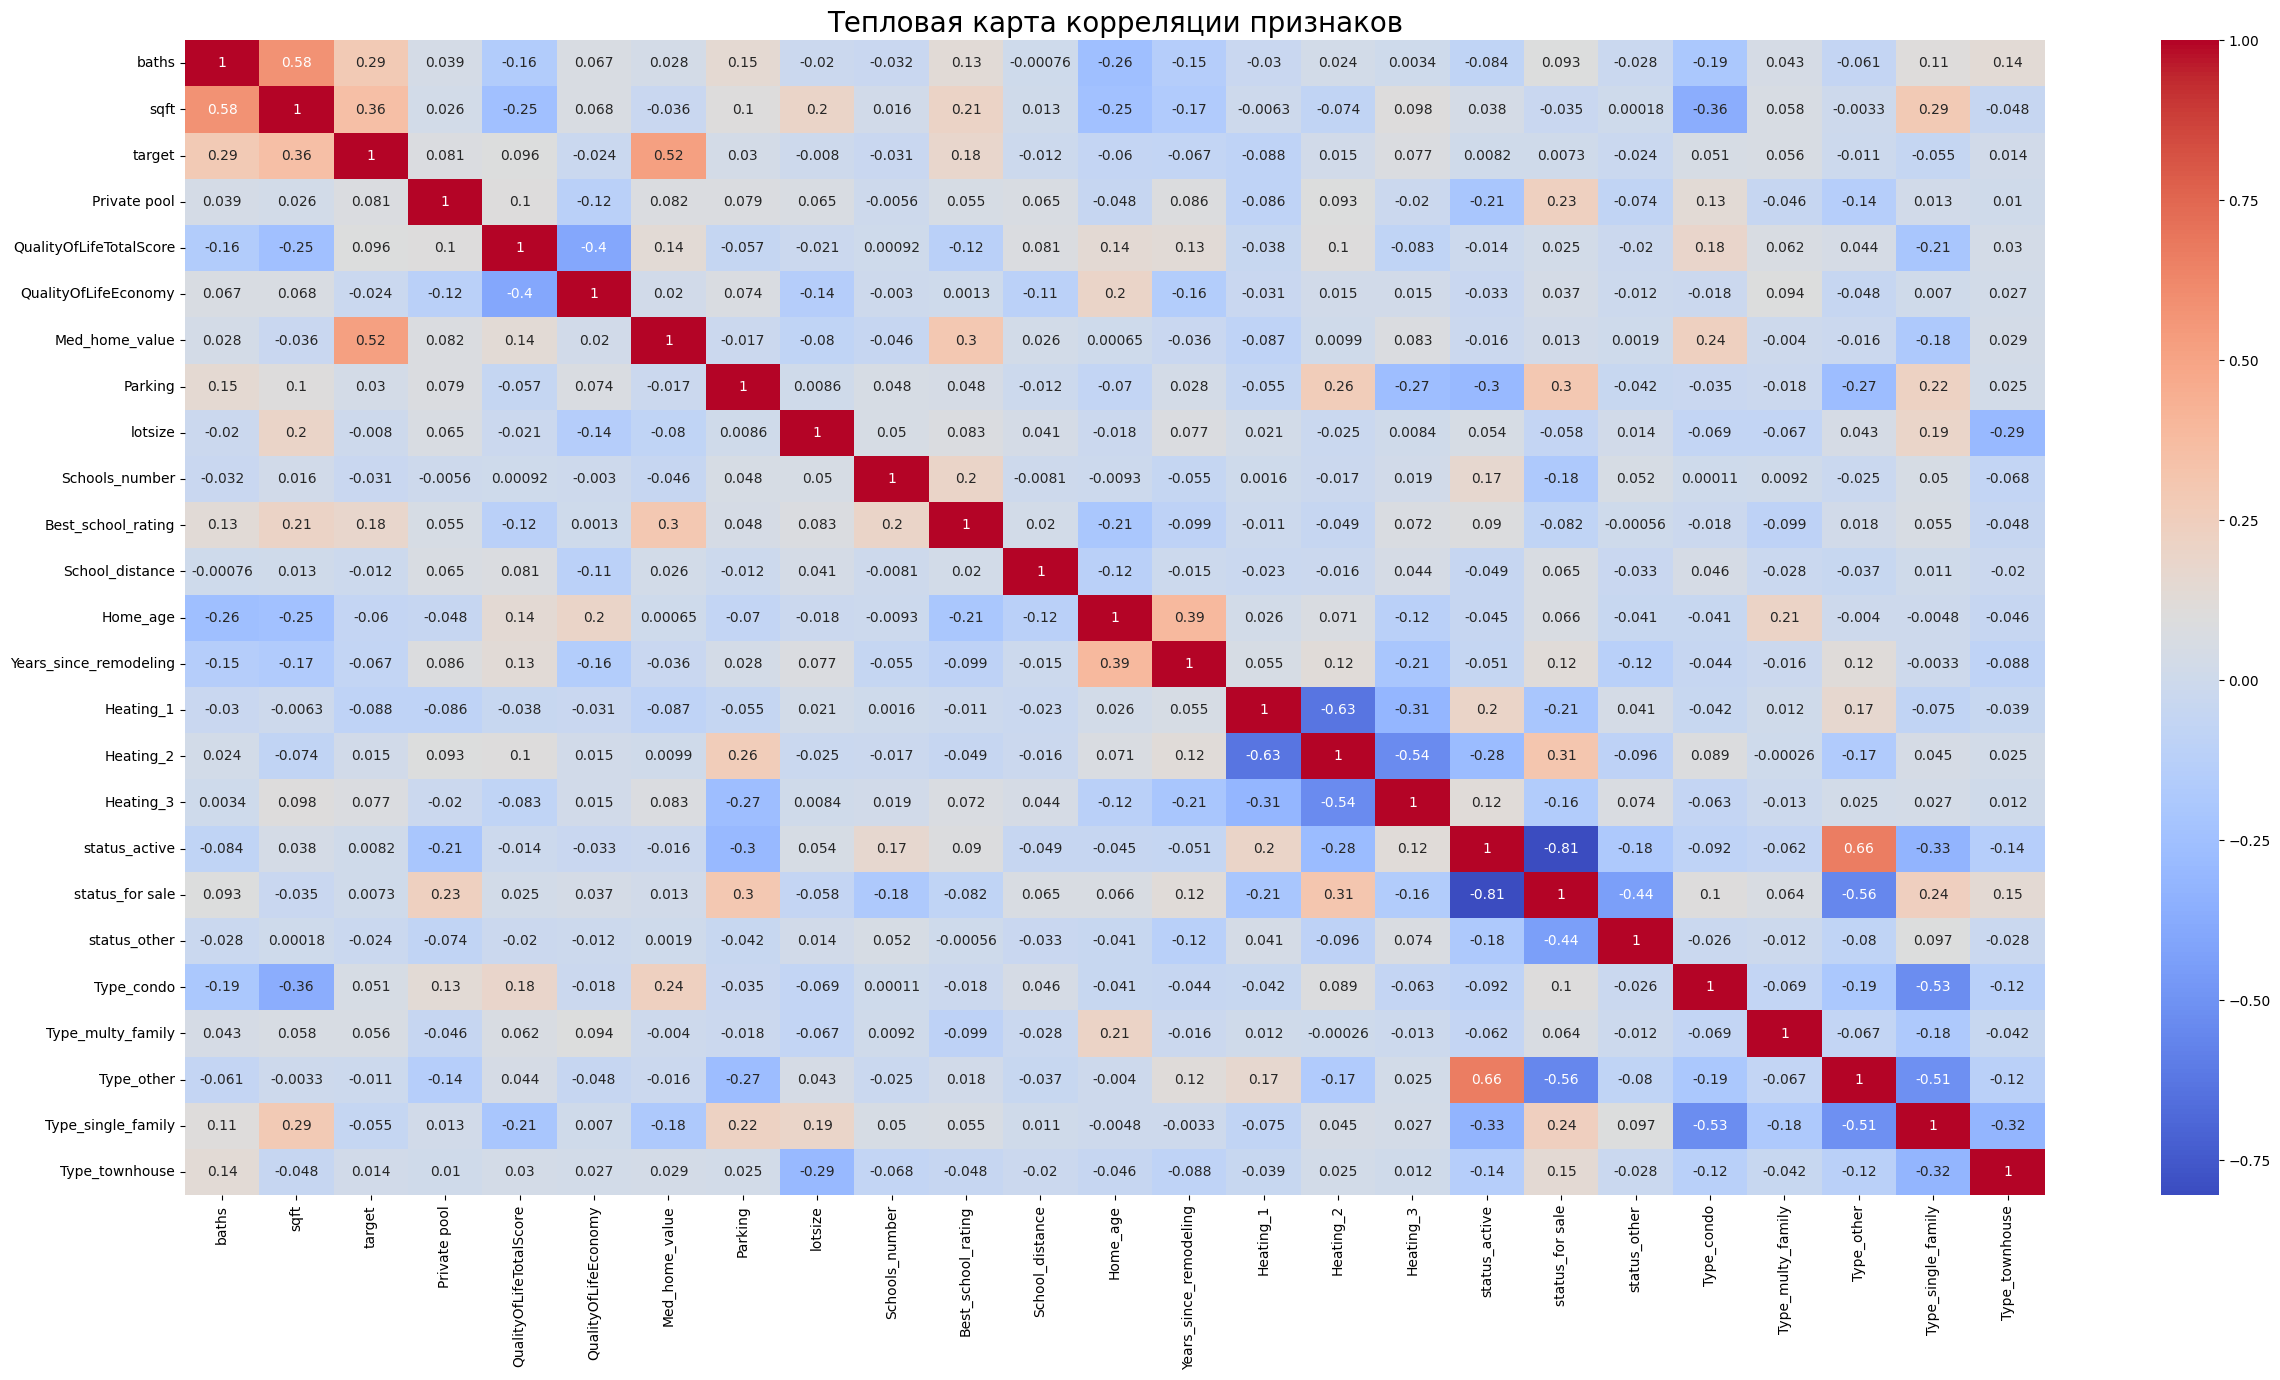

In [273]:
fig, ax = plt.subplots(figsize = (30, 15))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title("Тепловая карта корреляции признаков", fontsize = 20);

Мультиколлинеарности нет.

## <center> 4. Подбор оптимальной модели машинного обучения.

Выделим из данных целевую переменную.

In [301]:
y = data['target']
X = data.drop('target', axis = 1)

Отмасштабируем данные. Поскольку их распределение отлично от нормального, применим стандартизацию, а именно StandardScaler, т.к. данные очищены от выбросов.

In [302]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Разделим данные на обучающую и тестовую выборки.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42)

Вначале подберём наилучшую модель с гиперпараметрами по умолчанию, а затем на лучшей моделе подберём гиперпараметры. В качестве метрики качества будем использовать MAPE (mean absolute percentage error), т.к. она, на наш взгляд, наиболее информативна: по ней сразу видно, как сильно ошибается модель. Метрики качества будем заносить в словарь, чтобы не забыть их.

### LinearRegression

In [15]:
lr = LinearRegression()

lr.fit(X_train, y_train)
metrics.mean_absolute_percentage_error(y_test, lr.predict(X_test))

0.32859972040027097

In [17]:
# Пустой словарь, в который будем заносить показатели метрики
scorings = {}
# Заносим в него первое значение
scorings['LinReg'] = [round(metrics.mean_absolute_percentage_error(y_test, lr.predict(X_test)), 3)]

### LinearRegression на полиноминальных признаках

In [18]:
#Создаём генератор полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.fit_transform(X_train)
#Генерируем полиномиальные признаки для валидационной выборки
X_test_poly = poly.fit_transform(X_test)

#Создаём объект класса LinearRegression
lr_poly = LinearRegression()
#Обучаем модель
lr_poly.fit(X_train_poly, y_train)
scorings['LinReg_Poly'] = [round(metrics.mean_absolute_percentage_error(y_test, lr_poly.predict(X_test_poly)), 3)]
metrics.mean_absolute_percentage_error(y_test, lr_poly.predict(X_test_poly))

0.27927733785296355

### SGD-регрессор

In [19]:
sgdr = SGDRegressor(random_state=42)

sgdr.fit(X_train, y_train)
scorings['SGDR'] = [round(metrics.mean_absolute_percentage_error(y_test, sgdr.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, sgdr.predict(X_test))

0.3271304049949163

### LassoCV

In [20]:
lcv = LassoCV(random_state=42)

lcv.fit(X_train, y_train)
scorings['Lasso'] = [round(metrics.mean_absolute_percentage_error(y_test, lcv.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, lcv.predict(X_test))

0.32858576228239617

### RidgeCV

In [21]:
ridge = RidgeCV()

ridge.fit(X_train, y_train)
scorings['Ridge'] = [round(metrics.mean_absolute_percentage_error(y_test, ridge.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, ridge.predict(X_test))

0.32856721437981

### ElasticNetCV

In [22]:
elastic = ElasticNetCV(random_state=42)

elastic.fit(X_train, y_train)
scorings['Elastic'] = [round(metrics.mean_absolute_percentage_error(y_test, elastic.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, elastic.predict(X_test))

0.5106422096426472

### Решающие деревья

In [18]:
dtr = DecisionTreeRegressor(random_state=42)

dtr.fit(X_train, y_train)
scorings['DTR'] = [round(metrics.mean_absolute_percentage_error(y_test, dtr.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, dtr.predict(X_test))

0.19802113114849104

### Случайный лес

In [19]:
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train, y_train)
scorings['RFR'] = [round(metrics.mean_absolute_percentage_error(y_test, rfr.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, rfr.predict(X_test))

0.15814434655260934

### Градиентный бустинг

In [25]:
gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train)
scorings['GBR'] = [round(metrics.mean_absolute_percentage_error(y_test, gbr.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, gbr.predict(X_test))

0.26094458391827097

### Экстремальный градиентный бустинг

In [26]:
xbbr = xgb.XGBRegressor(random_state=42)

xbbr.fit(X_train, y_train)
scorings['XGBR'] = [round(metrics.mean_absolute_percentage_error(y_test, xbbr.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, xbbr.predict(X_test))

0.19747622462743047

### AdaBoostRegressor

In [27]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_train, y_train)
scorings['ABR'] = [round(metrics.mean_absolute_percentage_error(y_test, abr.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, abr.predict(X_test))

0.4981724400477126

### CatBoost

In [28]:
cbr = CatBoostRegressor(random_state=42, silent=True)

cbr.fit(X_train, y_train)
scorings['CBR'] = [round(metrics.mean_absolute_percentage_error(y_test, cbr.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, cbr.predict(X_test))

0.1957542851740683

Визуализируем наш словарь с метриками и выявим самые эффективные алгоритмы.

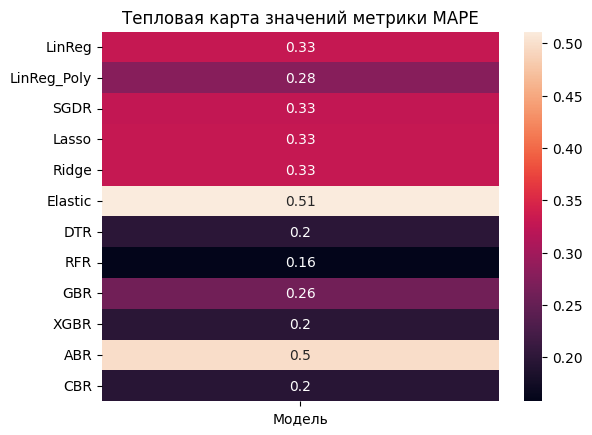

In [29]:
mean_f1_df = pd.DataFrame.from_dict(
    scorings, 
    orient='index', 
    columns=['Модель']
    )
sns.heatmap(mean_f1_df, annot=True)
plt.title('Тепловая карта значений метрики MAPE');

Таким образом, наилушую метрику качества показали алгоритмы случайный лес, CatBoost, экстремальный градиентный бустинг и решающие деревья. Попробуем построить стек из этих алгоритмов. В качестве метамодели возьмём линейную регрессию.

In [33]:
estimators = [
    ('rfr', RandomForestRegressor(random_state=42)),
    ('cbr',  CatBoostRegressor(random_state=42, silent=True)),
    ('xbbr',  xgb.XGBRegressor(random_state=42)),
    ('dtr',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# Обучаем модель
reg.fit(X_train, y_train)
scorings['Stack_lr'] = [round(metrics.mean_absolute_percentage_error(y_test, reg.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, reg.predict(X_test))

0.15452460693299494

Метрика незначительно, но улучшилась. Попробуем взять в качестве метамодели случайный лес.

In [32]:
estimators = [
    ('cbr',  CatBoostRegressor(random_state=42, silent=True)),
    ('xbbr',  xgb.XGBRegressor(random_state=42)),
    ('dtr',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg1 = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(random_state=42)
)

# Обучаем модель
reg1.fit(X_train, y_train)
scorings['Stack_rfc'] = [round(metrics.mean_absolute_percentage_error(y_test, reg1.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, reg1.predict(X_test))

0.18388997667093263

Итак, метрики качества на случайном лесе и на стекинге оказались практически одинаковыми. Попробуем подобрать гиперпараметры моделей и в качестве финальной выберем ту, на которой мерика будет наилучшей.

## <center> 5. Подбор гиперпараметров моделей.

In [38]:
def optuna_rfr(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 500, 10)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                random_state=42
                                )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.mean_absolute_percentage_error(y_test, model.predict(X_test))
  
  return score

# cоздаем объект исследования
study_rfr = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")
# ищем лучшую комбинацию гиперпараметров:
study_rfr.optimize(optuna_rfr, n_trials=20)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_rfr.best_params}')

[I 2024-04-23 19:52:08,636] A new study created in memory with name: RandomForestRegressor


[I 2024-04-23 20:07:33,828] Trial 0 finished with value: 0.1611598975442232 and parameters: {'n_estimators': 280, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.1611598975442232.
[I 2024-04-23 20:12:03,167] Trial 1 finished with value: 0.1818648757608796 and parameters: {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.1611598975442232.
[I 2024-04-23 20:33:37,125] Trial 2 finished with value: 0.1600310213793801 and parameters: {'n_estimators': 380, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.1600310213793801.
[I 2024-04-23 20:47:41,976] Trial 3 finished with value: 0.20160722595310954 and parameters: {'n_estimators': 490, 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.1600310213793801.
[I 2024-04-23 20:57:46,936] Trial 4 finished with value: 0.16047838504234102 and parameters: {'n_estimators': 200, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.1

Наилучшие значения гиперпараметров: {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 2}


Как ни странно, нам не удалось подобрать оптимальные гиперпараметры. В стекинге будем использовать случайный лес с гиперпараметрами по умолчанию.

In [40]:
def optuna_cbr(trial):
  # задаем пространства поиска гиперпараметров
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
  depth = trial.suggest_int('depth', 2, 10)
  colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.1, 1)
  min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100)
  
  # создаем модель
  model = CatBoostRegressor(learning_rate=learning_rate,
                            depth=depth,
                            colsample_bylevel=colsample_bylevel,
                            min_data_in_leaf=min_data_in_leaf,
                            random_state=42,
                            silent=True
                            )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.mean_absolute_percentage_error(y_test, model.predict(X_test))
  
  return score

# cоздаем объект исследования
study_cbr = optuna.create_study(study_name="CatBoostRegressor", direction="minimize")
# ищем лучшую комбинацию гиперпараметров:
study_cbr.optimize(optuna_cbr, n_trials=20)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_cbr.best_params}')

[I 2024-04-23 23:39:54,206] A new study created in memory with name: CatBoostRegressor
[I 2024-04-23 23:40:47,749] Trial 0 finished with value: 0.20248112017516853 and parameters: {'learning_rate': 0.043572194513091814, 'depth': 7, 'colsample_bylevel': 0.7271506294056457, 'min_data_in_leaf': 75}. Best is trial 0 with value: 0.20248112017516853.
[I 2024-04-23 23:41:11,087] Trial 1 finished with value: 0.24627889395897345 and parameters: {'learning_rate': 0.08073173828515948, 'depth': 2, 'colsample_bylevel': 0.7712643730777355, 'min_data_in_leaf': 89}. Best is trial 0 with value: 0.20248112017516853.
[I 2024-04-23 23:41:31,821] Trial 2 finished with value: 0.255847564798516 and parameters: {'learning_rate': 0.01938106801596107, 'depth': 3, 'colsample_bylevel': 0.5613294986403717, 'min_data_in_leaf': 22}. Best is trial 0 with value: 0.20248112017516853.
[I 2024-04-23 23:42:17,992] Trial 3 finished with value: 0.19668705571394535 and parameters: {'learning_rate': 0.04220845514769477, 'dept

Наилучшие значения гиперпараметров: {'learning_rate': 0.09768534650721059, 'depth': 10, 'colsample_bylevel': 0.9685455964366516, 'min_data_in_leaf': 100}


У алгоритма CatBoost метрика значительно улучшилась.

In [42]:
def optuna_xgbr(trial):
  # задаем пространства поиска гиперпараметров
  min_child_weight = trial.suggest_int('min_child_weight', 1, 50, 1)
  learning_rate = trial.suggest_float(name='learning_rate', low=0.1, high=1.0, step=0.1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  gamma = trial.suggest_float(name='gamma', low=0, high=0.5, step=0.1)
  subsample = trial.suggest_float(name='subsample', low=0.6, high=1, step=0.05)
  colsample_bytree = trial.suggest_float(name='colsample_bytree', low=0.6, high=1, step=0.05)
  n_estimators = trial.suggest_int('n_estimators', 50, 500, 10)
  
  # создаем модель
  model = xgb.XGBRegressor(min_child_weight=min_child_weight,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        gamma=gamma,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        n_estimators=n_estimators,
                        random_state=42
                        )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.mean_absolute_percentage_error(y_test, model.predict(X_test))
  
  return score

# cоздаем объект исследования
study_xgbr = optuna.create_study(study_name="XGBRegressor", direction="minimize")
# ищем лучшую комбинацию гиперпараметров:
study_xgbr.optimize(optuna_xgbr, n_trials=20)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_xgbr.best_params}')

[I 2024-04-24 00:07:31,899] A new study created in memory with name: XGBRegressor
[I 2024-04-24 00:10:17,747] Trial 0 finished with value: 0.1486031841265155 and parameters: {'min_child_weight': 3, 'learning_rate': 0.1, 'max_depth': 28, 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 0.8, 'n_estimators': 100}. Best is trial 0 with value: 0.1486031841265155.
[I 2024-04-24 00:10:23,251] Trial 1 finished with value: 0.19216970156196125 and parameters: {'min_child_weight': 39, 'learning_rate': 0.6, 'max_depth': 6, 'gamma': 0.4, 'subsample': 0.65, 'colsample_bytree': 0.95, 'n_estimators': 290}. Best is trial 0 with value: 0.1486031841265155.
[I 2024-04-24 00:10:45,626] Trial 2 finished with value: 0.2405818435136535 and parameters: {'min_child_weight': 11, 'learning_rate': 0.9, 'max_depth': 15, 'gamma': 0.4, 'subsample': 0.95, 'colsample_bytree': 0.9, 'n_estimators': 280}. Best is trial 0 with value: 0.1486031841265155.
[I 2024-04-24 00:10:51,822] Trial 3 finished with value: 0.20326263

Наилучшие значения гиперпараметров: {'min_child_weight': 3, 'learning_rate': 0.1, 'max_depth': 28, 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 0.8, 'n_estimators': 100}


На экстемальном градиентном бустинге метрика не просто улучшилась, но стала вообще наилучшей.

In [43]:
def optuna_dtr(trial):
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = DecisionTreeRegressor(max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                random_state=42
                                )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.mean_absolute_percentage_error(y_test, model.predict(X_test))
  
  return score

# cоздаем объект исследования
study_dtr = optuna.create_study(study_name="DecisionTreeRegressor", direction="minimize")
# ищем лучшую комбинацию гиперпараметров:
study_dtr.optimize(optuna_dtr, n_trials=20)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_dtr.best_params}')

[I 2024-04-24 00:34:28,667] A new study created in memory with name: DecisionTreeRegressor
[I 2024-04-24 00:34:33,130] Trial 0 finished with value: 0.20281107185628372 and parameters: {'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.20281107185628372.
[I 2024-04-24 00:34:35,775] Trial 1 finished with value: 0.20750543128421947 and parameters: {'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.20281107185628372.
[I 2024-04-24 00:34:38,771] Trial 2 finished with value: 0.20101327426969845 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.20101327426969845.
[I 2024-04-24 00:34:41,593] Trial 3 finished with value: 0.20654023061524845 and parameters: {'max_depth': 21, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.20101327426969845.
[I 2024-04-24 00:34:44,382] Trial 4 finished with value: 0.20729055336789645 and parameters: {'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.20101327

Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 2}


На деревьях решений метрику, так же как и на случайном лесе, улучшить не удалось.

Составляем стекинг из моделей с подобранными гиперпараметрами.

In [21]:
estimators = [
    ('rfr', RandomForestRegressor(random_state=42)),
    ('cbr',  CatBoostRegressor(**study_cbr.best_params, random_state=42, silent=True)),
    ('xbbr',  xgb.XGBRegressor(**study_xgbr.best_params, random_state=42)),
    ('dtr',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg2 = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# Обучаем модель
reg2.fit(X_train, y_train)
scorings['Stack_lr_hyp'] = [round(metrics.mean_absolute_percentage_error(y_test, reg2.predict(X_test)), 3)]
metrics.mean_absolute_percentage_error(y_test, reg2.predict(X_test))

0.14481386153965903

Это лучшая метрика, поэтому данную модель будем использовать в качестве финальной. Ради интереса посмотрим, на сколько долларов ошибается наша модель.

In [22]:
metrics.mean_absolute_error(y_test, reg2.predict(X_test))

47049.468774143745

Итак, наша модель ошибается в среднем на 47 тыс. дол., что довольно неплохо.

## <center> 6. Построение прогноза.

Будем исходить из того, что на вход подаётся таблица в том виде, который мы получили изначально. Значит, нам необходимо выпонить все необходимые преобразования с запросом, которые мы делали с исходным набором данных. Для удобства занесём все эти преобразования в функцию.

In [314]:
def request_processing(request):
    # Удаляем столбцы 'mls-id' и 'MlsId'
    request = request.drop(['mls-id', 'MlsId'], axis = 1)

    # Обрабатываем признак 'Private pool'
    request['Private pool'] = request.apply(presence_pool, axis=1)
    request = request.drop(['private pool', 'PrivatePool'], axis = 1)

    # Обрабатываем признак 'status'
    request['status'] = request['status'].fillna('unknown')
    request['status'] = request['status'].str.lower()
    request['status'] = request['status'].str.replace('/', '').str.strip()
    request['status'] = request['status'].astype(str)
    request['status'] = request['status'].apply(lambda x: 'other' if x not in final_items else x)

    # Обрабатываем признак 'propertyType'
    request['propertyType'] = request['propertyType'].fillna('unknown')
    request['propertyType'] = request['propertyType'].str.lower()
    request['propertyType'] = request['propertyType'].astype(str)
    request['propertyType'] = request['propertyType'].apply(lambda x: 'single_family' if x in single_family else x)
    request['propertyType'] = request['propertyType'].apply(lambda x: 'multy_family' if x in multy_family else x)
    request['propertyType'] = request['propertyType'].apply(lambda x: 'condo' if x in condo else x)
    request['propertyType'] = request['propertyType'].apply(lambda x: 'townhouse' if x in townhouse else x)
    request['propertyType'] = request['propertyType'].apply(lambda x: 'other' if x not in final_property_types else x)

    # Вводим признаки QualityOfLifeTotalScore и QualityOfLifeEconomy
    request = request.merge(
    quality_or_life_by_state, on = 'state', how = 'left'
    )

    # Вводим признаки Med_home_value
    request = request.merge(median_home_value, on = 'zipcode', how = 'left')

    # Обрабатываем признак 'baths'
    request['baths'] = request['baths'].str.replace(',', '.')
    request['baths'] = request['baths'].str.findall(r'\d*\.\d+|\d+')
    request['baths'] = request['baths'].apply(
        lambda x: float(x[0]) if type(x) == list and len(x) == 1 
        else np.nan if type(x) == list and len(x) == 0 
        else x 
    )
    request['baths'] = request['baths'].astype(float)

    # Добавляем новые признаки на основе признака 'homeFacts'
    for i in np.arange(7):
        # Извлекаем название признака
        feature_name = list(eval(request['homeFacts'][0]).values())[0][i]['factLabel']
        # Создаём новый столбец с извлечённым названием и заполняем его значениями
        request[feature_name] = request['homeFacts'].apply(lambda x: list(eval(x).values())[0][i]['factValue'])

    # Обрабатываем признак 'sqft'
    request = request.drop('homeFacts', axis = 1)
    request['sqft'] = request['sqft'].astype(str)
    request['sqft'] = request['sqft'].apply(find_numeric)
    request['sqft'] = request['sqft'].str.replace(',', '')
    request['sqft'] = request['sqft'].fillna(0)
    request['sqft'] = request['sqft'].astype(int)
    request = request.drop('Price/sqft', axis = 1)

    # Обрабатываем признак 'Year built'
    request['Year built'] = request['Year built'].apply(lambda x:
        0 if x == '' or x == None or x == 'No Data' else x
    )
    request['Year built'] = request['Year built'].astype(int)

    # Обрабатываем признак 'Remodeled year'
    request['Remodeled year'] = request['Remodeled year'].apply(lambda x:
        0 if x == '' or x == None or x == None else x
    )
    request['Remodeled year'] = request['Remodeled year'].astype(int)

    # Обрабатываем признак 'Heating'
    request['Heating'] = request['Heating'].apply(lambda x: 'No Data' if x == '' else x)
    request['Heating'] = request['Heating'].fillna('No Data')
    request['Heating'] = request['Heating'].apply(lambda x: x.lower())
    request['Heating'] = request['Heating'].apply(lambda x: 'gas' if x in gas else x)
    request['Heating'] = request['Heating'].apply(lambda x: 'electric' if x in electric else x)
    request['Heating'] = request['Heating'].apply(
        lambda x: 'forced_air' if x in air 
        else x if x == 'no data' or x == 'gas' or x == 'electric'
        else 'other'
    )

    # Обрабатываем признак 'Parking'
    request = request.drop ('Cooling', axis = 1)
    request['Parking'] = request['Parking'].apply(lambda x: 'No Data' if x == '' else x)
    request['Parking'] = request['Parking'].fillna('No Data')
    request['Parking'] = request['Parking'].apply(lambda x: x.lower())
    request['Parking'] = request['Parking'].apply(lambda x:
        1 if x in garage
        else 0
    )

    # Обрабатываем признак 'lotsize'
    request['lotsize'] = request['lotsize'].fillna('No Data')
    request['lotsize'] = request['lotsize'].apply(lambda x: 
        'No Data' if x == '' or x == '—' or x == '-- sqft lot'
        else x
    )
    request['lotsize'] = request['lotsize'].apply(lambda x: x.lower())
    request['lotsize'] = request['lotsize'].str.replace(',', '')
    request['lotsize'] = request['lotsize'].apply(lambda x:
        round(float(x.split()[0])*43560.039) if ('acres' in x) or ('acre' in x)
        else int(x.split()[0]) if ('sqft' in x) or ('sq. ft.' in x)
        else x         
    )
    request['lotsize'] = request['lotsize'].apply(lambda x:
        np.nan if x == 'no data'
        else int(x)       
    )

    # Вводим признаки 'Schools_number', 'Best_school_rating' и 'School_distance'
    request = request.drop('fireplace', axis = 1)
    request['Schools_number'] = request['schools'].apply(lambda x: len(eval(x)[0]['rating']))
    for k in np.arange(0, len(request)):
        temp = set()
        for i in np.arange(0, len(eval(request['schools'][k])[0]['rating'])):
            temp.add(eval(request['schools'][k])[0]['rating'][i].split('/')[0])
        if 'None' in temp:
            temp.remove('None')
        elif 'NR' in temp:
            temp.remove('NR')
        else:
            None

        if len(temp) == 0:
            request.loc[k, 'Best_school_rating'] = 0
        else:
            request.loc[k, 'Best_school_rating'] = max(temp)
    request['Best_school_rating'] = request['Best_school_rating'].apply(
        lambda x: 'no data' if x == 'NA' or x == '' else x
        )
    for k in np.arange(0, len(request)):
        temp = set()
        for i in np.arange(0, len(eval(request['schools'][k])[0]['data']['Distance'])):
            temp.add(eval(request['schools'][k])[0]['data']['Distance'][i].replace('mi', '').strip())
        if 'None' in temp:
            temp.remove('None')
        else:
            None

        if len(temp) == 0:
            request.loc[k, 'School_distance'] = 0
        else:
            request.loc[k, 'School_distance'] = min(temp)
        
    request['School_distance'] = request['School_distance'].astype(float)
    request = request.drop('schools', axis = 1)

    # Вводим признаки 'Home_age' и 'Years_since_remodeling'
    request = request.drop('beds', axis = 1)
    request = request.drop('stories', axis = 1)
    request['Home_age'] = 2024 - request['Year built']
    request = request.drop('Year built', axis = 1)
    request['Home_age'] = request['Home_age'].apply(lambda x: np.nan if x == 2024 else x)
    request['Years_since_remodeling'] = 2024 - request['Remodeled year']
    request = request.drop('Remodeled year', axis = 1)
    request['Years_since_remodeling'] = request['Years_since_remodeling'].apply(lambda x: 0 if x == 2024 else x)

    # Заполнение пропусков
    request['Heating'] = request['Heating'].apply(lambda x: np.nan if x == 'no data' else x)
    request['Parking'] = request['Parking'].apply(lambda x: np.nan if x == 'no data' else x)
    request['Best_school_rating'] = request['Best_school_rating'].apply(lambda x: np.nan if x == 'no data' else x)
    request['sqft'] = request['sqft'].apply(lambda x: np.nan if x == 0 else x)
    request['status'] = request['status'].apply(lambda x: np.nan if x == 'unknown' else x)
    request['propertyType'] = request['propertyType'].apply(lambda x: np.nan if x == 'unknown' else x)
    request['Best_school_rating'] = request['Best_school_rating'].apply(lambda x: int(x) if type(x) == str else x)

    # Заполнение возможных пропусков в столбце 'Med_home_value'
    for i in np.arange(0, len(request)):
        if np.isnan(request['Med_home_value'].loc[i]):
            request.loc[i, 'Med_home_value'] = cities_dict[request.loc[i]['city']]
        else:
            None

    for i in np.arange(0, len(request)):
        if np.isnan(request['Med_home_value'].loc[i]):
            request.loc[i, 'Med_home_value'] = states_dict[request.loc[i]['state']]
        else:
            None

    # Заполнение возможных пропусков в столбце 'Best_school_rating'
    for i in np.arange(0, len(request)):
        if np.isnan(request['Best_school_rating'].loc[i]):
            request.loc[i, 'Best_school_rating'] = zipcodes_dict[request.loc[i]['zipcode']]
        else:
            None

    for i in np.arange(0, len(request)):
        if np.isnan(request['Best_school_rating'].loc[i]):
            request.loc[i, 'Best_school_rating'] = cities_dict[request.loc[i]['city']]
        else:
            None

    for i in np.arange(0, len(request)):
        if np.isnan(request['Best_school_rating'].loc[i]):
            request.loc[i, 'Best_school_rating'] = states_dict[request.loc[i]['state']]
        else:
            None

    # Заполнение возможных пропусков в столбце 'Home_age'
    for i in np.arange(0, len(request)):
        if np.isnan(request['Home_age'].loc[i]):
            request.loc[i, 'Home_age'] = zipcodes_dict[request.loc[i]['zipcode']]
        else:
            None

    for i in np.arange(0, len(request)):
        if np.isnan(request['Home_age'].loc[i]):
            request.loc[i, 'Home_age'] = cities_dict[request.loc[i]['city']]
        else:
            None

    for i in np.arange(0, len(request)):
        if np.isnan(request['Home_age'].loc[i]):
            request.loc[i, 'Home_age'] = states_dict[request.loc[i]['state']]
        else:
            None

    request = request.drop(['street', 'city', 'zipcode', 'state'], axis = 1)
    request['sqft'] = request['sqft'].fillna(1859)
    request['propertyType'] = request['propertyType'].fillna('single_family')
    request['status'] = request['status'].fillna('for sale')
    request['baths'] = request['baths'].fillna(2.5)
    request['Heating'] = request['Heating'].fillna('unknown')
    request['lotsize'] = request['lotsize'].fillna(7749)
    request['Heating'] = request['Heating'].apply(
        lambda x: 1 if x == 'other' or x == 'electric'
        else 2 if x == 'forced_air' or x == 'gas'
        else 3)
    request['Heating_1'] = request['Heating'].apply(lambda x: 1 if x == 1  else 0)
    request['Heating_2'] = request['Heating'].apply(lambda x: 1 if x == 2  else 0)
    request['Heating_3'] = request['Heating'].apply(lambda x: 1 if x == 3  else 0)
    request['status_active'] = request['status'].apply(lambda x: 1 if x == 'active'  else 0)
    request['status_for sale'] = request['status'].apply(lambda x: 1 if x == 'for sale'  else 0)
    request['status_other'] = request['status'].apply(lambda x: 1 if x == 'other'  else 0)
    request['Type_condo'] = request['propertyType'].apply(lambda x: 1 if x == 'condo'  else 0)
    request['Type_multy_family'] = request['propertyType'].apply(lambda x: 1 if x == 'multy_family'  else 0)
    request['Type_other'] = request['propertyType'].apply(lambda x: 1 if x == 'other'  else 0)
    request['Type_other'] = request['propertyType'].apply(lambda x: 1 if x == 'other'  else 0)
    request['Type_single_family'] = request['propertyType'].apply(lambda x: 1 if x == 'single_family'  else 0)
    request['Type_townhouse'] = request['propertyType'].apply(lambda x: 1 if x == 'townhouse'  else 0)
    request = request.drop(['Heating', 'status', 'propertyType'], axis = 1)

    return request

Проверим работу функции. Допустим в качестве запроса нам подали первую строку нашего исходного дата-сета.

In [335]:
data_first = pd.read_csv('data.csv')
request = data_first.loc[[0]]
request

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"


В этом запросе, естественно, не будет целевой переменной, ведь нам же нужно её предсказать.

In [328]:
request = request.drop('target', axis = 1)

In [329]:
# Применяем к запросу нашу функцию.
request = request_processing(request)
request

,baths,sqft,Private pool,QualityOfLifeTotalScore,QualityOfLifeEconomy,Med_home_value,Parking,lotsize,Schools_number,Best_school_rating,...,Heating_2,Heating_3,status_active,status_for sale,status_other,Type_condo,Type_multy_family,Type_other,Type_single_family,Type_townhouse
0,3.5,2900,0,51.51,17,226300,0,7749.0,8,7,...,0,0,1,0,0,0,0,0,1,0


Функция работает. Отмасштабируем данные и сделаем прогноз.

In [330]:
request = scaler.transform(request)
y_pred = reg2.predict(request)
y_pred

array([448669.76067252])

Реальная цена этого дома, как указано в исходном наборе данных, 418 тыс. дол., т.е. наша модель ошиблась на 30.670 дол.

Составим и обучим пайплайн.

In [340]:
ppln = Pipeline([
    ('StandardScaler', scaler),
    ('Stacking', reg2)
])

X_ppln = data.drop('target', axis = 1)
y_ppln = data['target']

ppln.fit(X_ppln, y_ppln)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('Stacking',
                 StackingRegressor(estimators=[('rfr',
                                                RandomForestRegressor(random_state=42)),
                                               ('cbr',
                                                <catboost.core.CatBoostRegressor object at 0x0000022DDE177950>),
                                               ('xbbr',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=Non...
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=28,
                                                             max_leaves=None,
                                                             min_child_weight=3,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('dtr',
                                                DecisionTreeRegressor(random_state=42))],
                                   final_estimator=LinearRegression()))])

## <center> 7. Деплой модели.

Сериализуем pipeline и записываем результат в файл

In [346]:
with open('my_new_pipeline.pkl', 'wb') as output:
    pickle.dump(ppln, output)

Зафиксируем зависимости

In [ ]:
pip freeze > requirements.txt

Создаём образ.

In [ ]:
docker build -t diplom .

Модель готова к деплою.

## <center> Выводы.

В результате проделанной работы была создана модель машинного обучения, которая предсказывает стоимость дома для риелторского агенства. Метрика MAPE на финальной модели составляет 0.1448, что составляет погрешность в 47049.47 дол. Модель была сериализована и подготовлена к деплою.

*Цель проекта достигнута.*